# Pairs Trading using Reinforcement Learning - Stock Trading using Actor Critic Model

**Unit:** Artificial Intelligence CITS4404 <br>
**Lecturer:** Dr Yuliya Karpievitch <br>
**Date:** 24th October 2019

**Group members:** <br>
Madeleine Lim 21708238 <br>
Robin Markwitz 21968594 <br>
Ruan Scheepers 21980258 <br>
Asaf Silman    21985278


In [2]:
#imports
import pandas as pd
from datetime import timedelta
import numpy as np
import matplotlib.pyplot as plt

#for the trading environment
import gym
from gym import error, spaces, utils
from gym.utils import seeding

#for the models
import tensorflow as tf
import tensorflow.keras.layers as kl
import tensorflow.keras.backend as K
import tensorflow.keras.losses as kls

from src.gym_pairs_trading import PairsTradingEnv

In [2]:
print(tf.__version__)

2.0.0


## 1. Introduction
***Pairs trading*** is a trading strategy which identifies a pair of stocks which exhibit similar price movements in order to exploit financial markets that are out of equilibrium. The pair of stocks are of similar company size and within similar industry sectors. The strategy ustilises the *spread* of the pair, which is the difference between the normalised log prices.

***Reinforcement learning*** is machine learning (ML) method that involves an agent which can perform some actions within an environment. The model learns about its environment through discovery of which actions to take in certain situations. It can be rewarded or penalised based on the task goal. We will be using the actor-critic (AC) reinforcement learning method.

***Actor-Critic model***  is a ML method with two models - the Actor and the Critic. The Actor will perform an action which affects the environment. Then the Critic judges the effect of this action on the environment. The Critic must teach the Actor to make better decisions given the state of the environment.

### 1.1 Project strategy

This project aims to implement the AC model in order to increase its portfolio value based on the pairs trading strategy. 

The Actor takes in observations, such as stock price changes, the spread between pairs, and if it is currently holding any stock (i.e. whether it is in the spread). Based on these observations the model maps a probability distribution of which action it should take of three:
* Buy - Buying stock with all cash balance
* Sell - Selling all stock
* Hold - No action taken

Buying in this case means to place a bet that the prices will converge. Selling signifies closing the bet, and taking any profits. Based on which action is taken, the environment assigns a reward to the action. We used the portfolio percent change in net asset value (NAV) as the reward.

The Critic takes the same observations as the actor, but outputs an estimated reward. In this way the Critic helps to train the actor to make good choices.


The data used for training are the Apple and Microsoft stock data, which are in simlar industry sectors. The environment is created using `gym` which is a library commonly used for Reinforcement Learning tasks. The model is compared to a random strategy model over the same time frame which can be run within this notebook. The model itself is implemented within this notebook following the random strategy model.

## 2. Data

This project sources stock data from `alpha_vantage`. The `data_source.py` file contained within the environment source files implement this. Below is an exmaple of the data cleaning process and some examples of the stock data prices over time.

### 2.1 Demo code for loading Alpha Vantage data

First we create a `DataSource` and `MarketMetrics` instance which will help retreving data efficiently, and calculate metrics from the data.

For this example we used Apple (AAPL) and Microsoft (MSFT) for pairs trading. but any valid stock code can be submitted.

For the demo only a subset of the data is retrieved, specifing `size='full'` will download the whole dataset.
The normalisation window we used was 20 days , this is close to a months worth of trading days, and we felt this was a suitable window for the task. However this can also be changed to a higher/lower window.

In [39]:
from src.gym_pairs_trading.envs.data_source import DataSource
from src.gym_pairs_trading.envs.market_metrics import MarketMetrics

# Create a data instance
STOCK_1_SYMBOL = "AAPL" # Apple stock symbol
STOCK_2_SYMBOL = "MSFT" # Microsoft stock symbol, can be any stock symbol such as amazon (AMZM)

ds = DataSource(STOCK_1_SYMBOL, STOCK_2_SYMBOL, size='compact')
mm = MarketMetrics(window_size=20)

Now that the we have a datasource and metric instance ready, we can initialise a list for the prices and spread values

In [54]:
stock_1_prices = []
stock_2_prices = []
stock_prices_spread = []

Iterate though datasource, and calculate the spread. For the first `window_size` days the spread will be invalid, because ther is not enough data to calculate the normalised price. These days will be set to 0.

In [55]:
mm.reset()

for _, data in ds:
    stock_1_price = data[0]
    stock_2_price = data[1]
    
    spread, ready = mm.update(stock_1_price, stock_2_price)
    if ready:
        stock_prices_spread.append(spread)
    else:
        stock_prices_spread.append(0)
    stock_1_prices.append(stock_1_price)
    stock_2_prices.append(stock_2_price)

Plot the raw stock prices of stock 1 and stock 2

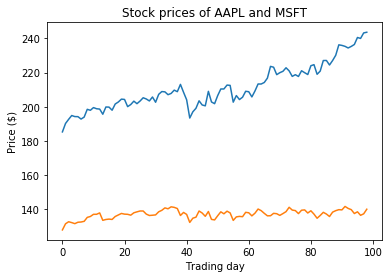

In [51]:
plt.plot(stock_1_prices)
plt.plot(stock_2_prices)
plt.title(f"Stock prices of {STOCK_1_SYMBOL} and {STOCK_2_SYMBOL}")
plt.ylabel("Price ($)")
plt.xlabel("Trading day")

plt.show()

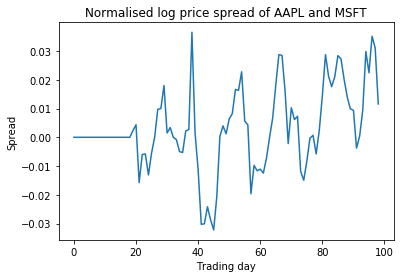

In [53]:
plt.plot(normalised_stock_prices)
plt.title(f"Normalised log price spread of {STOCK_1_SYMBOL} and {STOCK_2_SYMBOL}")
plt.ylabel("Spread")
plt.xlabel("Trading day")

plt.show()

## 3. Environment

The environment was implemented with the `gym` library which requires a specific directory structure for the `env` source files. There are four scripts which make up the environment for this project:

`data_source.py` - Loads the pair of stock data in. Need to find the minimum starting date of each stock to only use intersection of stock data. The main purpose of this script is to return a data point, which consists of *[s1 close, s2 close, s1 pct, s2 pct]*. We choose to get percentage change rather than absolute value because stock prices are not normalised.

`market_metrics.py` - Converts stock data into observable values, and calculates the spread of the pair of stock data. We set a window size of 20 days (which is what 2 weeks worth of working days amounts to) so we can normalise that prices in order to calculate the spread.

`trading_sim.py` - Applies the actions chosen by the Actor to the environment. Responsible for accounting stock balances and cash balances, and executing trades and rules. It calculates the net asset value of the portfolio. 

`pairs_trading_env.py` - Implements the gym interface in order to initialise the environment.


### 3.1 A note on data_source.py

Some companies sometimes do a stock split, where a company intentinally dilutes the stock supply to reduce the price, for example a 2-1 split where each share holder gets 2 shares for every 1 share the held before the split. This sometimes happens to make the stock price more accessible to investors, hopefully increasing their liquidity. To account for this the price of each stock will be multiplied by the split factor to normalise the stock price. This logic is built into the `data_source.py` file and eliminates dramatic declines in stock prices that are associated with a stock split.

## 4. Random strategy

The benchmark of the project was a random strategy of randomly buying, selling or holding. This strategy had trading rules hardcoded to prevent illegal moves. The AC model did not have trading rules encoded in order to encourage it to learn these rules, by punishing illegal moves with fines. 

You can view the random strategy below.

In [1]:
# INSERT RANDOM STRATEGY CODE

## 5. Models

## 5.1 Model v1 setup

In [147]:
from tensorflow.keras.models import Sequential, Model
class ActorCritic(object):
    """ActorCritic model for continous observation space, and discrete action space
    
    Arguments:
        object {[type]} -- [description]
    
    Returns:
        [type] -- [description]
    """
    def __init__(self, env, **kwargs):
        self.env=env

        self.learning_rate = kwargs.get('learning_rate', 0.001)
        self.gamma = kwargs.get('gamma', 0.99)
    
        self.saved_actions = []
        self.saved_values = []
        self.rewards = []
        
        self.actor_model  = self._create_actor_model()
        self.critic_model = self._create_critic_model()

    def _create_actor_model(self):
        model = tf.keras.Sequential([
            kl.Dense(48, activation='relu', input_shape=self.env.observation_space.shape),
            kl.Dense(128, activation='relu'),
            kl.Dense(3, activation='softmax', name='policy_logits')
        ])
        model.compile(loss=self._actor_loss(), optimizer='adam')
        return model

    def _create_critic_model(self):
        model = tf.keras.Sequential([
            kl.Dense(48, activation='relu', input_shape=self.env.observation_space.shape),
            kl.Dense(128, activation='relu'),
            kl.Dense(1, activation='relu')
        ])
        model.compile(loss="mse", optimizer='adam')

        return model
    
    
    def evaluate_loss(self, y_true, y_pred):
        print(y_true + y_pred)
        return K.mean(y_true - )
    
    def _actor_loss(self):
        def loss(y_true,y_pred):y_pred/100
            return self.evaluate_loss(y_true, y_pred)
        return loss

    def _critic_loss(self):
        def loss(y_true,y_pred):
            return K.mean(K.square(y_pred - y_true), axis=-1)
        
        return loss

    def train(self, obs_history):
        #pv magic number
        advantages = np.array(self.rewards) - np.array(self.saved_values)
        
        #take negative since we want to minimize LOSS
        #action_loss = -1*advantages*np.array(self.saved_actions)
        y_label = []
        for adv, action in zip(advantages, np.array(self.saved_actions)):
            y_label.append([adv,adv,adv])
        
        y_label = np.array(y_label)
        self.actor_model.train_on_batch(np.array(obs_history), y_label)
        self.critic_model.train_on_batch(np.array(obs_history), self.rewards)
    
    def eval_state(self, obs):
        return self.critic_model.predict(obs[None, :])
    
    def predict_action(self, obs):
        logits = self.actor_model.predict(obs[None, :])
        return logits[0]
    
    def predict(self,obs):
        return self.eval_state(obs), self.predict_action(obs)
    
    def reset(self):
        self.saved_actions = []
        self.saved_values = []
        self.rewards = []

In [148]:
env = PairsTradingEnvV2("AAPL","MSFT")
model = ActorCritic(env)

Tensor("loss_83/policy_logits_loss/add:0", shape=(None, 3), dtype=float32)


Observation: Changes 1, Changes 2, Spread

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.32121128 0.32124662 0.32058313]
 [0.33129233 0.3308067  0.33035007]
 [0.34753045 0.34837857 0.347438  ]
 [0.33391303 0.33232826 0.33511937]
 [0.33849984 0.3376352  0.3388358 ]
 [0.3468873  0.34639844 0.34804645]
 [0.32832733 0.327794   0.32828224]
 [0.3280115  0.32812217 0.3279987 ]
 [0.34837213 0.3476222  0.34711266]
 [0.3575496  0.3575422  0.3581503 ]
 [0.34803358 0.34564424 0.35009578]
 [0.34500614 0.34391034 0.3458415 ]
 [0.33193535 0.3321219  0.33239707]
 [0.31992602 0.31978738 0.31979397]], shape=(14, 3), dtype=float32)


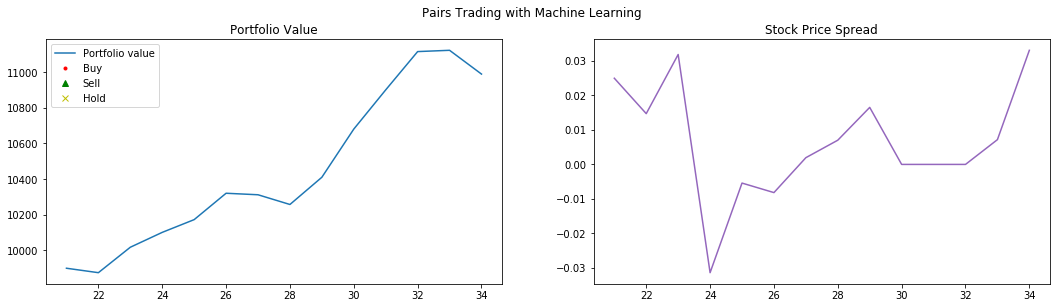

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22214717 0.22218251 0.22151902]
 [0.3236564  0.32317078 0.32271415]
 [0.3394103  0.34025842 0.33931786]
 [0.32263535 0.32105058 0.3238417 ]
 [0.32874137 0.3278767  0.3290773 ]
 [0.3361527  0.33566386 0.33731186]
 [0.3161923  0.31565896 0.3161472 ]
 [0.31972405 0.3198347  0.31971124]
 [0.33889472 0.33814478 0.33763525]
 [0.34775844 0.34775102 0.34835914]
 [0.33662048 0.33423114 0.33868268]
 [0.33302155 0.33192575 0.3338569 ]
 [0.32154518 0.32173175 0.3220069 ]
 [0.3098994  0.30976075 0.30976734]], shape=(14, 3), dtype=float32)


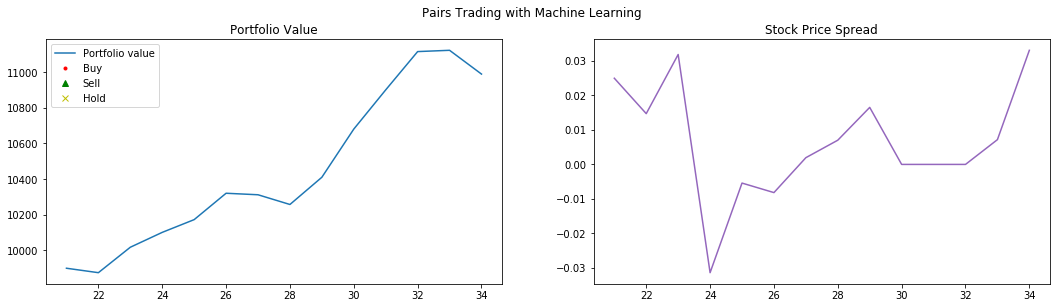

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22446054 0.22449589 0.2238324 ]
 [0.32963446 0.32914883 0.3286922 ]
 [0.34318963 0.34403774 0.34309718]
 [0.32560298 0.3240182  0.32680932]
 [0.32984433 0.32897967 0.3301803 ]
 [0.3379654  0.33747655 0.33912456]
 [0.31736097 0.31682763 0.31731588]
 [0.32341906 0.32352972 0.32340625]
 [0.34210467 0.34135473 0.3408452 ]
 [0.35039052 0.3503831  0.35099122]
 [0.33816016 0.3357708  0.34022236]
 [0.3334606  0.3323648  0.33429596]
 [0.32267717 0.32286373 0.3231389 ]
 [0.31233725 0.3121986  0.3122052 ]], shape=(14, 3), dtype=float32)


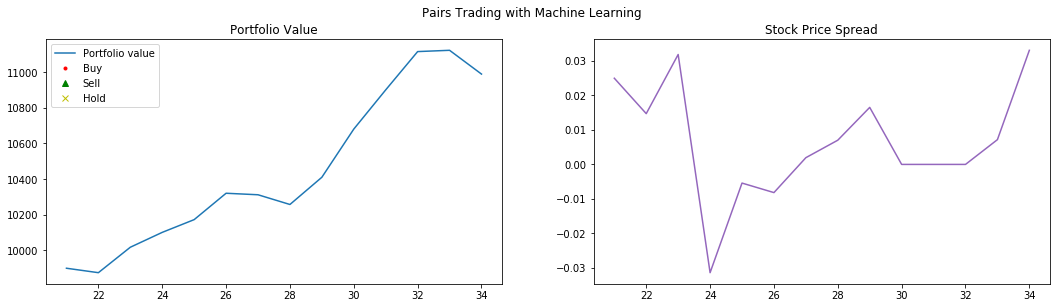

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22892801 0.22896336 0.22829987]
 [0.33129233 0.3308067  0.33035007]
 [0.34753045 0.34837857 0.347438  ]
 [0.33063248 0.32904774 0.33183882]
 [0.33272603 0.33186138 0.333062  ]
 [0.34130242 0.34081358 0.3424616 ]
 [0.32003832 0.31950498 0.31999323]
 [0.3280115  0.32812217 0.3279987 ]
 [0.34741235 0.3466624  0.34615287]
 [0.3544247  0.35441726 0.35502538]
 [0.34106597 0.33867663 0.34312817]
 [0.33626014 0.33516434 0.3370955 ]
 [0.32618508 0.32637164 0.3266468 ]
 [0.31689683 0.3167582  0.31676477]], shape=(14, 3), dtype=float32)


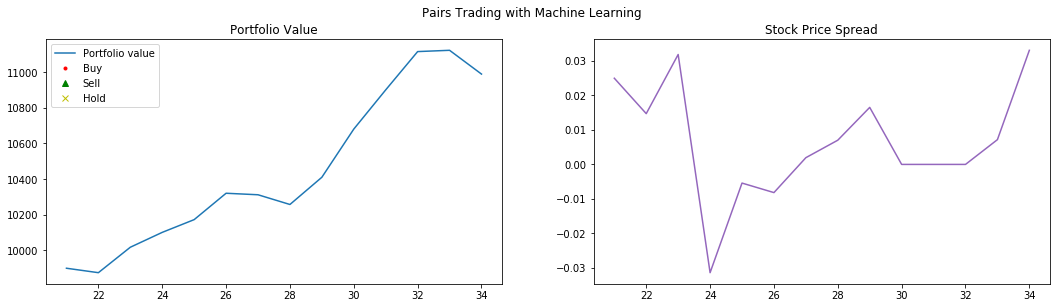

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.23179466 0.23182997 0.23116648]
 [0.33129233 0.3308067  0.33035007]
 [0.34753045 0.34837857 0.347438  ]
 [0.3334388  0.33185408 0.33464515]
 [0.3342694  0.33340475 0.33460537]
 [0.34310913 0.34262028 0.3442683 ]
 [0.32095066 0.3204173  0.32090557]
 [0.32801154 0.3281222  0.3279987 ]
 [0.348893   0.34814304 0.3476335 ]
 [0.35651574 0.3565083  0.35711643]
 [0.34212178 0.33973244 0.34418398]
 [0.33713943 0.33604363 0.3379748 ]
 [0.32825753 0.3284441  0.32871926]
 [0.3200964  0.31995776 0.31996435]], shape=(14, 3), dtype=float32)


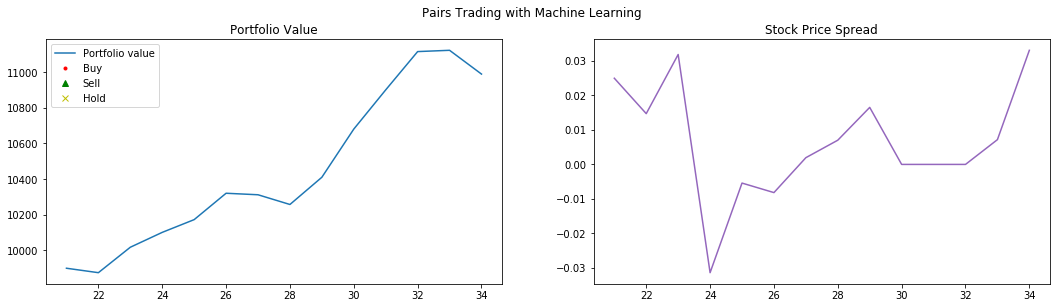

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.23237032 0.23240563 0.23174214]
 [0.33129233 0.3308067  0.33035004]
 [0.34753045 0.34837857 0.347438  ]
 [0.33402988 0.33244514 0.33523622]
 [0.3340585  0.33319384 0.33439445]
 [0.34311813 0.3426293  0.3442773 ]
 [0.3200976  0.31956425 0.3200525 ]
 [0.32801154 0.3281222  0.3279987 ]
 [0.348893   0.34814304 0.3476335 ]
 [0.35690722 0.3568998  0.3575079 ]
 [0.34162113 0.3392318  0.34368333]
 [0.33596483 0.33486903 0.3368002 ]
 [0.32831952 0.3285061  0.32878125]
 [0.32083207 0.32069343 0.32070002]], shape=(14, 3), dtype=float32)


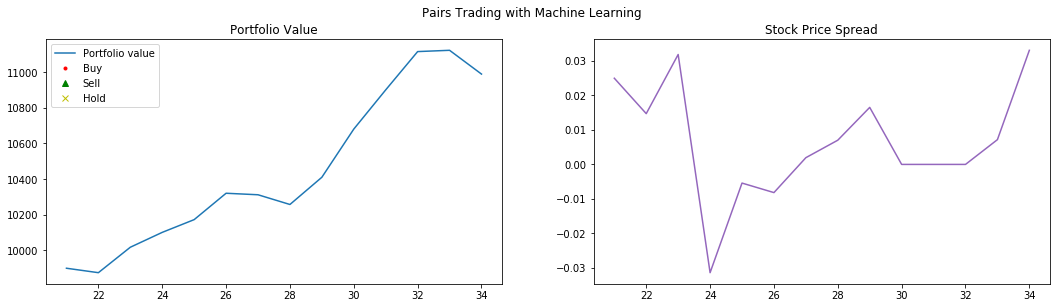

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.23105735 0.23109266 0.23042917]
 [0.33129233 0.3308067  0.33035004]
 [0.34753045 0.34837857 0.347438  ]
 [0.33261278 0.33102804 0.33381912]
 [0.33251885 0.3316542  0.3328548 ]
 [0.34152377 0.34103495 0.34268293]
 [0.31799638 0.31746304 0.31795126]
 [0.32801154 0.3281222  0.3279987 ]
 [0.348893   0.34814304 0.3476335 ]
 [0.3557093  0.3557019  0.35631   ]
 [0.33949217 0.33710283 0.34155437]
 [0.33296895 0.33187315 0.3338043 ]
 [0.3266067  0.32679328 0.32706842]
 [0.31961188 0.31947324 0.31947982]], shape=(14, 3), dtype=float32)


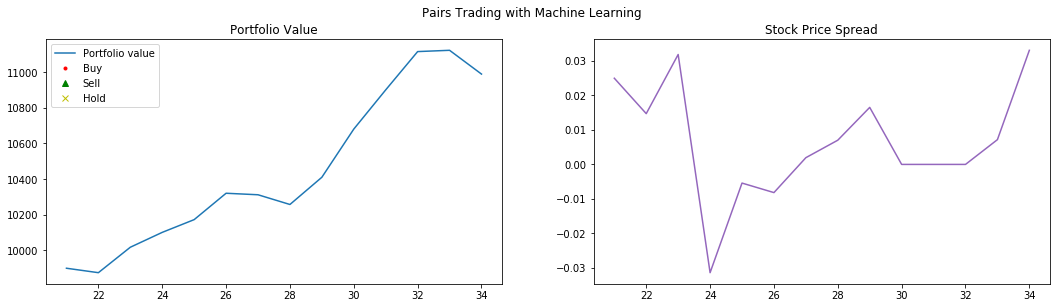

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22860658 0.2286419  0.22797841]
 [0.33129233 0.3308067  0.33035004]
 [0.34753045 0.34837857 0.347438  ]
 [0.3301143  0.32852957 0.33132064]
 [0.3302146  0.32934994 0.33055055]
 [0.33909714 0.3386083  0.34025627]
 [0.31501958 0.31448624 0.3149745 ]
 [0.32801154 0.3281222  0.3279987 ]
 [0.3484479  0.34769794 0.3471884 ]
 [0.3534221  0.35341468 0.3540228 ]
 [0.33652946 0.33414012 0.33859167]
 [0.32905075 0.32795495 0.3298861 ]
 [0.3238456  0.3240322  0.32430732]
 [0.3171496  0.31701097 0.31701756]], shape=(14, 3), dtype=float32)


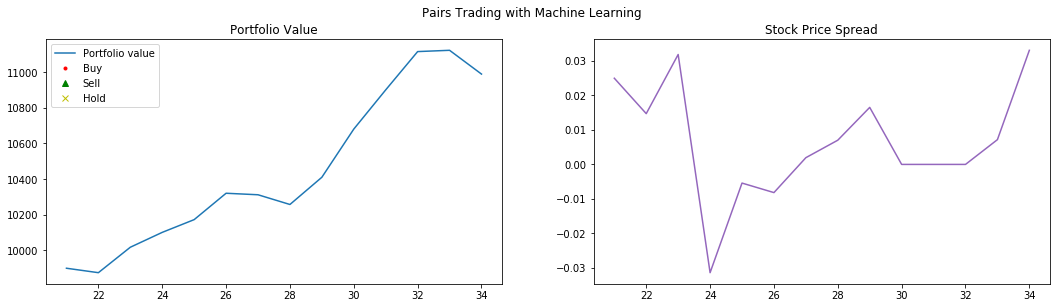

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22598635 0.22602166 0.22535817]
 [0.33129233 0.3308067  0.33035004]
 [0.34753045 0.34837857 0.347438  ]
 [0.32739937 0.32581463 0.3286057 ]
 [0.3280189  0.32715425 0.32835487]
 [0.33664057 0.33615172 0.3377997 ]
 [0.3119696  0.31143627 0.31192452]
 [0.32801154 0.3281222  0.3279987 ]
 [0.34601927 0.34526932 0.34475976]
 [0.35099745 0.35099003 0.35159814]
 [0.33348075 0.3310914  0.33554295]
 [0.32549885 0.32440305 0.3263342 ]
 [0.3210805  0.3212671  0.32154223]
 [0.31460577 0.31446713 0.31447372]], shape=(14, 3), dtype=float32)


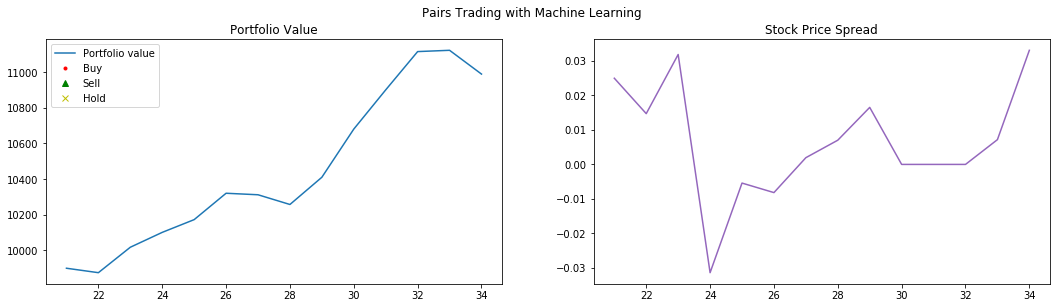

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22433338 0.22436869 0.2237052 ]
 [0.33129233 0.3308067  0.33035004]
 [0.34753045 0.34837857 0.347438  ]
 [0.32543412 0.32384938 0.32664046]
 [0.3268813  0.32601663 0.32721725]
 [0.33506957 0.33458072 0.3362287 ]
 [0.30981714 0.3092838  0.30977204]
 [0.32707822 0.32718888 0.32706538]
 [0.34456348 0.34381354 0.34330398]
 [0.34932476 0.3493173  0.3499254 ]
 [0.33130497 0.32891566 0.33336717]
 [0.32292557 0.3218298  0.32376093]
 [0.3193036  0.3194902  0.31976533]
 [0.31303552 0.31289688 0.31290346]], shape=(14, 3), dtype=float32)


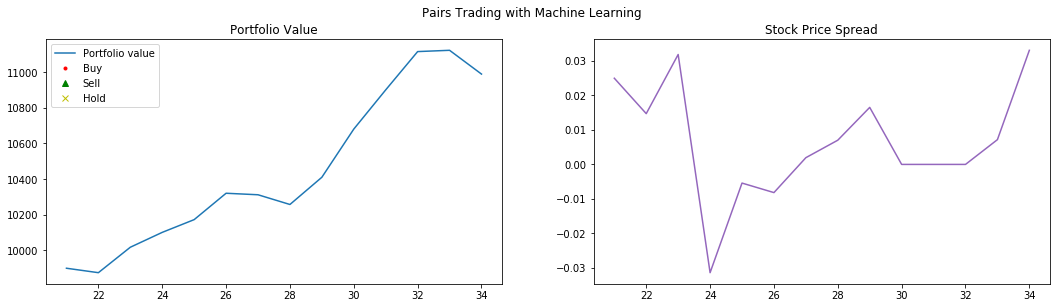

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22451828 0.2245536  0.22389011]
 [0.33129233 0.3308067  0.33035004]
 [0.34753045 0.34837857 0.347438  ]
 [0.3250904  0.32350567 0.32629675]
 [0.32729802 0.32643336 0.32763398]
 [0.33500615 0.3345173  0.33616528]
 [0.3092219  0.30868855 0.3091768 ]
 [0.32747695 0.3275876  0.3274641 ]
 [0.3449093  0.34415936 0.3436498 ]
 [0.34911755 0.3491101  0.3497182 ]
 [0.3306437  0.32825437 0.33270591]
 [0.32219112 0.32109532 0.32302648]
 [0.31917444 0.31936103 0.31963617]
 [0.31326053 0.31312189 0.31312847]], shape=(14, 3), dtype=float32)


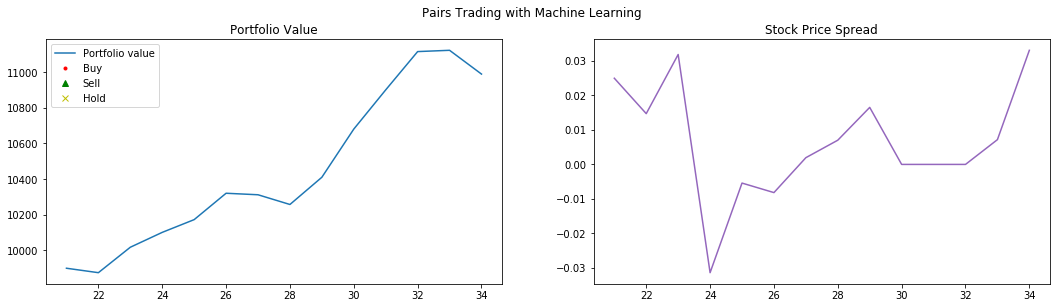

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22619662 0.22623193 0.22556844]
 [0.33129233 0.3308067  0.33035004]
 [0.34753045 0.34837857 0.34743798]
 [0.32609022 0.32450548 0.32729656]
 [0.32895017 0.3280855  0.32928613]
 [0.33627898 0.33579013 0.3374381 ]
 [0.3099023  0.30936897 0.30985722]
 [0.32801154 0.3281222  0.3279987 ]
 [0.34668016 0.34593022 0.34542066]
 [0.35029736 0.3502899  0.35089803]
 [0.331318   0.32892865 0.3333802 ]
 [0.32308105 0.32198524 0.3239164 ]
 [0.3204826  0.3206692  0.32094434]
 [0.31499308 0.31485444 0.31486103]], shape=(14, 3), dtype=float32)


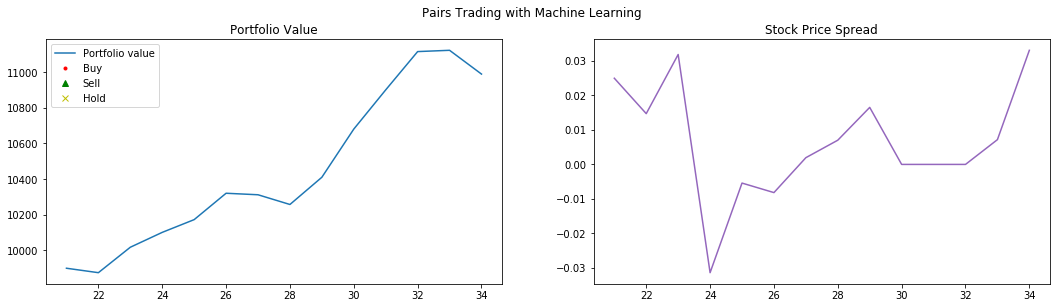

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22857693 0.22861224 0.22794876]
 [0.33129233 0.3308067  0.33035004]
 [0.34753045 0.34837857 0.34743798]
 [0.3278197  0.32623497 0.32902604]
 [0.33118778 0.33032313 0.33152375]
 [0.3383554  0.33786654 0.33951452]
 [0.31129012 0.31075677 0.31124502]
 [0.32801154 0.3281222  0.3279987 ]
 [0.348893   0.34814304 0.34763348]
 [0.35214293 0.35213548 0.3527436 ]
 [0.33265325 0.3302639  0.33471546]
 [0.32477987 0.32368407 0.32561523]
 [0.32267553 0.3228621  0.32313722]
 [0.3174297  0.31729105 0.31729764]], shape=(14, 3), dtype=float32)


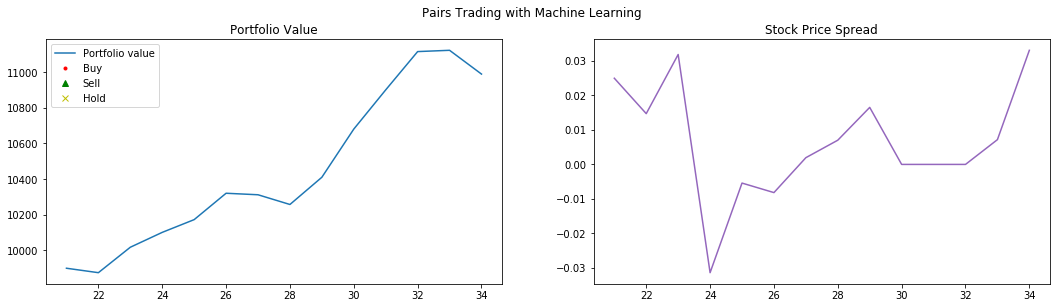

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.23057866 0.23061398 0.22995049]
 [0.33129233 0.3308067  0.33035004]
 [0.34753045 0.34837857 0.34743798]
 [0.32938638 0.32780164 0.33059272]
 [0.3331281  0.33226344 0.33346406]
 [0.34015828 0.33966944 0.34131742]
 [0.31252524 0.3119919  0.31248015]
 [0.32801154 0.3281222  0.3279987 ]
 [0.348893   0.34814304 0.34763345]
 [0.35369173 0.35368428 0.3542924 ]
 [0.33382726 0.33143792 0.33588946]
 [0.3264705  0.3253747  0.32730585]
 [0.3246494  0.32483596 0.3251111 ]
 [0.31948942 0.31935078 0.31935737]], shape=(14, 3), dtype=float32)


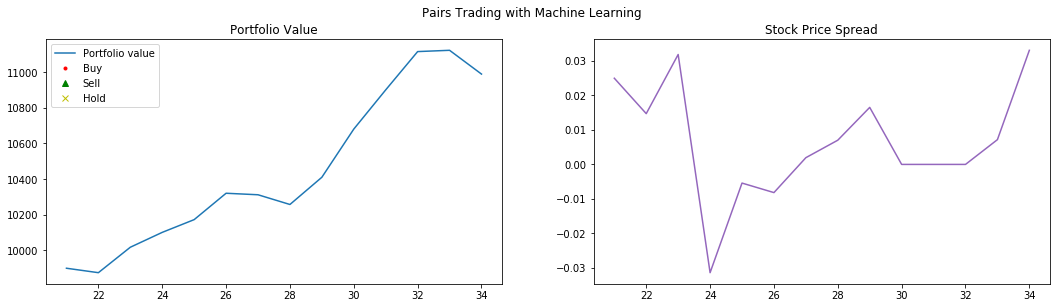

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.23165083 0.23168615 0.23102266]
 [0.33129233 0.3308067  0.33035004]
 [0.34753045 0.34837857 0.34743798]
 [0.33020285 0.3286181  0.3314092 ]
 [0.33430067 0.33343598 0.3346366 ]
 [0.3412036  0.34071475 0.34236273]
 [0.31324524 0.3127119  0.31320018]
 [0.32801154 0.3281222  0.3279987 ]
 [0.348893   0.34814304 0.34763345]
 [0.3543666  0.35435915 0.35496727]
 [0.33442828 0.33203894 0.33649048]
 [0.32765132 0.32655552 0.32848668]
 [0.32572958 0.32591614 0.32619128]
 [0.320577   0.32043833 0.32044494]], shape=(14, 3), dtype=float32)


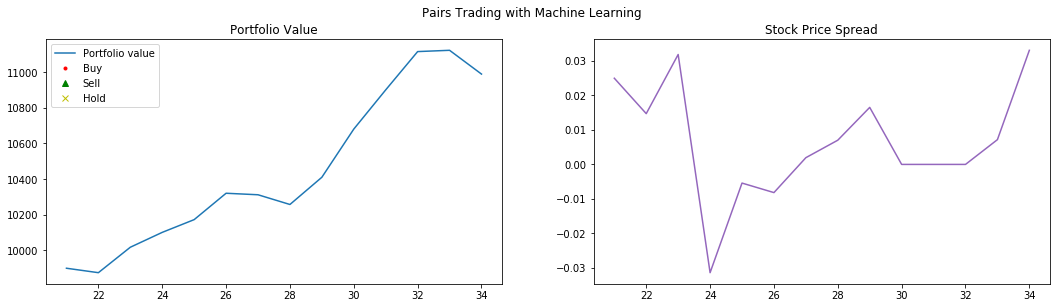

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.23151582 0.23155114 0.23088765]
 [0.33129233 0.3308067  0.33035004]
 [0.34753045 0.34837857 0.34743798]
 [0.32997265 0.32838792 0.331179  ]
 [0.33462656 0.33376187 0.3349625 ]
 [0.34124398 0.34075513 0.3424031 ]
 [0.31326696 0.31273362 0.31322187]
 [0.32801154 0.3281222  0.3279987 ]
 [0.34889302 0.34814307 0.34763348]
 [0.35396674 0.3539593  0.3545674 ]
 [0.33433673 0.3319474  0.33639893]
 [0.32810786 0.32701206 0.32894322]
 [0.32571894 0.3259055  0.32618064]
 [0.32049406 0.32035542 0.320362  ]], shape=(14, 3), dtype=float32)


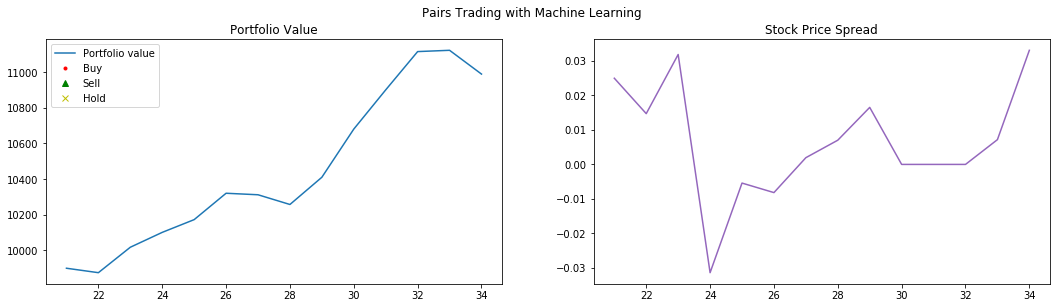

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.23040476 0.23044008 0.22977659]
 [0.33129233 0.3308067  0.33035004]
 [0.34753045 0.34837857 0.34743798]
 [0.32885104 0.3272663  0.33005738]
 [0.334244   0.33337933 0.33457994]
 [0.34042856 0.3399397  0.3415877 ]
 [0.31265125 0.3121179  0.31260616]
 [0.32801154 0.3281222  0.3279987 ]
 [0.34889302 0.34814307 0.34763348]
 [0.35264057 0.35263312 0.35324124]
 [0.33359104 0.3312017  0.33565325]
 [0.32790703 0.32681122 0.32874238]
 [0.32476017 0.32494673 0.32522187]
 [0.31943431 0.31929564 0.31930226]], shape=(14, 3), dtype=float32)


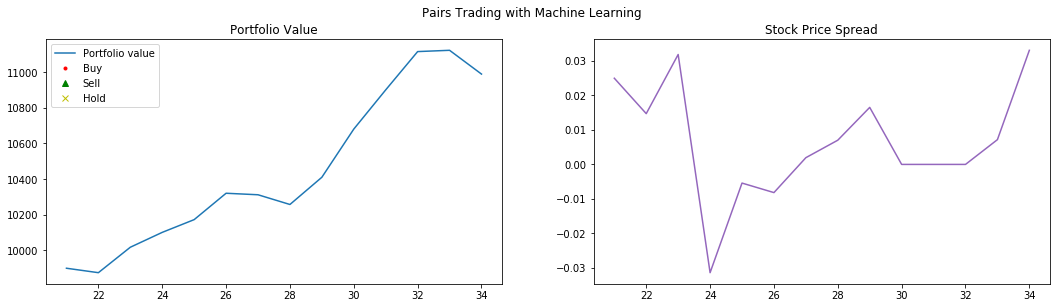

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22868136 0.22871667 0.22805318]
 [0.3312923  0.3308067  0.33035   ]
 [0.34753045 0.34837857 0.34743798]
 [0.32722765 0.3256429  0.328434  ]
 [0.33333525 0.33247057 0.33367118]
 [0.33903116 0.3385423  0.3401903 ]
 [0.3116335  0.31110016 0.3115884 ]
 [0.32801154 0.3281222  0.3279987 ]
 [0.34889302 0.34814307 0.34763348]
 [0.3508458  0.35083836 0.35144648]
 [0.332442   0.33005264 0.3345042 ]
 [0.32726544 0.32616964 0.3281008 ]
 [0.32323727 0.32342383 0.32369897]
 [0.31776926 0.3176306  0.3176372 ]], shape=(14, 3), dtype=float32)


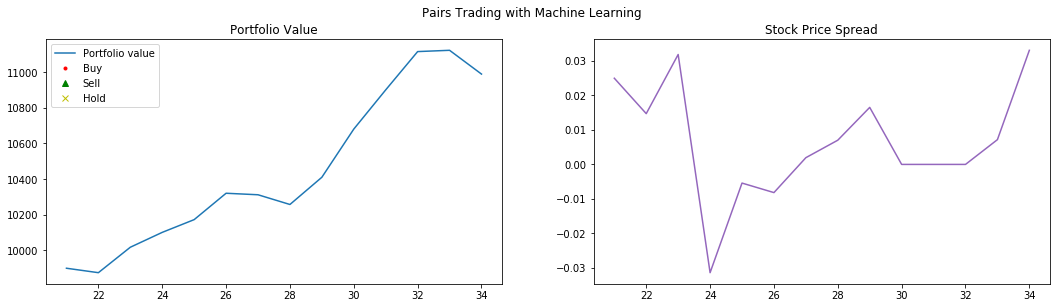

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.2269052  0.22694051 0.22627702]
 [0.33129233 0.33080673 0.33035004]
 [0.34753048 0.34837857 0.34743798]
 [0.32559106 0.32400632 0.3267974 ]
 [0.3323117  0.331447   0.33264762]
 [0.33751002 0.33702117 0.33866915]
 [0.31053704 0.3100037  0.31049195]
 [0.32801154 0.3281222  0.3279987 ]
 [0.34729484 0.3465449  0.3460353 ]
 [0.34901062 0.34900317 0.34961128]
 [0.3313276  0.32893825 0.3333898 ]
 [0.3265711  0.32547534 0.32740647]
 [0.32178327 0.32196984 0.32224497]
 [0.31601077 0.3158721  0.31587872]], shape=(14, 3), dtype=float32)


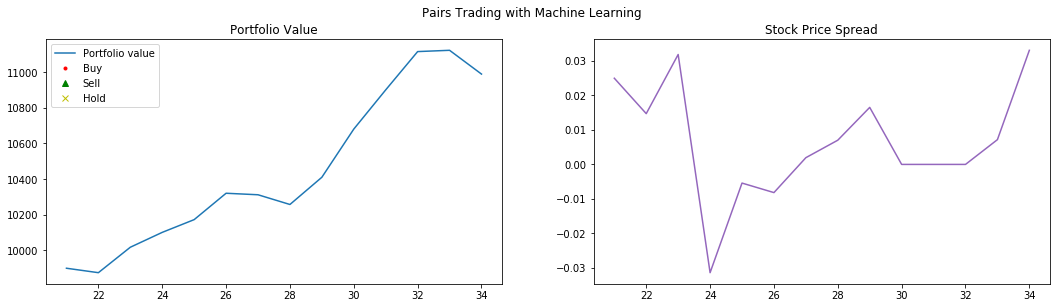

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22586034 0.22589566 0.22523217]
 [0.33129233 0.33080673 0.33035004]
 [0.34753048 0.34837857 0.34743798]
 [0.3246647  0.32307997 0.32587105]
 [0.33181688 0.3309522  0.3321528 ]
 [0.3366793  0.33619046 0.33783844]
 [0.31002086 0.30948752 0.30997577]
 [0.32801154 0.3281222  0.3279987 ]
 [0.34624407 0.34549412 0.34498453]
 [0.3479106  0.34790316 0.34851128]
 [0.33078757 0.32839823 0.33284977]
 [0.32645795 0.32536215 0.3272933 ]
 [0.32107046 0.32125703 0.32153216]
 [0.31497517 0.3148365  0.31484312]], shape=(14, 3), dtype=float32)


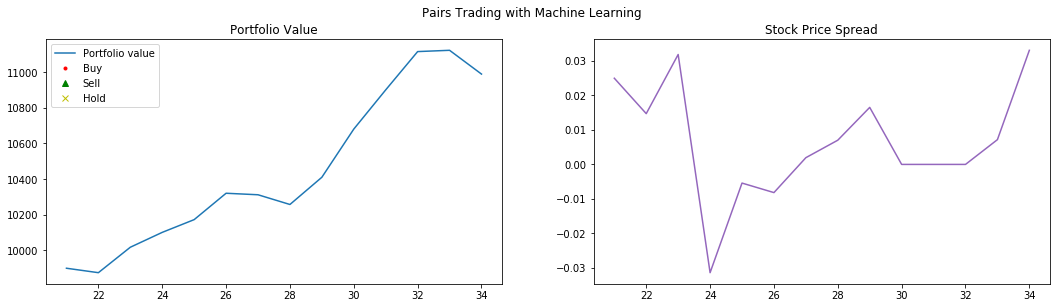

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22579958 0.22583489 0.2251714 ]
 [0.33129233 0.33080673 0.33035004]
 [0.34753048 0.34837857 0.34743798]
 [0.3246758  0.32309106 0.32588214]
 [0.33206818 0.3312035  0.3324041 ]
 [0.33675548 0.33626664 0.33791462]
 [0.31029272 0.30975938 0.31024766]
 [0.32801154 0.3281222  0.3279987 ]
 [0.34617236 0.34542242 0.34491283]
 [0.34773085 0.3477234  0.3483315 ]
 [0.33103752 0.32864818 0.33309972]
 [0.32714474 0.32604894 0.3279801 ]
 [0.32120374 0.3213903  0.32166544]
 [0.31491873 0.31478006 0.31478667]], shape=(14, 3), dtype=float32)


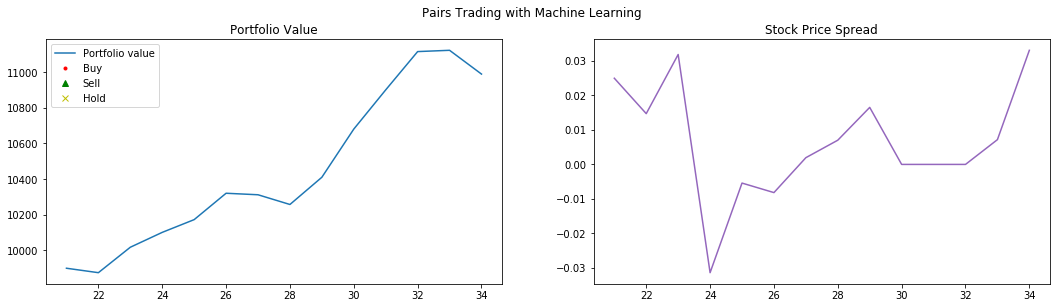

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22656704 0.22660236 0.22593887]
 [0.33129233 0.33080673 0.33035004]
 [0.34753048 0.34837857 0.34743798]
 [0.32548678 0.32390204 0.32669312]
 [0.33292842 0.33206373 0.33326435]
 [0.3375405  0.33705166 0.33869964]
 [0.3112097  0.31067637 0.31116462]
 [0.32801154 0.3281222  0.3279987 ]
 [0.34692678 0.34617683 0.34566724]
 [0.34829426 0.34828678 0.3488949 ]
 [0.33195573 0.3295664  0.33401793]
 [0.3285184  0.3274226  0.32935375]
 [0.32203332 0.32221988 0.322495  ]
 [0.3156739  0.31553525 0.31554186]], shape=(14, 3), dtype=float32)


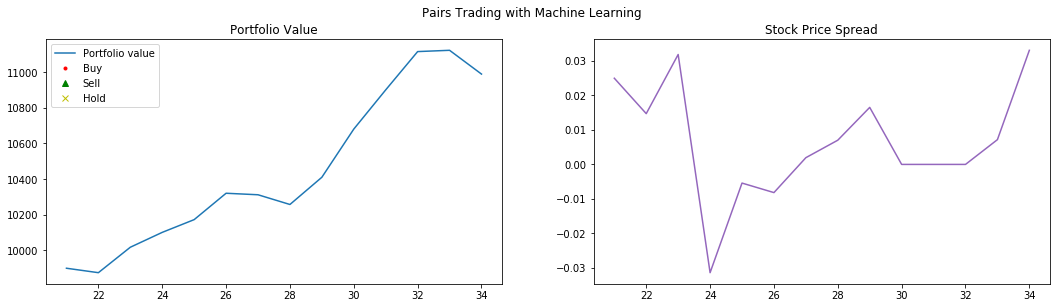

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22777297 0.22780828 0.2271448 ]
 [0.33129233 0.33080673 0.33035004]
 [0.34753048 0.34837857 0.34743798]
 [0.3266886  0.32510385 0.32789493]
 [0.33401802 0.33315334 0.33435395]
 [0.33865947 0.33817062 0.3398186 ]
 [0.3124745  0.31194115 0.3124294 ]
 [0.32801154 0.3281222  0.3279987 ]
 [0.3481151  0.34736514 0.34685555]
 [0.3492525  0.349245   0.34985313]
 [0.3331921  0.33080277 0.3352543 ]
 [0.33022174 0.32912594 0.3310571 ]
 [0.32320863 0.3233952  0.32367033]
 [0.31687102 0.31673235 0.31673896]], shape=(14, 3), dtype=float32)


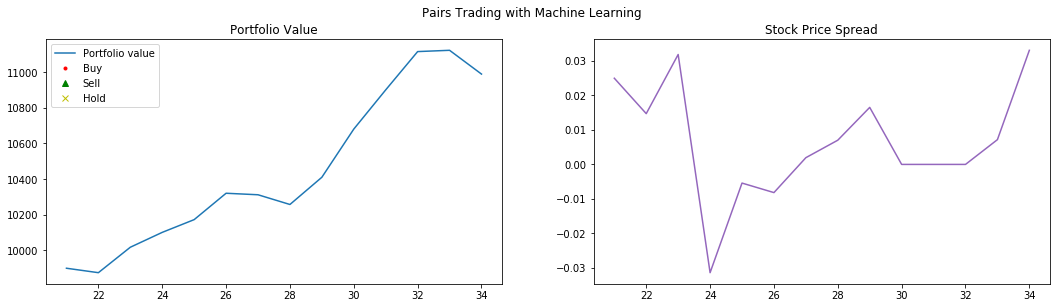

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22892761 0.22896293 0.22829944]
 [0.33129233 0.33080673 0.33035004]
 [0.34753048 0.34837857 0.34743798]
 [0.32780406 0.32621932 0.3290104 ]
 [0.3349712  0.3341065  0.33530712]
 [0.33971587 0.33922702 0.340875  ]
 [0.31364894 0.3131156  0.31360385]
 [0.32801157 0.3281222  0.3279987 ]
 [0.34889302 0.34814307 0.34763348]
 [0.35016763 0.35016015 0.35076827]
 [0.33432648 0.33193713 0.33638868]
 [0.33177745 0.33068165 0.3326128 ]
 [0.3243009  0.32448745 0.32476258]
 [0.31802374 0.31788507 0.3178917 ]], shape=(14, 3), dtype=float32)


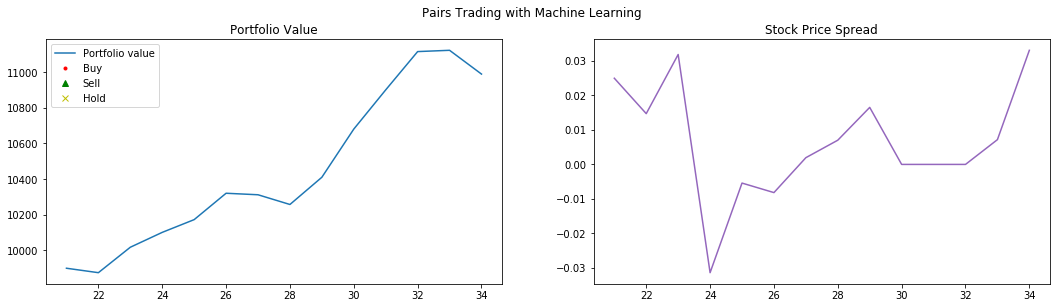

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22937539 0.22941071 0.22874722]
 [0.33129233 0.33080673 0.33035004]
 [0.34753048 0.34837857 0.34743798]
 [0.32823762 0.32665288 0.32944396]
 [0.33532575 0.33446106 0.33566168]
 [0.3401485  0.33965966 0.34130764]
 [0.3141951  0.31366175 0.31415   ]
 [0.32801157 0.3281222  0.3279987 ]
 [0.34889302 0.34814307 0.34763348]
 [0.3504822  0.35047472 0.35108283]
 [0.3348424  0.33245307 0.33690462]
 [0.33263597 0.33154017 0.33347133]
 [0.32470027 0.32488683 0.32516196]
 [0.31847224 0.31833357 0.31834018]], shape=(14, 3), dtype=float32)


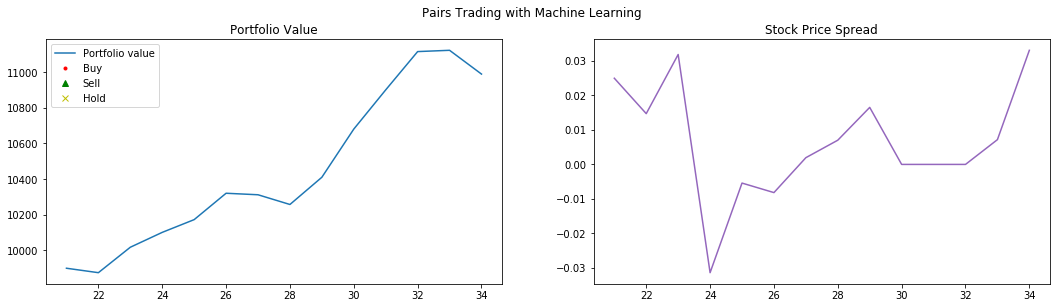

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22902444 0.22905976 0.22839627]
 [0.33129233 0.33080673 0.33035004]
 [0.34753048 0.34837857 0.34743798]
 [0.32792222 0.32633752 0.32912856]
 [0.33496615 0.33410147 0.33530208]
 [0.33982283 0.33933398 0.34098196]
 [0.3140062  0.31347287 0.31396112]
 [0.32801157 0.3281222  0.3279987 ]
 [0.34889302 0.34814307 0.34763348]
 [0.35006958 0.3500621  0.35067022]
 [0.33462757 0.33223823 0.33668977]
 [0.33269495 0.33159912 0.33353028]
 [0.32433242 0.32451898 0.3247941 ]
 [0.3181277  0.31798902 0.31799564]], shape=(14, 3), dtype=float32)


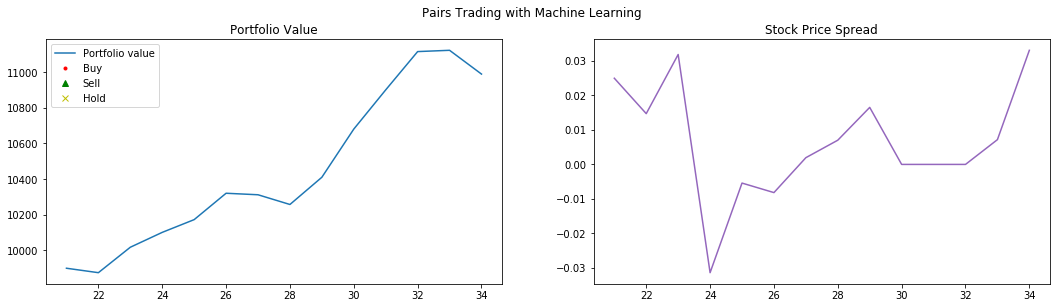

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22804657 0.22808188 0.2274184 ]
 [0.33129233 0.33080673 0.33035004]
 [0.34753048 0.34837857 0.34743798]
 [0.32701874 0.325434   0.32822508]
 [0.33407095 0.33320627 0.33440688]
 [0.3388859  0.33839706 0.34004503]
 [0.3132372  0.31270385 0.3131921 ]
 [0.32801157 0.3281222  0.3279987 ]
 [0.3483153  0.34756535 0.34705573]
 [0.34908527 0.34907782 0.3496859 ]
 [0.33383283 0.3314435  0.33589503]
 [0.33211654 0.3310207  0.33295187]
 [0.32335263 0.3235392  0.32381433]
 [0.31713945 0.31700078 0.3170074 ]], shape=(14, 3), dtype=float32)


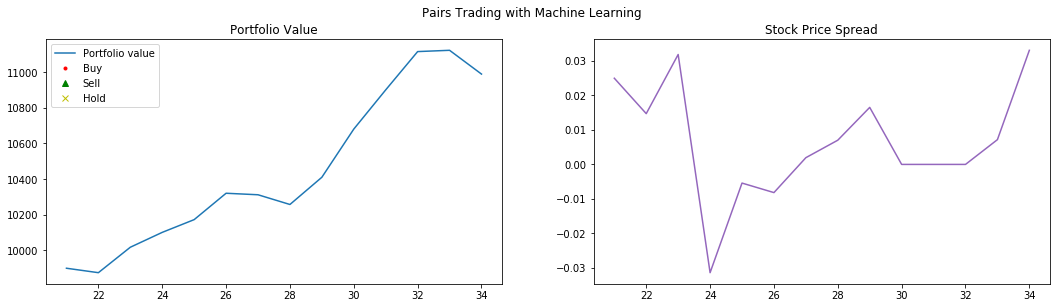

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22704856 0.22708388 0.22642039]
 [0.33129233 0.33080673 0.33035004]
 [0.34753048 0.34837857 0.34743798]
 [0.3260526  0.32446787 0.32725894]
 [0.33314914 0.33228445 0.33348507]
 [0.33791658 0.33742774 0.3390757 ]
 [0.31236646 0.3118331  0.31232136]
 [0.32801157 0.3281222  0.3279987 ]
 [0.34736356 0.34661362 0.346104  ]
 [0.34806314 0.34805566 0.34866378]
 [0.3329622  0.33057284 0.3350244 ]
 [0.33139858 0.33030275 0.3322339 ]
 [0.3222982  0.32248476 0.3227599 ]
 [0.31614426 0.3160056  0.3160122 ]], shape=(14, 3), dtype=float32)


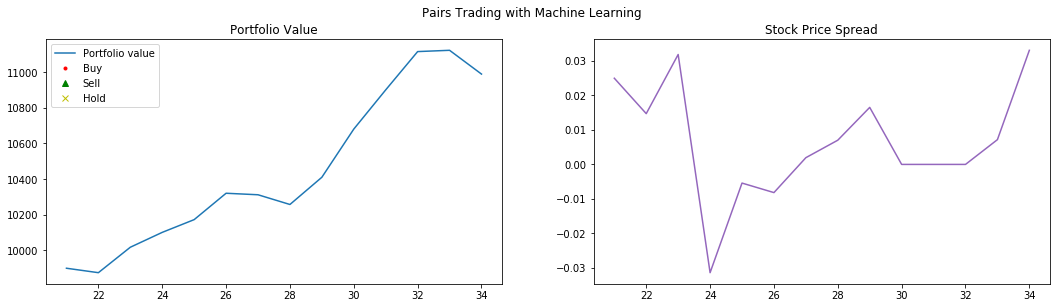

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22640401 0.22643933 0.22577584]
 [0.33129233 0.33080673 0.33035004]
 [0.34753048 0.34837857 0.34743798]
 [0.32537615 0.3237914  0.3265825 ]
 [0.33253157 0.3316669  0.3328675 ]
 [0.33728114 0.3367923  0.33844027]
 [0.31176513 0.3112318  0.31172004]
 [0.32801157 0.3281222  0.3279987 ]
 [0.34675702 0.34600708 0.34549746]
 [0.34739834 0.34739086 0.34799898]
 [0.33234072 0.32995138 0.33440292]
 [0.33087832 0.3297825  0.33171365]
 [0.3215121  0.32169864 0.32197377]
 [0.31551388 0.3153752  0.31538182]], shape=(14, 3), dtype=float32)


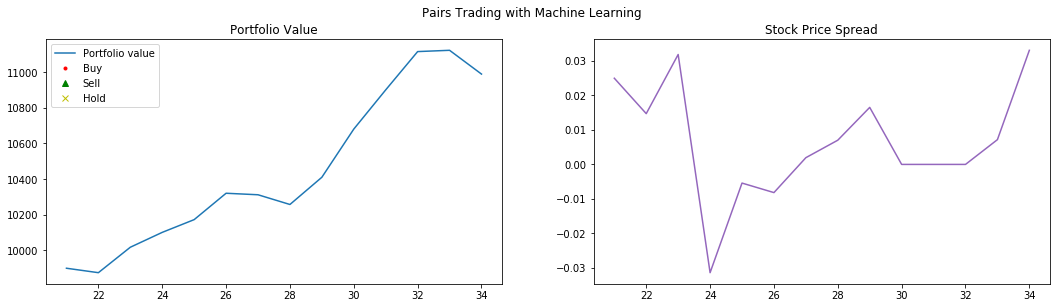

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22636157 0.22639689 0.2257334 ]
 [0.33129233 0.33080673 0.33035004]
 [0.34753048 0.34837857 0.34743798]
 [0.32521644 0.3236317  0.32642278]
 [0.33235595 0.33149126 0.33269188]
 [0.3371899  0.33670104 0.338349  ]
 [0.31163138 0.31109804 0.3115863 ]
 [0.32801157 0.3281222  0.3279987 ]
 [0.34674275 0.34599277 0.34548318]
 [0.3472439  0.34723642 0.34784454]
 [0.332131   0.32974166 0.3341932 ]
 [0.33078465 0.32968882 0.33161998]
 [0.32121485 0.3214014  0.32167652]
 [0.31549293 0.31535426 0.31536087]], shape=(14, 3), dtype=float32)


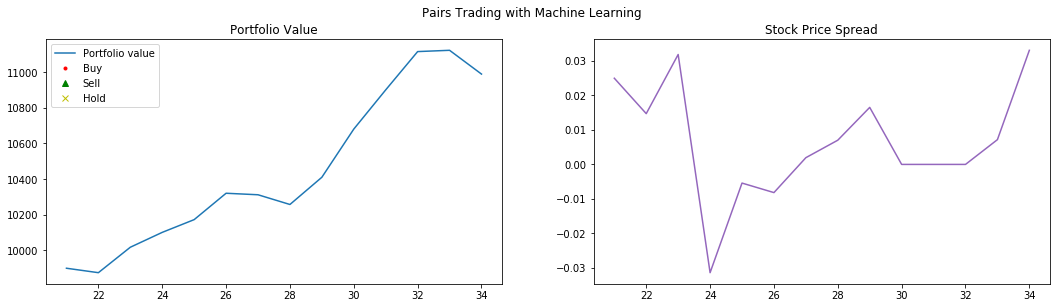

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22693916 0.22697447 0.22631098]
 [0.33129233 0.33080673 0.33035004]
 [0.34753048 0.34837857 0.34743798]
 [0.32557562 0.32399088 0.32678196]
 [0.33259824 0.33173355 0.33293417]
 [0.3376606  0.33717173 0.3388197 ]
 [0.31193516 0.3114018  0.31189007]
 [0.32801157 0.3281222  0.3279987 ]
 [0.34735143 0.34660146 0.34609187]
 [0.34762833 0.34762084 0.34822896]
 [0.33239403 0.3300047  0.33445624]
 [0.33114478 0.33004895 0.3319801 ]
 [0.3214583  0.32164484 0.32191998]
 [0.31607863 0.31593996 0.31594658]], shape=(14, 3), dtype=float32)


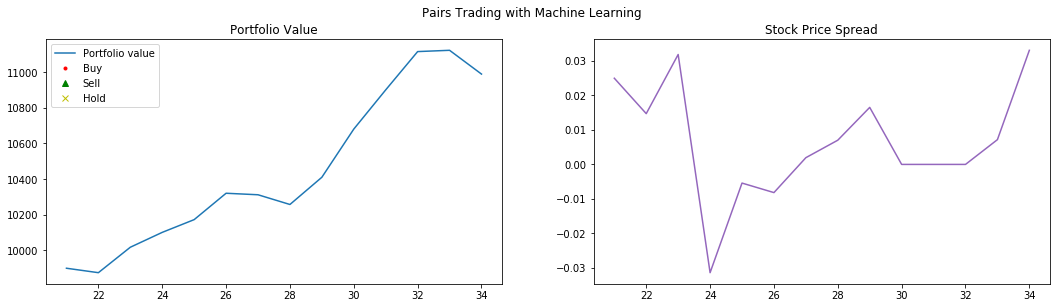

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22785139 0.2278867  0.22722322]
 [0.33129233 0.33080673 0.33035004]
 [0.34753048 0.34837857 0.34743798]
 [0.32624778 0.32466304 0.32745412]
 [0.33314398 0.3322793  0.3334799 ]
 [0.33840758 0.3379187  0.33956668]
 [0.31252047 0.31198713 0.31247538]
 [0.32801157 0.3281222  0.3279987 ]
 [0.34834874 0.34759876 0.34708917]
 [0.34843063 0.34842315 0.34903127]
 [0.33294246 0.3305531  0.33500466]
 [0.33175784 0.330662   0.33259317]
 [0.32207704 0.32226357 0.3225387 ]
 [0.31701237 0.3168737  0.31688032]], shape=(14, 3), dtype=float32)


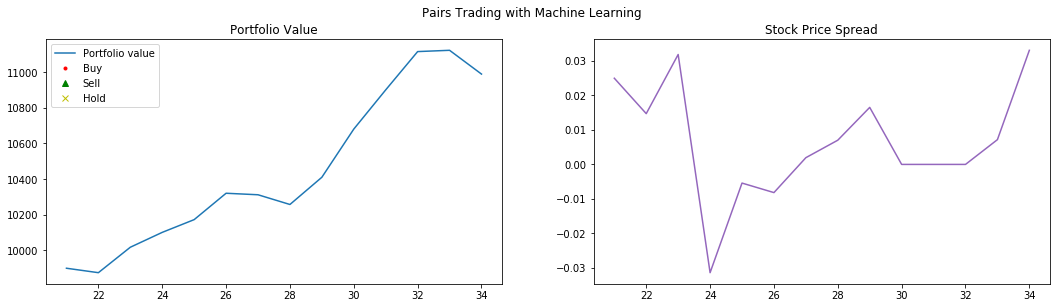

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22881505 0.22885036 0.22818688]
 [0.33129233 0.33080673 0.33035004]
 [0.34753048 0.34837857 0.34743798]
 [0.32694447 0.32535973 0.3281508 ]
 [0.3337117  0.33284703 0.33404765]
 [0.33917168 0.3386828  0.34033078]
 [0.31314984 0.3126165  0.31310475]
 [0.32801157 0.3281222  0.3279987 ]
 [0.34889302 0.34814304 0.34763345]
 [0.34927016 0.34926268 0.3498708 ]
 [0.3334892  0.33109987 0.3355514 ]
 [0.33234426 0.33124843 0.3331796 ]
 [0.32270938 0.3228959  0.32317105]
 [0.3179786  0.31783992 0.31784654]], shape=(14, 3), dtype=float32)


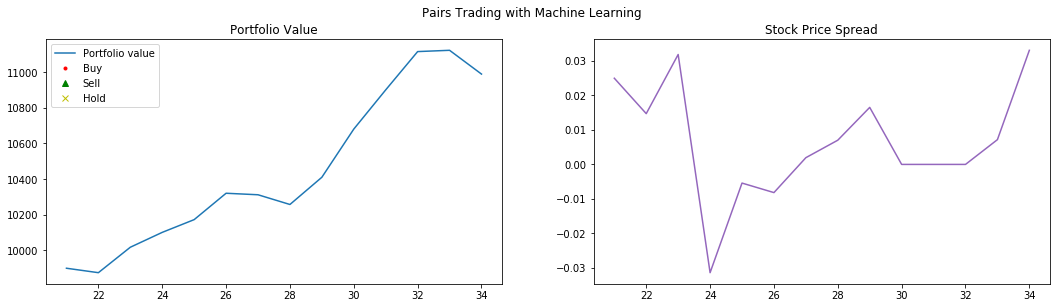

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22924152 0.22927684 0.22861335]
 [0.33129233 0.33080673 0.33035004]
 [0.34753048 0.34837857 0.34743798]
 [0.32716653 0.3255818  0.32837287]
 [0.33388644 0.33302176 0.33422238]
 [0.3394676  0.33897874 0.34062672]
 [0.31334502 0.31281167 0.31329992]
 [0.32801157 0.3281222  0.3279987 ]
 [0.3488929  0.34814292 0.34763333]
 [0.34961432 0.34960687 0.35021496]
 [0.33358777 0.33119842 0.33564997]
 [0.33247918 0.33138335 0.3333145 ]
 [0.32284325 0.3230298  0.32330492]
 [0.3184073  0.3182686  0.3182752 ]], shape=(14, 3), dtype=float32)


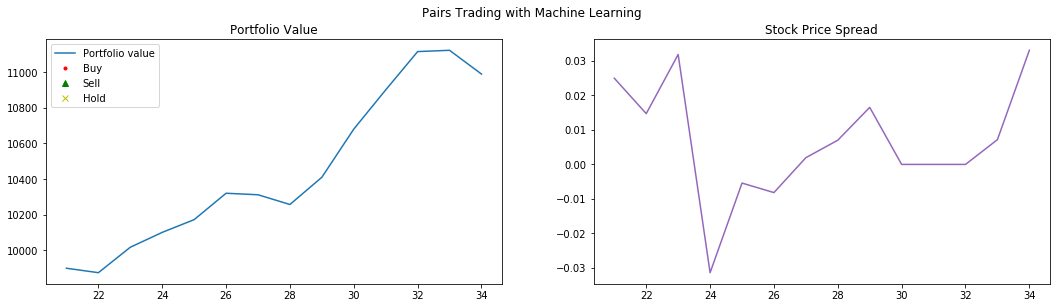

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22908212 0.22911744 0.22845395]
 [0.33129233 0.33080673 0.33035004]
 [0.34753048 0.34837857 0.34743798]
 [0.32686898 0.32528424 0.32807532]
 [0.33361608 0.3327514  0.333952  ]
 [0.33924168 0.3387528  0.3404008 ]
 [0.31306484 0.3125315  0.31301975]
 [0.32801157 0.3281222  0.3279987 ]
 [0.34889302 0.34814304 0.34763345]
 [0.34939024 0.34938276 0.34999087]
 [0.3332201  0.33083075 0.3352823 ]
 [0.3321203  0.33102447 0.33295563]
 [0.32239464 0.32258117 0.3228563 ]
 [0.31822103 0.31808236 0.31808898]], shape=(14, 3), dtype=float32)


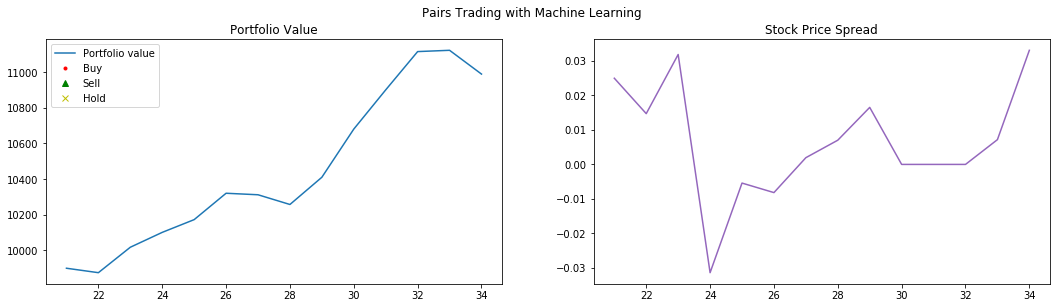

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.2284663  0.22850162 0.22783816]
 [0.33129233 0.33080673 0.33035004]
 [0.34753048 0.34837857 0.34743798]
 [0.32620275 0.324618   0.3274091 ]
 [0.3330479  0.3321832  0.33338383]
 [0.3386465  0.33815762 0.3398056 ]
 [0.31242773 0.3118944  0.31238264]
 [0.32801157 0.3281222  0.3279987 ]
 [0.34889305 0.34814307 0.34763345]
 [0.34875882 0.34875134 0.34935945]
 [0.33251977 0.3301304  0.33458197]
 [0.3314204  0.33032456 0.33225572]
 [0.32163146 0.321818   0.32209313]
 [0.31760383 0.3174652  0.3174718 ]], shape=(14, 3), dtype=float32)


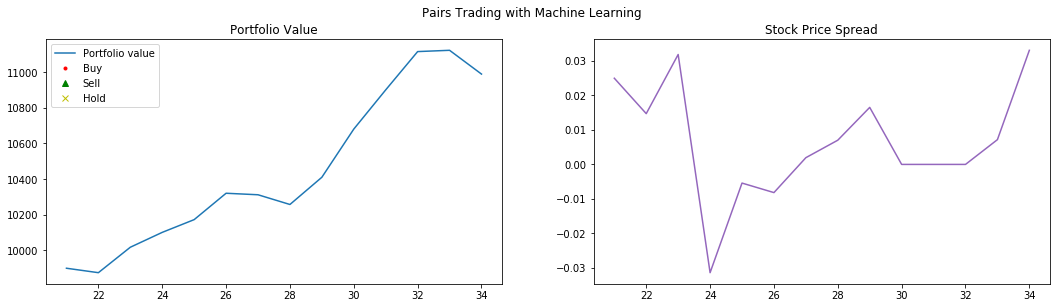

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22769654 0.22773185 0.2270684 ]
 [0.33129233 0.33080673 0.33035004]
 [0.34753048 0.34837857 0.34743798]
 [0.32542908 0.32384437 0.32663542]
 [0.33238876 0.33152407 0.3327247 ]
 [0.3379646  0.33747572 0.3391237 ]
 [0.31168678 0.31115344 0.3116417 ]
 [0.32801157 0.3281222  0.3279987 ]
 [0.3483347  0.34758472 0.3470751 ]
 [0.34797966 0.34797218 0.3485803 ]
 [0.33176804 0.3293787  0.33383024]
 [0.33060732 0.3295115  0.33144265]
 [0.32086894 0.32105547 0.3213306 ]
 [0.31684762 0.31670892 0.31671554]], shape=(14, 3), dtype=float32)


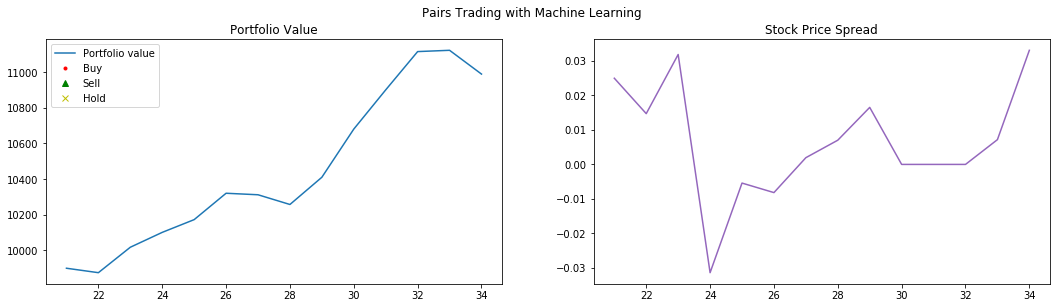

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.2274212  0.22745651 0.22679305]
 [0.33129233 0.33080673 0.33035   ]
 [0.34753045 0.34837854 0.34743795]
 [0.32509884 0.3235141  0.32630518]
 [0.3320853  0.33122063 0.33242124]
 [0.33772096 0.33723208 0.33888006]
 [0.3113675  0.31083417 0.31132242]
 [0.32801157 0.3281222  0.3279987 ]
 [0.34809658 0.3473466  0.34683698]
 [0.34765586 0.34764838 0.3482565 ]
 [0.33146003 0.3290707  0.33352223]
 [0.3302229  0.32912707 0.33105823]
 [0.32059434 0.32078087 0.321056  ]
 [0.31657976 0.3164411  0.3164477 ]], shape=(14, 3), dtype=float32)


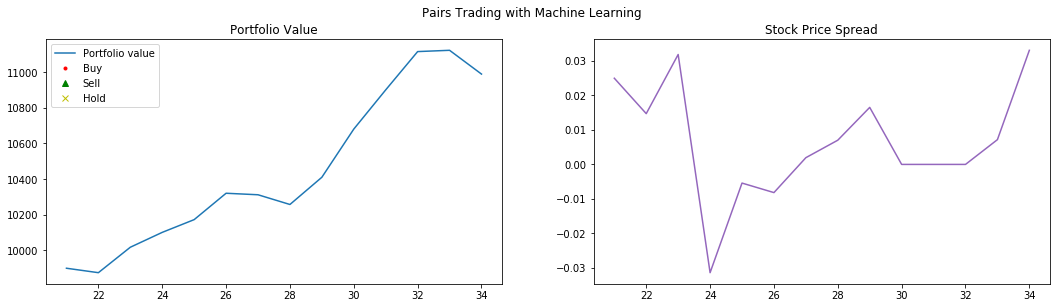

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22774243 0.22777775 0.22711429]
 [0.33129233 0.33080673 0.33035   ]
 [0.34753045 0.34837854 0.34743795]
 [0.3253196  0.32373485 0.32652593]
 [0.33223683 0.33137214 0.33257276]
 [0.33803013 0.33754125 0.33918923]
 [0.31158692 0.31105357 0.31154183]
 [0.32801157 0.3281222  0.3279987 ]
 [0.3484392  0.3476892  0.3471796 ]
 [0.34787098 0.3478635  0.3484716 ]
 [0.3316776  0.32928824 0.3337398 ]
 [0.33036983 0.329274   0.33120513]
 [0.32087636 0.32106286 0.321338  ]
 [0.31690085 0.31676218 0.3167688 ]], shape=(14, 3), dtype=float32)


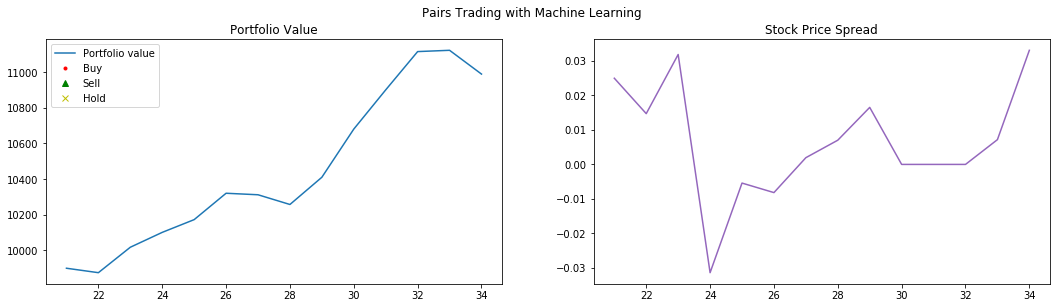

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22848183 0.22851714 0.22785369]
 [0.33129233 0.33080673 0.33035   ]
 [0.34753045 0.34837854 0.34743795]
 [0.32592064 0.3243359  0.32712698]
 [0.33271927 0.33185458 0.3330552 ]
 [0.33873802 0.33824915 0.33989713]
 [0.31219316 0.3116598  0.31214806]
 [0.32801157 0.3281222  0.3279987 ]
 [0.34889305 0.34814307 0.34763345]
 [0.34845343 0.34844595 0.34905407]
 [0.3322636  0.32987425 0.3343258 ]
 [0.33089086 0.32979503 0.3317262 ]
 [0.3215959  0.32178244 0.32205757]
 [0.31763476 0.3174961  0.3175027 ]], shape=(14, 3), dtype=float32)


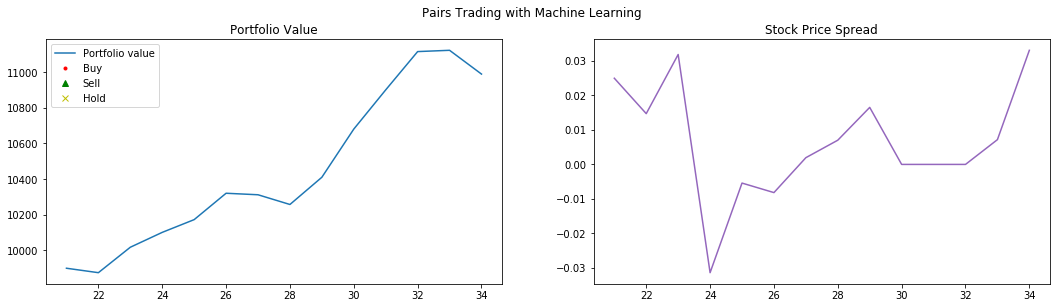

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22898641 0.22902173 0.22835827]
 [0.33129233 0.33080673 0.33035   ]
 [0.34753045 0.34837854 0.34743795]
 [0.32634714 0.3247624  0.32755348]
 [0.3331044  0.33223972 0.33344033]
 [0.3392497  0.33876082 0.3404088 ]
 [0.31267542 0.31214207 0.31263033]
 [0.32801154 0.32812217 0.32799867]
 [0.34889305 0.34814307 0.34763345]
 [0.34885228 0.3488448  0.3494529 ]
 [0.33271983 0.3303305  0.33478203]
 [0.3313007  0.33020487 0.33213603]
 [0.32209206 0.3222786  0.32255372]
 [0.31813386 0.3179952  0.3180018 ]], shape=(14, 3), dtype=float32)


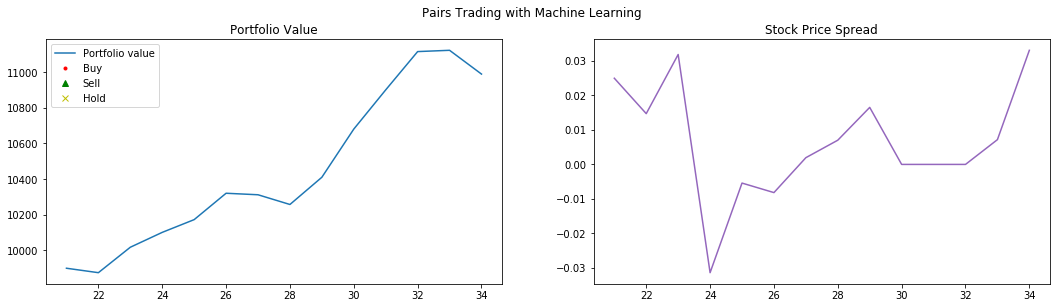

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22908005 0.22911537 0.22845191]
 [0.33129233 0.33080673 0.33035   ]
 [0.34753045 0.34837854 0.34743795]
 [0.32641587 0.32483113 0.3276222 ]
 [0.33316332 0.33229864 0.33349925]
 [0.33933768 0.3388488  0.34049678]
 [0.31285715 0.3123238  0.31281206]
 [0.32801154 0.32812217 0.32799867]
 [0.34889305 0.34814307 0.34763345]
 [0.34886977 0.3488623  0.3494704 ]
 [0.33286652 0.33047718 0.33492872]
 [0.33142707 0.33033124 0.3322624 ]
 [0.32216567 0.3223522  0.32262734]
 [0.31822398 0.3180853  0.31809193]], shape=(14, 3), dtype=float32)


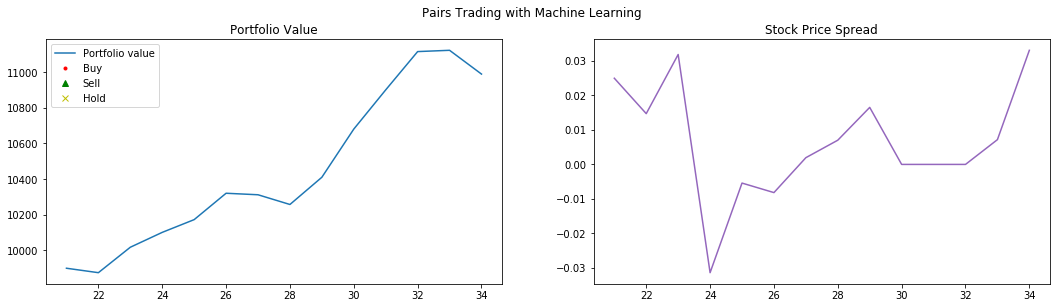

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22874075 0.22877607 0.22811261]
 [0.33129233 0.33080673 0.33035   ]
 [0.34753045 0.34837854 0.34743795]
 [0.32610285 0.3245181  0.3273092 ]
 [0.3328636  0.3319989  0.33319953]
 [0.33900088 0.338512   0.34015995]
 [0.31271857 0.31218523 0.31267348]
 [0.32801154 0.32812217 0.32799867]
 [0.34889305 0.34814307 0.34763345]
 [0.34847832 0.34847084 0.34907895]
 [0.3327084  0.33031905 0.3347706 ]
 [0.3312456  0.33014977 0.33208093]
 [0.32181686 0.3220034  0.32227853]
 [0.31788713 0.31774846 0.31775507]], shape=(14, 3), dtype=float32)


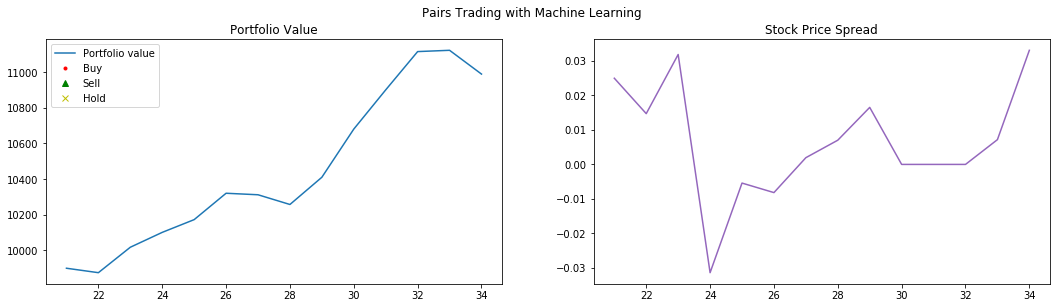

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22816259 0.2281979  0.22753444]
 [0.33129233 0.33080673 0.33035   ]
 [0.34753045 0.34837854 0.34743795]
 [0.32558134 0.3239966  0.32678768]
 [0.3323744  0.3315097  0.33271033]
 [0.33841783 0.33792895 0.33957693]
 [0.31240755 0.3118742  0.31236246]
 [0.32801154 0.32812217 0.32799867]
 [0.34889305 0.34814307 0.34763345]
 [0.3478416  0.3478341  0.34844223]
 [0.33238876 0.32999942 0.33445096]
 [0.33089638 0.32980055 0.3317317 ]
 [0.32121906 0.3214056  0.32168072]
 [0.31731197 0.3171733  0.31717992]], shape=(14, 3), dtype=float32)


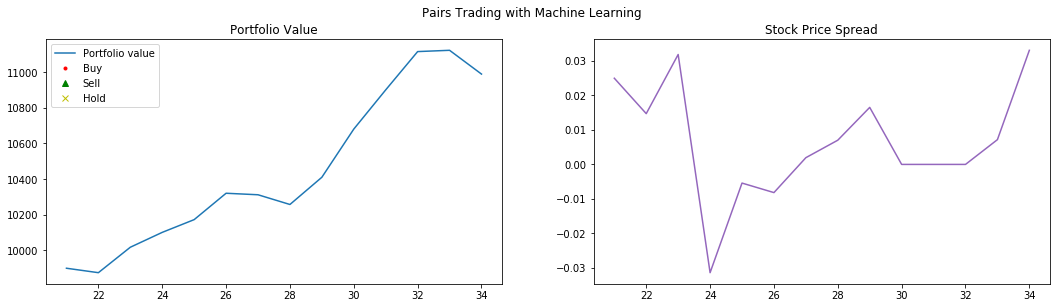

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22758774 0.22762306 0.2269596 ]
 [0.33129233 0.33080673 0.33035004]
 [0.34753045 0.34837854 0.34743795]
 [0.3250942  0.32350948 0.32630053]
 [0.33191162 0.33104694 0.33224756]
 [0.33785713 0.33736825 0.33901626]
 [0.31210974 0.3115764  0.31206465]
 [0.32801154 0.32812217 0.32799867]
 [0.3483174  0.34756744 0.34705785]
 [0.34718895 0.34718147 0.3477896 ]
 [0.33209735 0.329708   0.33415955]
 [0.33057928 0.32948345 0.3314146 ]
 [0.32060757 0.3207941  0.32106924]
 [0.31673983 0.31660116 0.31660777]], shape=(14, 3), dtype=float32)


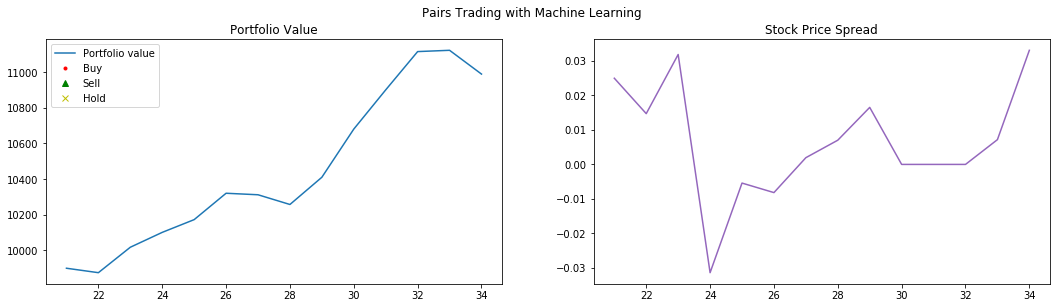

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22758308 0.2276184  0.22695494]
 [0.33129233 0.33080673 0.33035004]
 [0.34753045 0.34837854 0.34743795]
 [0.32512814 0.32354343 0.32633448]
 [0.33192158 0.3310569  0.3322575 ]
 [0.33788794 0.33739907 0.33904704]
 [0.3122543  0.31172097 0.3122092 ]
 [0.32801154 0.32812217 0.32799867]
 [0.3482909  0.3475409  0.34703133]
 [0.34706375 0.34705627 0.3476644 ]
 [0.33223128 0.3298419  0.33429345]
 [0.33072966 0.32963383 0.33156496]
 [0.32055917 0.3207457  0.32102084]
 [0.31673583 0.31659716 0.31660378]], shape=(14, 3), dtype=float32)


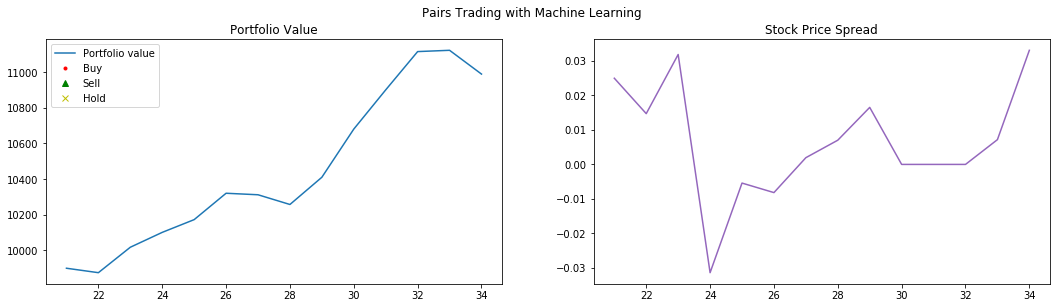

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22808024 0.22811556 0.2274521 ]
 [0.33129233 0.33080673 0.33035004]
 [0.34753045 0.34837854 0.34743795]
 [0.32561016 0.32402545 0.3268165 ]
 [0.3323429  0.3314782  0.33267882]
 [0.33843127 0.3379424  0.33959037]
 [0.31277642 0.31224307 0.31273133]
 [0.32801154 0.32812217 0.32799867]
 [0.3487644  0.34801438 0.34750482]
 [0.34746316 0.34745568 0.3480638 ]
 [0.33273938 0.33035    0.33480155]
 [0.3312752  0.33017936 0.33211052]
 [0.32103744 0.32122397 0.3214991 ]
 [0.31723225 0.31709358 0.3171002 ]], shape=(14, 3), dtype=float32)


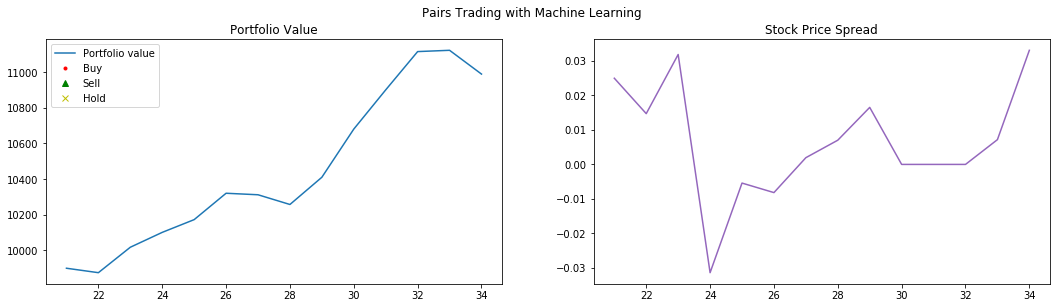

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22875765 0.22879297 0.2281295 ]
 [0.33129233 0.33080673 0.33035004]
 [0.34753048 0.34837854 0.34743795]
 [0.3262559  0.32467118 0.32746223]
 [0.3329177  0.332053   0.33325362]
 [0.33914682 0.33865795 0.34030592]
 [0.31339204 0.3128587  0.31334695]
 [0.32801154 0.32812217 0.32799867]
 [0.34889302 0.348143   0.34763345]
 [0.3480628  0.34805533 0.34866345]
 [0.33333516 0.3309458  0.33539733]
 [0.3319497  0.33085388 0.33278504]
 [0.32171246 0.321899   0.32217413]
 [0.31790888 0.3177702  0.31777683]], shape=(14, 3), dtype=float32)


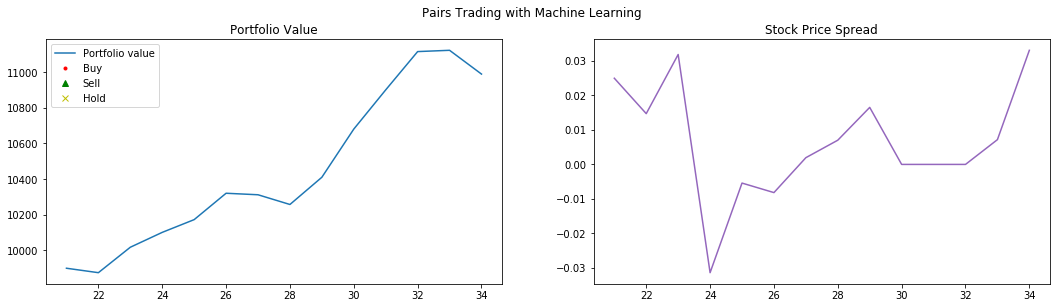

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22895616 0.22899148 0.22832802]
 [0.33129233 0.33080673 0.33035004]
 [0.34753048 0.34837854 0.34743795]
 [0.32648    0.3248953  0.32768634]
 [0.33307752 0.33221284 0.33341345]
 [0.33938247 0.3388936  0.3405416 ]
 [0.31358507 0.31305173 0.31353998]
 [0.32801154 0.32812217 0.32799867]
 [0.34889302 0.348143   0.34763345]
 [0.3481769  0.34816942 0.34877753]
 [0.33353457 0.3311452  0.33559674]
 [0.3322177  0.33112186 0.33305302]
 [0.32191148 0.32209802 0.32237315]
 [0.31810907 0.3179704  0.317977  ]], shape=(14, 3), dtype=float32)


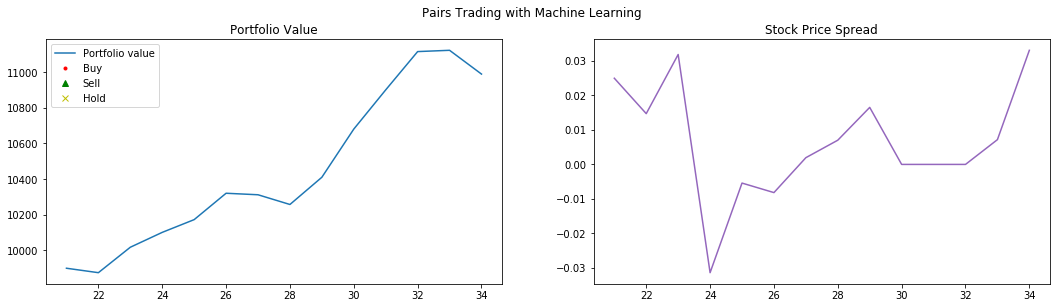

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.2286428  0.22867812 0.22801466]
 [0.33129233 0.33080673 0.33035004]
 [0.34753048 0.34837854 0.34743795]
 [0.32623574 0.32465103 0.32744208]
 [0.332831   0.3319663  0.33316693]
 [0.33910424 0.33861536 0.34026334]
 [0.3133439  0.31281057 0.31329882]
 [0.32801154 0.32812217 0.32799867]
 [0.34889302 0.348143   0.34763345]
 [0.34779507 0.3477876  0.3483957 ]
 [0.33327785 0.33088848 0.33534002]
 [0.33206278 0.33096695 0.3328981 ]
 [0.3215574  0.32174394 0.32201907]
 [0.31780016 0.3176615  0.3176681 ]], shape=(14, 3), dtype=float32)


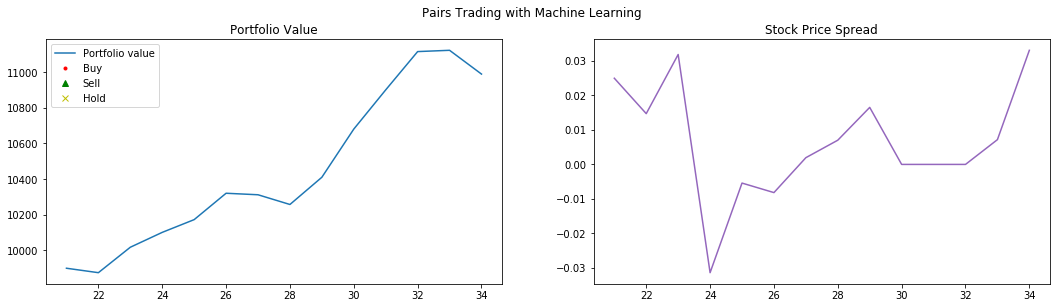

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22800002 0.22803533 0.22737187]
 [0.33129233 0.33080673 0.33035004]
 [0.34753048 0.34837854 0.34743795]
 [0.325686   0.3241013  0.32689235]
 [0.3323372  0.33147252 0.33267313]
 [0.3384949  0.33800605 0.33965403]
 [0.31281808 0.31228474 0.312773  ]
 [0.32801154 0.32812217 0.32799867]
 [0.3486284  0.3478784  0.34736884]
 [0.34710854 0.34710106 0.34770918]
 [0.33273798 0.3303486  0.33480018]
 [0.33165026 0.33055443 0.3324856 ]
 [0.3208711  0.32105765 0.32133278]
 [0.31716397 0.3170253  0.31703192]], shape=(14, 3), dtype=float32)


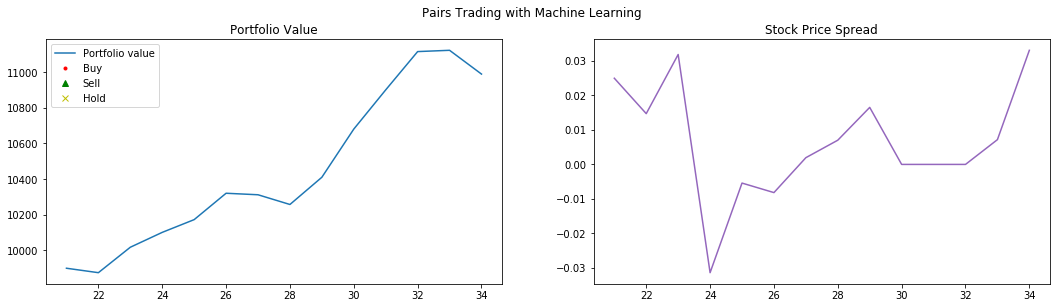

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22767845 0.22771376 0.2270503 ]
 [0.33129233 0.33080673 0.33035004]
 [0.34753048 0.34837854 0.34743798]
 [0.3254313  0.32384658 0.32663763]
 [0.33214706 0.33128238 0.332483  ]
 [0.33821023 0.33772138 0.33936936]
 [0.3125678  0.31203446 0.3125227 ]
 [0.32801154 0.32812217 0.32799867]
 [0.34827894 0.34752893 0.34701937]
 [0.34675947 0.346752   0.3473601 ]
 [0.33245596 0.3300666  0.33451813]
 [0.33149    0.33039418 0.33232534]
 [0.32049447 0.320681   0.32095614]
 [0.31685284 0.31671417 0.31672078]], shape=(14, 3), dtype=float32)


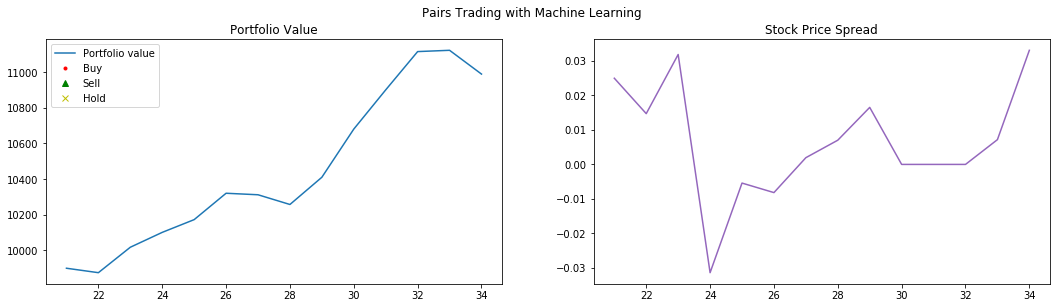

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.2278436  0.22787891 0.22721545]
 [0.33129233 0.3308067  0.33035004]
 [0.34753048 0.34837854 0.34743798]
 [0.32560953 0.32402483 0.32681587]
 [0.3323624  0.33149773 0.33269835]
 [0.3383968  0.33790794 0.33955592]
 [0.31272385 0.3121905  0.31267875]
 [0.32801154 0.32812217 0.32799867]
 [0.3484466  0.3476966  0.34718707]
 [0.34686616 0.34685868 0.3474668 ]
 [0.33256087 0.3301715  0.33462304]
 [0.3316915  0.33059567 0.33252683]
 [0.3205692  0.32075572 0.32103086]
 [0.31702572 0.31688705 0.31689367]], shape=(14, 3), dtype=float32)


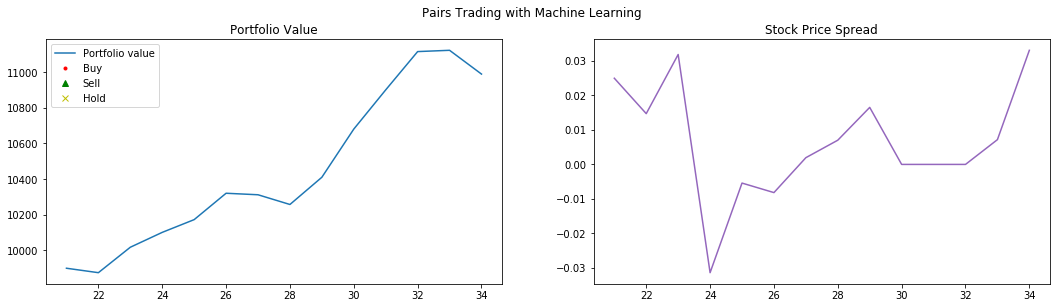

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.2283722  0.22840752 0.22774406]
 [0.33129233 0.3308067  0.33035004]
 [0.34753048 0.34837854 0.34743798]
 [0.32609978 0.32451507 0.32730612]
 [0.33286458 0.3319999  0.3332005 ]
 [0.33893767 0.33844882 0.3400968 ]
 [0.31317586 0.3126425  0.31313077]
 [0.32801154 0.32812214 0.32799864]
 [0.34889302 0.348143   0.34763348]
 [0.3473119  0.34730443 0.34791255]
 [0.3329623  0.33057293 0.33502448]
 [0.33214718 0.33105135 0.3329825 ]
 [0.32101244 0.32119897 0.3214741 ]
 [0.31756228 0.3174236  0.31743023]], shape=(14, 3), dtype=float32)


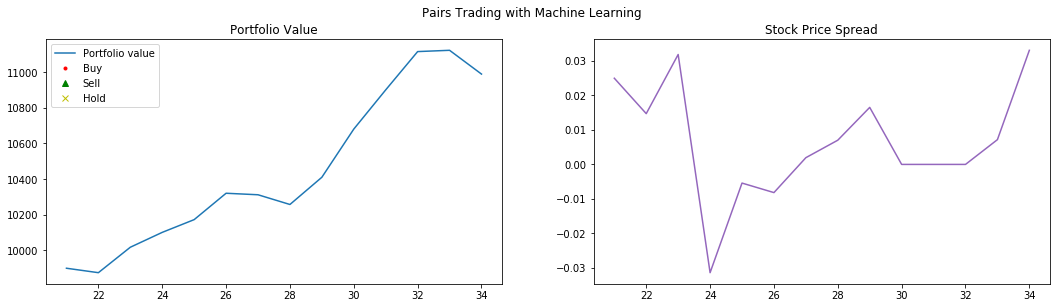

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22860533 0.22864065 0.22797719]
 [0.33129233 0.3308067  0.33035004]
 [0.34753048 0.34837854 0.34743798]
 [0.3263189  0.32473418 0.32752523]
 [0.33312547 0.3322608  0.3334614 ]
 [0.33921614 0.3387273  0.34037527]
 [0.31340432 0.31287098 0.31335923]
 [0.32801154 0.32812214 0.32799864]
 [0.34889302 0.348143   0.34763348]
 [0.34750015 0.34749264 0.34810078]
 [0.3331965  0.33080712 0.33525866]
 [0.33237848 0.33128265 0.3332138 ]
 [0.3212048  0.32139134 0.32166648]
 [0.3178047  0.31766602 0.31767264]], shape=(14, 3), dtype=float32)


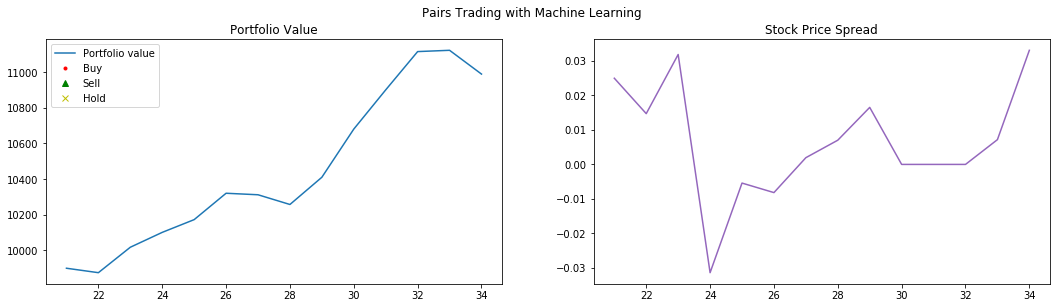

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22846797 0.22850329 0.22783983]
 [0.33129233 0.3308067  0.33035004]
 [0.34753048 0.34837854 0.34743798]
 [0.32620835 0.32462364 0.3274147 ]
 [0.33304876 0.33218408 0.3333847 ]
 [0.33913234 0.3386435  0.34029147]
 [0.3133016  0.31276825 0.3132565 ]
 [0.32801154 0.32812214 0.32799864]
 [0.34889302 0.348143   0.34763348]
 [0.34731516 0.34730765 0.3479158 ]
 [0.33310103 0.33071166 0.3351632 ]
 [0.33229396 0.33119816 0.33312932]
 [0.32103646 0.321223   0.32149813]
 [0.3176742  0.31753552 0.31754214]], shape=(14, 3), dtype=float32)


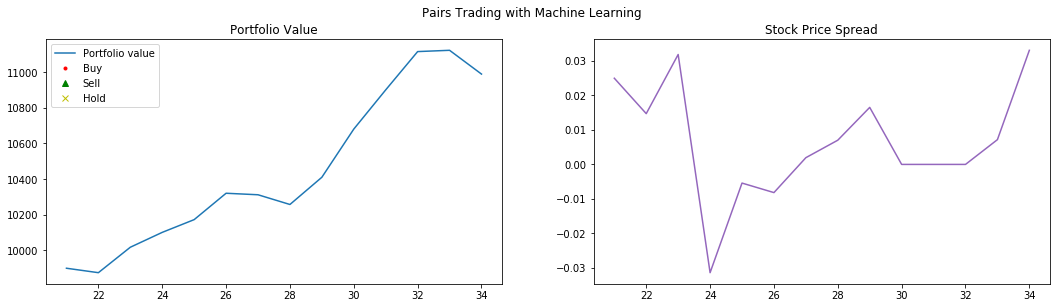

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22803743 0.22807275 0.22740929]
 [0.33129233 0.3308067  0.33035004]
 [0.34753048 0.34837854 0.34743798]
 [0.32585415 0.32426944 0.3270605 ]
 [0.33266917 0.3318045  0.33300513]
 [0.3387414  0.33825254 0.33990052]
 [0.31292242 0.31238908 0.31287733]
 [0.32801154 0.32812214 0.32799864]
 [0.3486206  0.3478706  0.34736106]
 [0.3468227  0.3468152  0.34742334]
 [0.33271304 0.33032367 0.3347752 ]
 [0.33195856 0.33086276 0.33279392]
 [0.32055146 0.320738   0.32101312]
 [0.3172496  0.31711096 0.31711757]], shape=(14, 3), dtype=float32)


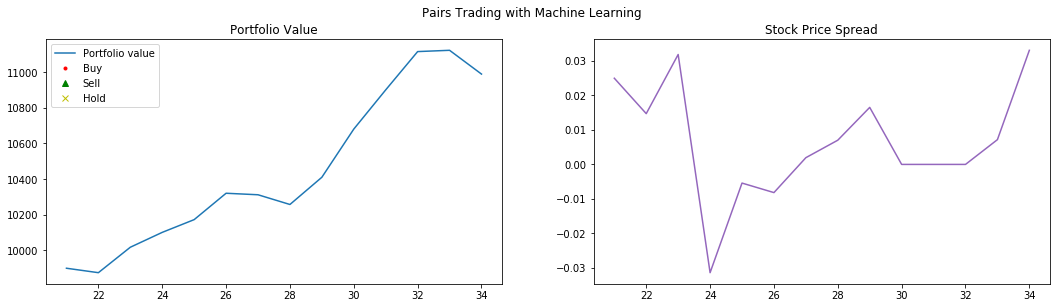

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22794478 0.22798009 0.22731663]
 [0.33129233 0.3308067  0.33035004]
 [0.34753048 0.34837854 0.34743798]
 [0.3257841  0.32419938 0.32699043]
 [0.33250234 0.33163768 0.3328383 ]
 [0.33861113 0.33812228 0.33977026]
 [0.31278005 0.3122467  0.31273496]
 [0.32801154 0.32812214 0.32799864]
 [0.34852463 0.34777462 0.3472651 ]
 [0.3466623  0.3466548  0.34726295]
 [0.33254164 0.3301523  0.33460385]
 [0.33182368 0.33072788 0.33265904]
 [0.3204079  0.32059443 0.32086957]
 [0.3171639  0.31702524 0.31703186]], shape=(14, 3), dtype=float32)


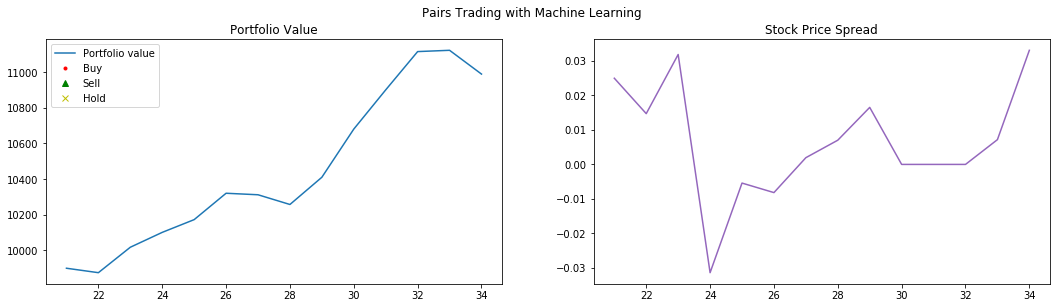

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.2282485  0.22828382 0.22762036]
 [0.33129233 0.3308067  0.33035004]
 [0.34753048 0.34837854 0.34743798]
 [0.326043   0.3244583  0.32724935]
 [0.33264092 0.33177626 0.33297688]
 [0.33883905 0.33835018 0.3399982 ]
 [0.312955   0.31242165 0.3129099 ]
 [0.32801154 0.32812214 0.32799864]
 [0.34885496 0.34810495 0.34759542]
 [0.34688696 0.34687945 0.3474876 ]
 [0.3326851  0.33029577 0.3347473 ]
 [0.33197197 0.33087617 0.33280733]
 [0.3206349  0.32082143 0.32109657]
 [0.31747147 0.3173328  0.31733942]], shape=(14, 3), dtype=float32)


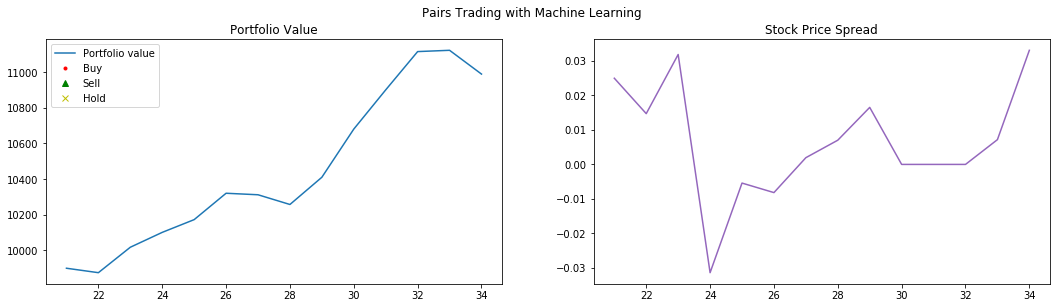

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22874886 0.22878417 0.22812071]
 [0.33129233 0.3308067  0.33035004]
 [0.34753048 0.34837854 0.34743798]
 [0.3264624  0.32487768 0.32766873]
 [0.33295116 0.3320865  0.33328712]
 [0.3392762  0.33878732 0.34043533]
 [0.31331116 0.31277782 0.31326607]
 [0.32801154 0.32812214 0.32799864]
 [0.34889302 0.348143   0.34763348]
 [0.34735432 0.3473468  0.34795496]
 [0.33300915 0.3306198  0.33507136]
 [0.33226117 0.33116537 0.33309653]
 [0.3210595  0.32124603 0.32152116]
 [0.31797636 0.3178377  0.3178443 ]], shape=(14, 3), dtype=float32)


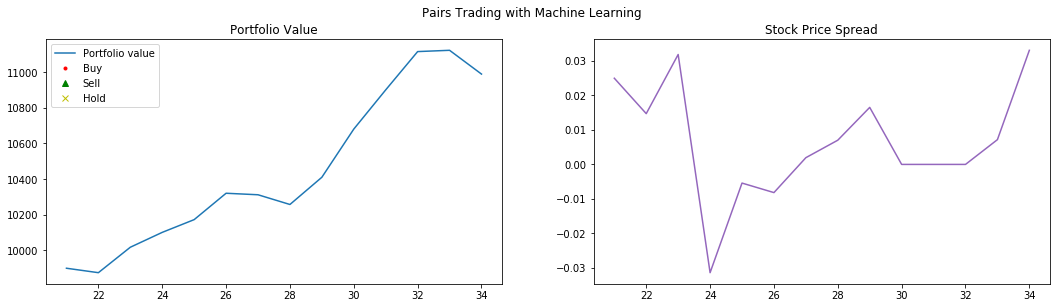

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22879335 0.22882867 0.22816521]
 [0.33129233 0.3308067  0.33035004]
 [0.34753048 0.34837854 0.34743798]
 [0.3264918  0.3249071  0.32769814]
 [0.33295158 0.33208692 0.33328754]
 [0.33931312 0.33882424 0.34047225]
 [0.31338158 0.31284824 0.31333646]
 [0.32801154 0.32812214 0.32799864]
 [0.34889302 0.348143   0.34763348]
 [0.3473968  0.34738928 0.34799743]
 [0.3330587  0.33066937 0.33512092]
 [0.33225793 0.33116212 0.3330933 ]
 [0.32103404 0.32122058 0.3214957 ]
 [0.31802765 0.31788898 0.3178956 ]], shape=(14, 3), dtype=float32)


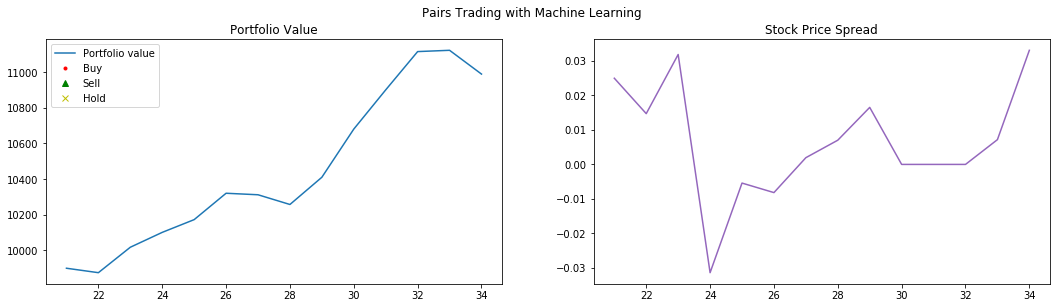

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22840773 0.22844304 0.22777958]
 [0.33129233 0.3308067  0.33035004]
 [0.34753048 0.34837854 0.34743798]
 [0.32614145 0.32455674 0.3273478 ]
 [0.33262748 0.33176282 0.33296344]
 [0.33896634 0.33847746 0.34012547]
 [0.3131691  0.31263575 0.31312397]
 [0.32801154 0.32812214 0.32799864]
 [0.348893   0.34814298 0.34763348]
 [0.34699285 0.34698534 0.3475935 ]
 [0.33282268 0.33043334 0.33488488]
 [0.33197105 0.33087525 0.3328064 ]
 [0.32057917 0.3207657  0.32104084]
 [0.31764424 0.31750557 0.31751218]], shape=(14, 3), dtype=float32)


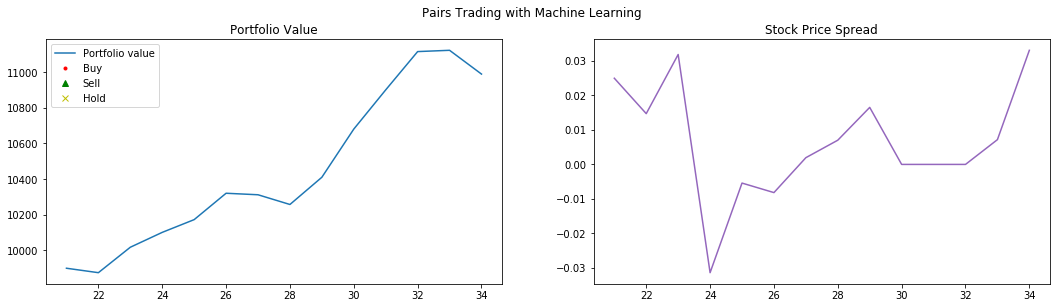

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22786617 0.22790149 0.22723803]
 [0.33129233 0.3308067  0.33035004]
 [0.34753048 0.34837854 0.34743798]
 [0.32566786 0.32408315 0.3268742 ]
 [0.33221635 0.3313517  0.3325523 ]
 [0.33850014 0.33801126 0.33965927]
 [0.3128541  0.31232077 0.312809  ]
 [0.32801154 0.32812214 0.32799867]
 [0.34858415 0.34783414 0.34732464]
 [0.34644526 0.34643775 0.3470459 ]
 [0.3324932  0.33010387 0.3345554 ]
 [0.3315916  0.3304958  0.33242697]
 [0.3200491  0.32023564 0.32051077]
 [0.31710407 0.3169654  0.31697202]], shape=(14, 3), dtype=float32)


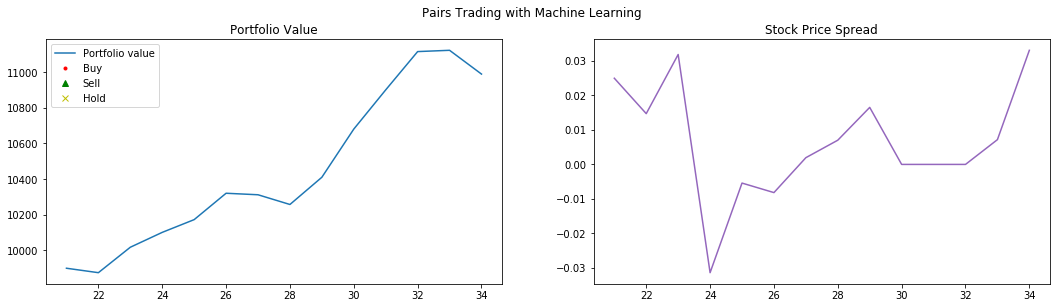

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22786795 0.22790326 0.2272398 ]
 [0.33129233 0.3308067  0.33035004]
 [0.34753048 0.34837854 0.34743798]
 [0.325677   0.3240923  0.32688335]
 [0.33223012 0.33136547 0.33256608]
 [0.33853132 0.33804244 0.33969045]
 [0.31291053 0.31237718 0.3128654 ]
 [0.32801154 0.32812214 0.32799867]
 [0.34862778 0.3478778  0.34736827]
 [0.34645104 0.34644353 0.34705168]
 [0.3325311  0.33014178 0.3345933 ]
 [0.33160594 0.33051014 0.3324413 ]
 [0.3199615  0.32014802 0.32042316]
 [0.31710827 0.3169696  0.31697622]], shape=(14, 3), dtype=float32)


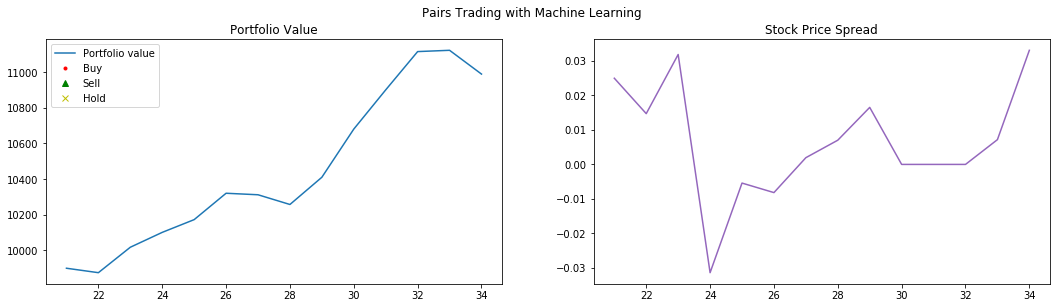

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.2283498  0.22838512 0.22772166]
 [0.33129233 0.3308067  0.33035004]
 [0.3475305  0.34837854 0.34743798]
 [0.3261053  0.3245206  0.32731164]
 [0.33259287 0.33172822 0.33292884]
 [0.3389879  0.338499   0.34014702]
 [0.31328097 0.31274763 0.31323585]
 [0.32801154 0.32812214 0.32799867]
 [0.348893   0.348143   0.34763348]
 [0.3469137  0.3469062  0.34751433]
 [0.33287936 0.33049005 0.33494157]
 [0.3319665  0.3308707  0.33280185]
 [0.3203193  0.32050583 0.32078096]
 [0.3175901  0.31745142 0.31745803]], shape=(14, 3), dtype=float32)


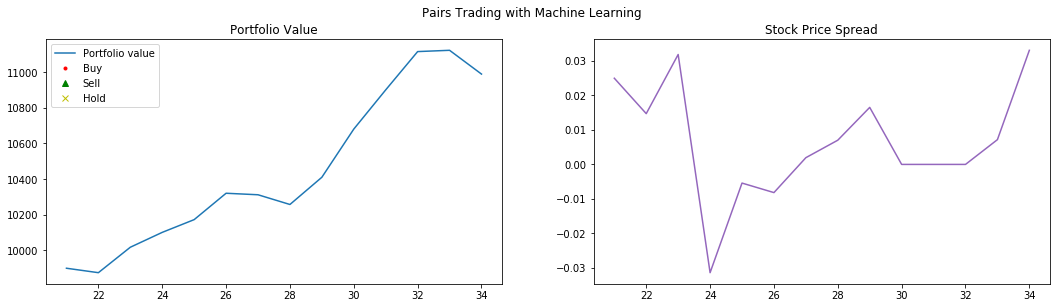

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22862181 0.22865713 0.22799367]
 [0.33129233 0.3308067  0.33035004]
 [0.3475305  0.34837854 0.34743798]
 [0.32634053 0.32475582 0.32754686]
 [0.33277357 0.3319089  0.33310953]
 [0.33921093 0.33872205 0.34037006]
 [0.31346574 0.3129324  0.31342062]
 [0.32801154 0.32812214 0.32799867]
 [0.348893   0.348143   0.3476335 ]
 [0.34716576 0.34715825 0.3477664 ]
 [0.33304358 0.33065426 0.33510578]
 [0.3321758  0.33108002 0.33301115]
 [0.32049093 0.32067746 0.3209526 ]
 [0.31786627 0.3177276  0.3177342 ]], shape=(14, 3), dtype=float32)


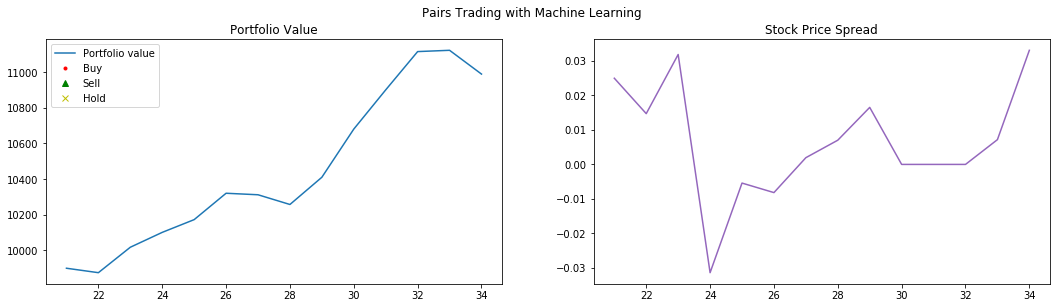

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.2285659  0.22860122 0.22793776]
 [0.33129233 0.3308067  0.33035004]
 [0.3475305  0.34837854 0.34743798]
 [0.32628167 0.32469696 0.327488  ]
 [0.33268374 0.3318191  0.3330197 ]
 [0.3391318  0.33864293 0.34029093]
 [0.313375   0.31284165 0.31332988]
 [0.32801154 0.32812214 0.32799867]
 [0.348893   0.348143   0.3476335 ]
 [0.3470719  0.34706438 0.34767252]
 [0.33293438 0.33054507 0.33499658]
 [0.33211887 0.33102307 0.33295423]
 [0.3203627  0.32054922 0.32082435]
 [0.31782007 0.3176814  0.31768802]], shape=(14, 3), dtype=float32)


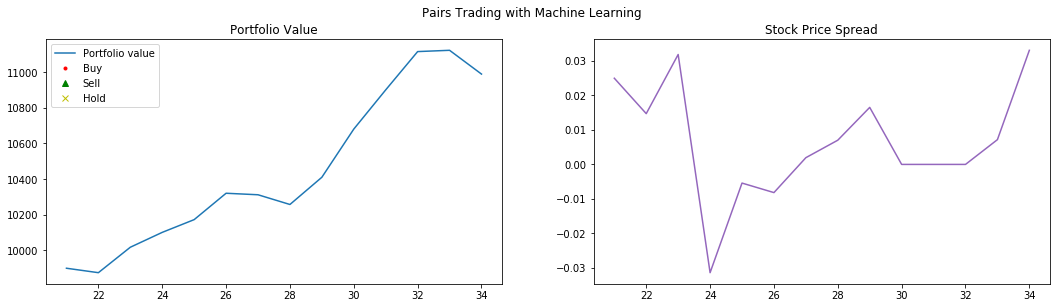

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22822778 0.2282631  0.22759964]
 [0.33129233 0.3308067  0.33035004]
 [0.3475305  0.34837854 0.34743798]
 [0.32597604 0.32439134 0.32718238]
 [0.33235732 0.33149266 0.33269328]
 [0.33880055 0.33831167 0.33995968]
 [0.31305778 0.31252444 0.31301266]
 [0.32801154 0.32812214 0.32799867]
 [0.348893   0.348143   0.3476335 ]
 [0.34669468 0.34668714 0.3472953 ]
 [0.33261514 0.3302258  0.3346773 ]
 [0.33181882 0.33072302 0.33265418]
 [0.3199864  0.32017294 0.32044807]
 [0.31749326 0.3173546  0.3173612 ]], shape=(14, 3), dtype=float32)


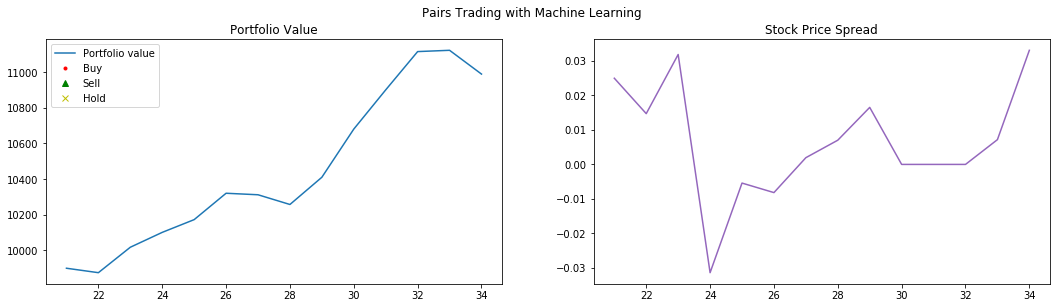

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22786534 0.22790065 0.2272372 ]
 [0.33129233 0.3308067  0.33035004]
 [0.3475305  0.34837854 0.34743798]
 [0.32563022 0.3240455  0.32683656]
 [0.33201987 0.3311552  0.33235583]
 [0.3384335  0.3379446  0.33959264]
 [0.31272432 0.31219098 0.3126792 ]
 [0.32801154 0.32812214 0.32799867]
 [0.34860626 0.34785628 0.34734678]
 [0.34628415 0.3462766  0.3468848 ]
 [0.33227184 0.3298825  0.33433402]
 [0.33148634 0.33039054 0.3323217 ]
 [0.31956476 0.3197513  0.32002643]
 [0.31714025 0.31700158 0.3170082 ]], shape=(14, 3), dtype=float32)


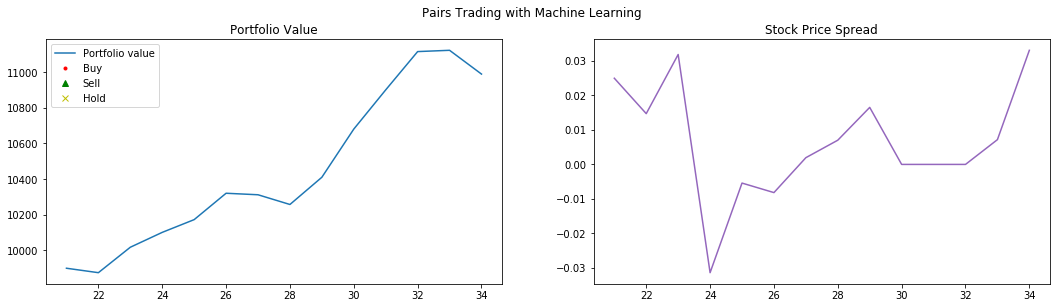

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22815385 0.22818917 0.22752571]
 [0.33129233 0.3308067  0.33035004]
 [0.3475305  0.34837854 0.34743798]
 [0.32583526 0.32425058 0.3270416 ]
 [0.33222622 0.33136156 0.33256218]
 [0.33868286 0.33819395 0.339842  ]
 [0.3129271  0.31239375 0.31288198]
 [0.32801157 0.32812214 0.32799867]
 [0.348893   0.348143   0.3476335 ]
 [0.34649584 0.34648833 0.3470965 ]
 [0.3324468  0.33005747 0.334509  ]
 [0.33162972 0.33053392 0.33246508]
 [0.31973118 0.3199177  0.32019284]
 [0.31743163 0.31729296 0.31729957]], shape=(14, 3), dtype=float32)


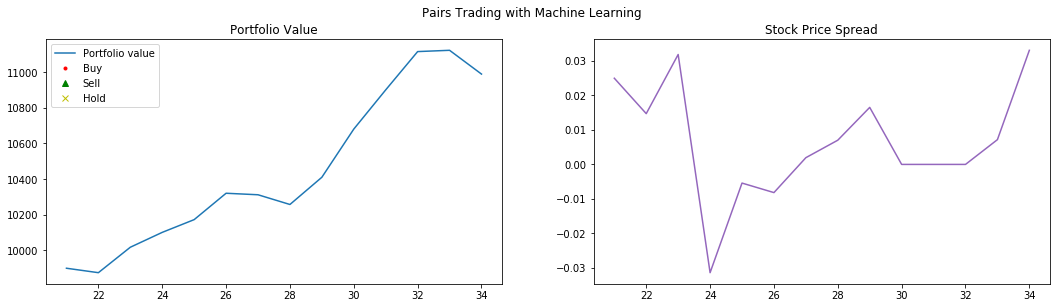

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.2284215  0.22845681 0.22779335]
 [0.33129233 0.3308067  0.33035004]
 [0.3475305  0.34837854 0.34743798]
 [0.32604954 0.32446486 0.32725587]
 [0.33244753 0.33158287 0.3327835 ]
 [0.33892646 0.33843756 0.3400856 ]
 [0.31317088 0.31263754 0.31312576]
 [0.32801157 0.32812214 0.32799867]
 [0.348893   0.34814298 0.3476335 ]
 [0.34671578 0.34670827 0.34731644]
 [0.33266425 0.3302749  0.33472642]
 [0.3317924  0.3306966  0.33262777]
 [0.31993255 0.32011908 0.32039422]
 [0.3177048  0.3175661  0.31757277]], shape=(14, 3), dtype=float32)


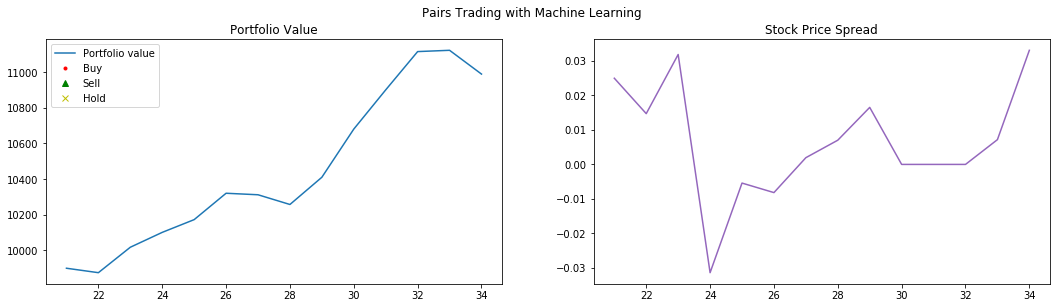

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22850177 0.22853708 0.22787362]
 [0.33129233 0.3308067  0.33035004]
 [0.3475305  0.34837854 0.34743798]
 [0.32612684 0.32454216 0.32733318]
 [0.33254945 0.3316848  0.3328854 ]
 [0.3390187  0.3385298  0.34017783]
 [0.31330526 0.31277192 0.31326014]
 [0.32801157 0.32812214 0.32799867]
 [0.348893   0.34814298 0.3476335 ]
 [0.34675777 0.34675026 0.34735844]
 [0.33277297 0.33038363 0.33483514]
 [0.33186102 0.33076522 0.33269638]
 [0.31999177 0.3201783  0.32045344]
 [0.317797   0.3176583  0.31766495]], shape=(14, 3), dtype=float32)


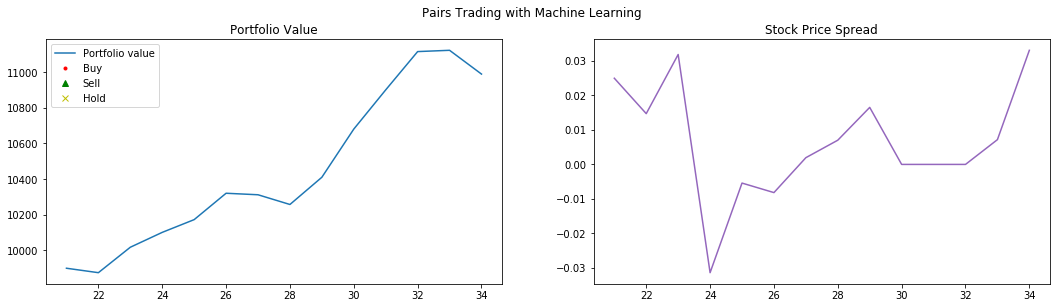

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22840562 0.22844094 0.22777748]
 [0.33129233 0.3308067  0.33035004]
 [0.3475305  0.34837854 0.347438  ]
 [0.32605404 0.32446936 0.32726038]
 [0.33252874 0.3316641  0.3328647 ]
 [0.3389715  0.3384826  0.34013063]
 [0.3133183  0.31278497 0.3132732 ]
 [0.32801157 0.32812214 0.32799867]
 [0.348893   0.34814298 0.3476335 ]
 [0.3466216  0.3466141  0.34722227]
 [0.33276406 0.33037472 0.33482623]
 [0.33181256 0.33071676 0.33264792]
 [0.31987447 0.320061   0.32033613]
 [0.31770957 0.31757087 0.3175775 ]], shape=(14, 3), dtype=float32)


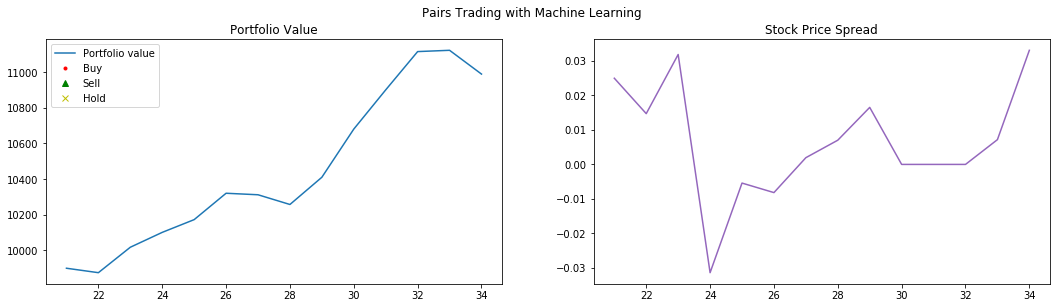

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.2282232  0.22825852 0.22759506]
 [0.33129233 0.3308067  0.33035004]
 [0.3475305  0.34837854 0.347438  ]
 [0.32591072 0.32432604 0.32711706]
 [0.33243233 0.33156767 0.3327683 ]
 [0.3388552  0.3383663  0.34001434]
 [0.31325078 0.31271744 0.31320566]
 [0.32801157 0.32812214 0.32799867]
 [0.348893   0.34814298 0.3476335 ]
 [0.34639132 0.3463838  0.346992  ]
 [0.33267477 0.33028543 0.33473694]
 [0.33169037 0.33059457 0.33252573]
 [0.31965294 0.31983948 0.3201146 ]
 [0.31753698 0.31739828 0.31740493]], shape=(14, 3), dtype=float32)


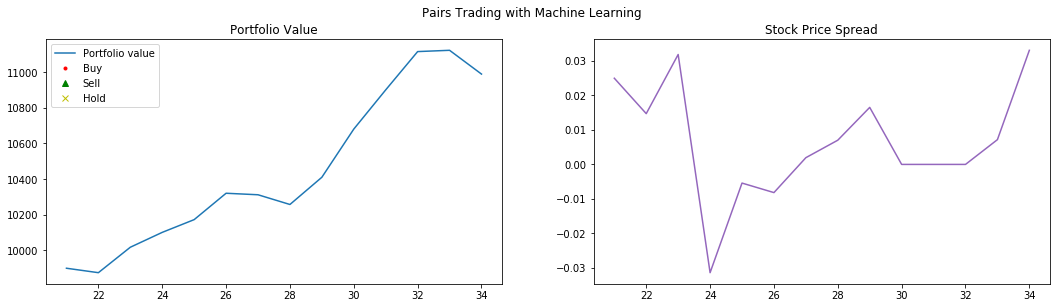

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.2280643  0.22809961 0.22743616]
 [0.33129233 0.3308067  0.33035004]
 [0.3475305  0.34837854 0.347438  ]
 [0.3257919  0.3242072  0.3269982 ]
 [0.33234555 0.3314809  0.3326815 ]
 [0.33873606 0.33824715 0.3398952 ]
 [0.31318158 0.31264824 0.31313646]
 [0.32801157 0.32812214 0.32799867]
 [0.348781   0.34803098 0.3475215 ]
 [0.34617478 0.34616727 0.34677547]
 [0.33258182 0.33019248 0.334644  ]
 [0.33160147 0.33050567 0.33243683]
 [0.3194582  0.31964472 0.31991985]
 [0.31738245 0.31724375 0.3172504 ]], shape=(14, 3), dtype=float32)


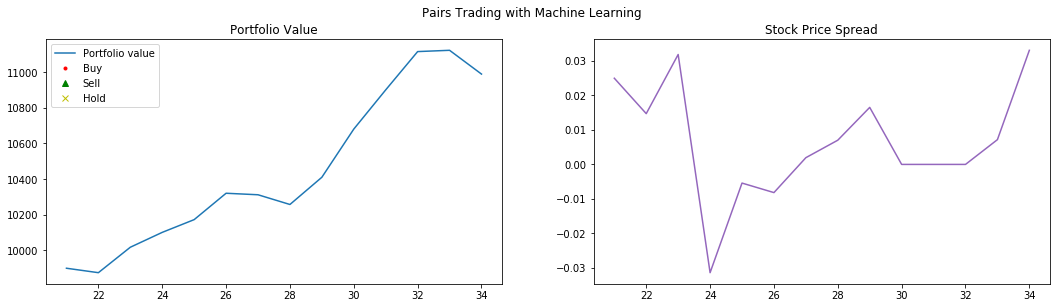

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22846927 0.22850458 0.22784112]
 [0.33129233 0.3308067  0.33035004]
 [0.3475305  0.34837854 0.347438  ]
 [0.32614288 0.32455817 0.3273492 ]
 [0.33269954 0.33183488 0.3330355 ]
 [0.33914727 0.33865836 0.3403064 ]
 [0.3135244  0.31299105 0.31347927]
 [0.32801157 0.32812214 0.32799867]
 [0.348893   0.34814298 0.3476335 ]
 [0.34652185 0.34651434 0.34712252]
 [0.33289316 0.33050382 0.33495533]
 [0.3318974  0.3308016  0.33273277]
 [0.31977132 0.31995788 0.320233  ]
 [0.31778803 0.31764933 0.31765598]], shape=(14, 3), dtype=float32)


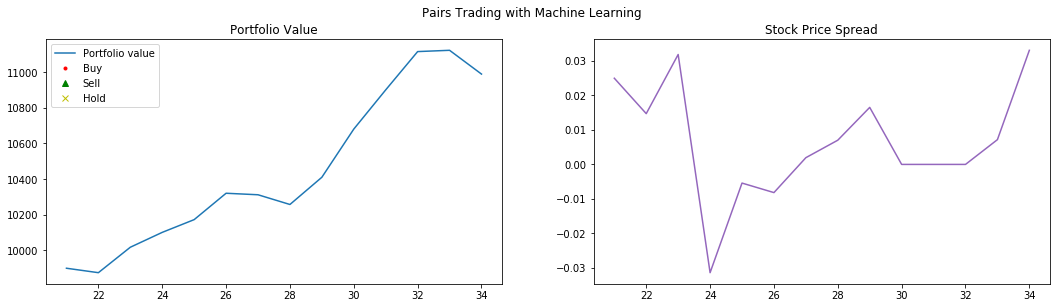

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22868167 0.22871698 0.22805353]
 [0.33129233 0.3308067  0.33035004]
 [0.3475305  0.34837854 0.347438  ]
 [0.32632533 0.32474065 0.32753164]
 [0.33285767 0.331993   0.33319363]
 [0.33930546 0.33881655 0.3404646 ]
 [0.31366336 0.31313002 0.31361824]
 [0.32801157 0.32812214 0.32799867]
 [0.348893   0.34814298 0.3476335 ]
 [0.34667826 0.34667075 0.34727892]
 [0.33301115 0.3306218  0.33507332]
 [0.33204237 0.33094656 0.33287773]
 [0.31992063 0.3201072  0.3203823 ]
 [0.31800154 0.31786284 0.31786948]], shape=(14, 3), dtype=float32)


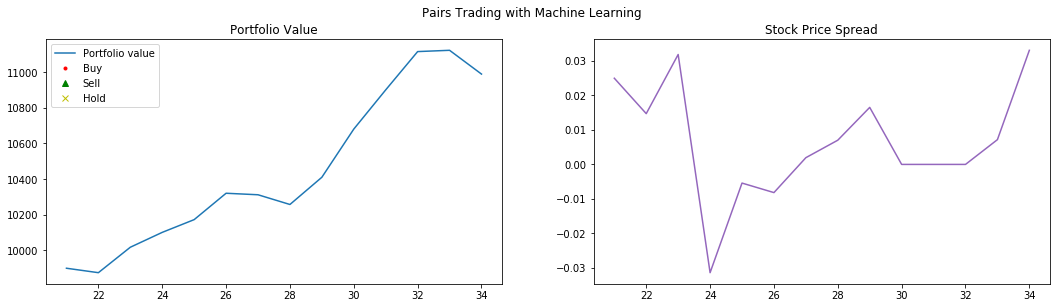

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22858195 0.22861727 0.2279538 ]
 [0.33129233 0.3308067  0.33035004]
 [0.3475305  0.34837854 0.347438  ]
 [0.3262269  0.3246422  0.3274332 ]
 [0.33270234 0.33183768 0.3330383 ]
 [0.33912054 0.33863163 0.34027967]
 [0.31351027 0.31297693 0.31346515]
 [0.32801157 0.32812214 0.32799867]
 [0.348893   0.34814298 0.3476335 ]
 [0.34652066 0.34651315 0.34712133]
 [0.3328367  0.33044738 0.33489886]
 [0.33189565 0.33079985 0.332731  ]
 [0.3197206  0.31990716 0.32018226]
 [0.31790423 0.31776553 0.31777218]], shape=(14, 3), dtype=float32)


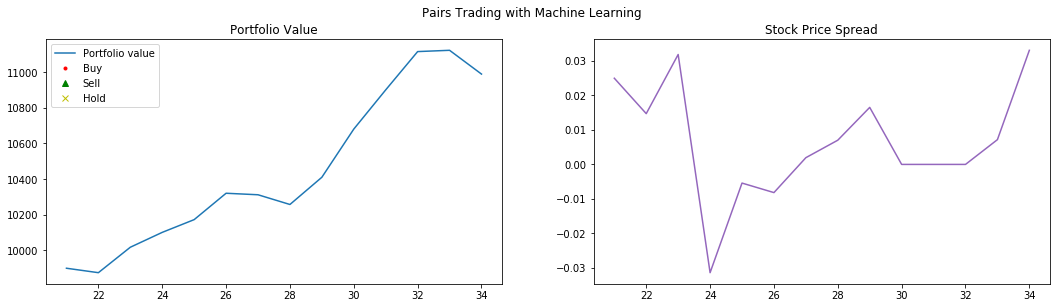

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22831137 0.22834669 0.22768323]
 [0.33129233 0.3308067  0.33035004]
 [0.3475305  0.34837854 0.347438  ]
 [0.32597023 0.32438555 0.32717654]
 [0.33243847 0.3315738  0.33277443]
 [0.33880538 0.33831647 0.3399645 ]
 [0.3132646  0.31273127 0.3132195 ]
 [0.32801157 0.32812214 0.32799867]
 [0.348893   0.34814298 0.3476335 ]
 [0.3461942  0.3461867  0.3467949 ]
 [0.3325707  0.3301814  0.33463287]
 [0.33164072 0.33054492 0.33247608]
 [0.319421   0.31960756 0.31988266]
 [0.31763792 0.31749922 0.31750587]], shape=(14, 3), dtype=float32)


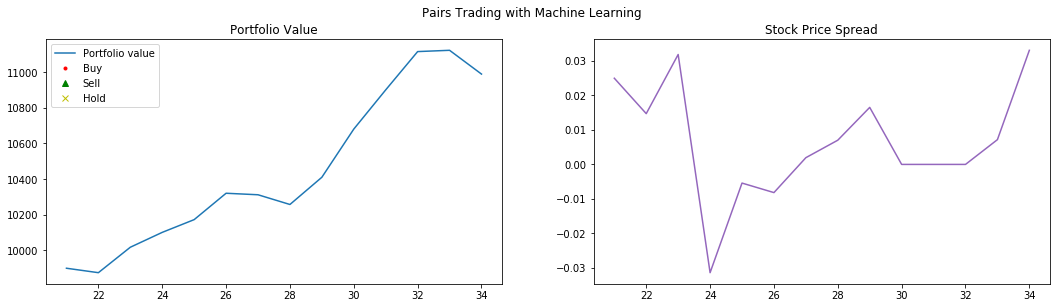

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.2281011  0.22813642 0.22747296]
 [0.33129233 0.3308067  0.33035004]
 [0.3475305  0.34837854 0.347438  ]
 [0.32578415 0.32419947 0.32699046]
 [0.33223608 0.33137143 0.33257204]
 [0.33858675 0.33809784 0.33974588]
 [0.31307974 0.3125464  0.31303462]
 [0.32801157 0.32812214 0.32799867]
 [0.34878534 0.34803534 0.34752586]
 [0.34592453 0.34591702 0.3465252 ]
 [0.33237675 0.32998744 0.33443892]
 [0.33147186 0.33037606 0.33230722]
 [0.3191945  0.31938106 0.31965616]
 [0.31743225 0.31729355 0.3173002 ]], shape=(14, 3), dtype=float32)


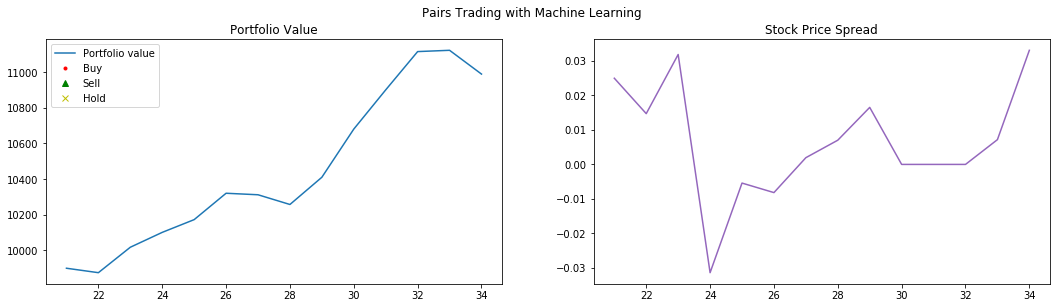

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.2285864  0.22862172 0.22795826]
 [0.33129233 0.3308067  0.33035004]
 [0.3475305  0.34837854 0.347438  ]
 [0.3261845  0.32459983 0.32739082]
 [0.33260635 0.33174172 0.33294234]
 [0.3390951  0.33860618 0.34025422]
 [0.31343314 0.3128998  0.31338802]
 [0.32801157 0.32812214 0.32799867]
 [0.348893   0.34814298 0.3476335 ]
 [0.3463495  0.346342   0.34695017]
 [0.33269665 0.33030733 0.33475882]
 [0.33177385 0.33067805 0.3326092 ]
 [0.3195502  0.31973675 0.32001185]
 [0.31792113 0.31778243 0.31778908]], shape=(14, 3), dtype=float32)


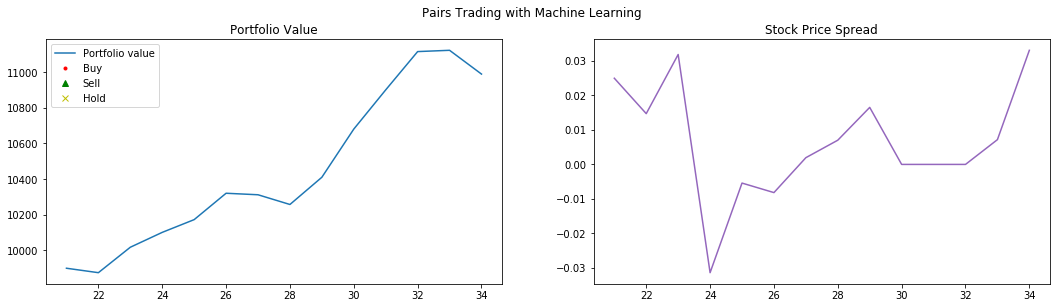

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22887309 0.2289084  0.22824495]
 [0.33129233 0.3308067  0.33035004]
 [0.3475305  0.34837854 0.347438  ]
 [0.32645264 0.32486796 0.32765895]
 [0.33282116 0.33195654 0.33315715]
 [0.33938548 0.33889657 0.3405446 ]
 [0.31366405 0.3131307  0.31361893]
 [0.32801157 0.32812214 0.32799867]
 [0.348893   0.34814298 0.3476335 ]
 [0.34660703 0.34659952 0.3472077 ]
 [0.33290443 0.33051512 0.3349666 ]
 [0.33196378 0.33086798 0.33279914]
 [0.31978127 0.31996784 0.32024294]
 [0.31821048 0.31807178 0.31807843]], shape=(14, 3), dtype=float32)


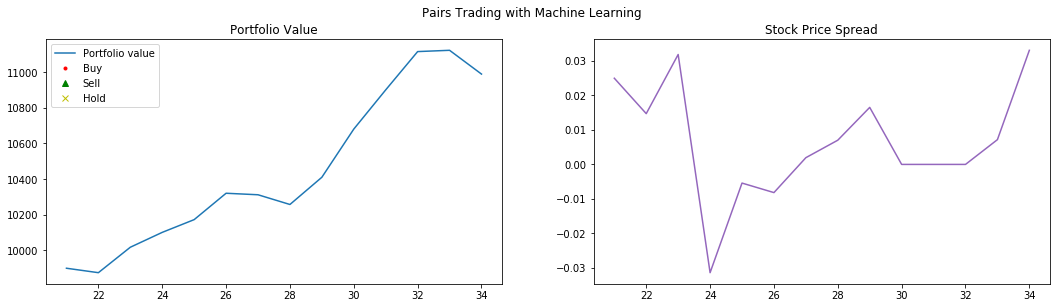

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22879678 0.2288321  0.22816864]
 [0.33129233 0.3308067  0.33035004]
 [0.3475305  0.34837854 0.347438  ]
 [0.32641783 0.32483315 0.32762414]
 [0.33273962 0.331875   0.3330756 ]
 [0.33932367 0.33883476 0.3404828 ]
 [0.31364417 0.31311083 0.31359905]
 [0.32801157 0.32812214 0.32799867]
 [0.348893   0.34814298 0.3476335 ]
 [0.34648767 0.34648016 0.34708834]
 [0.33286223 0.33047292 0.3349244 ]
 [0.33189413 0.33079833 0.3327295 ]
 [0.3196695  0.31985608 0.32013118]
 [0.3181373  0.3179986  0.31800523]], shape=(14, 3), dtype=float32)


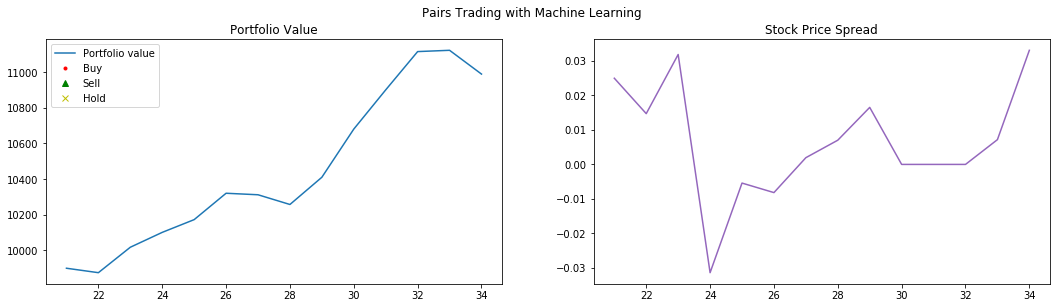

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22844473 0.22848004 0.22781658]
 [0.33129233 0.3308067  0.33035004]
 [0.3475305  0.34837854 0.347438  ]
 [0.3261406  0.32455593 0.32734692]
 [0.3324381  0.3315735  0.3327741 ]
 [0.33899876 0.33850986 0.3401579 ]
 [0.31343874 0.3129054  0.31339362]
 [0.32801157 0.32812214 0.32799867]
 [0.348893   0.34814298 0.3476335 ]
 [0.34610352 0.346096   0.34670419]
 [0.33263868 0.33024937 0.33470085]
 [0.33162507 0.33052924 0.3324604 ]
 [0.3192879  0.31947446 0.31974956]
 [0.3177992  0.3176605  0.31766716]], shape=(14, 3), dtype=float32)


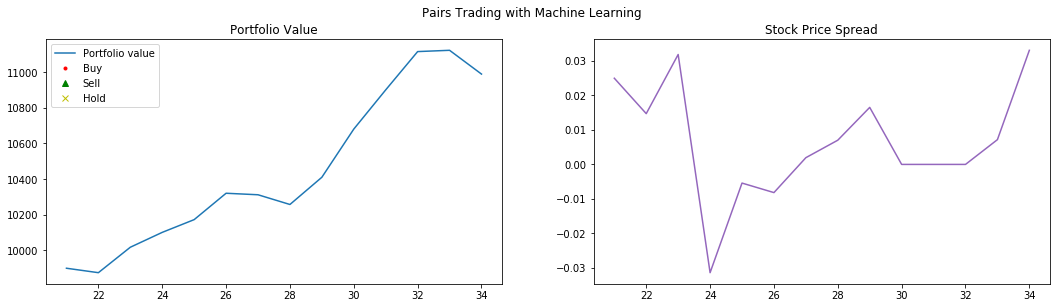

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22810793 0.22814324 0.22747979]
 [0.33129233 0.3308067  0.33035004]
 [0.3475305  0.34837854 0.347438  ]
 [0.32584673 0.32426205 0.32705304]
 [0.3321737  0.33130908 0.3325097 ]
 [0.33871576 0.33822685 0.3398749 ]
 [0.31326905 0.3127357  0.31322393]
 [0.32801157 0.32812214 0.32799867]
 [0.34877944 0.34802943 0.34751996]
 [0.3457263  0.3457188  0.34632698]
 [0.33245215 0.33006284 0.33451432]
 [0.33137685 0.33028102 0.33221218]
 [0.31892464 0.3191112  0.3193863 ]
 [0.31747088 0.31733215 0.31733882]], shape=(14, 3), dtype=float32)


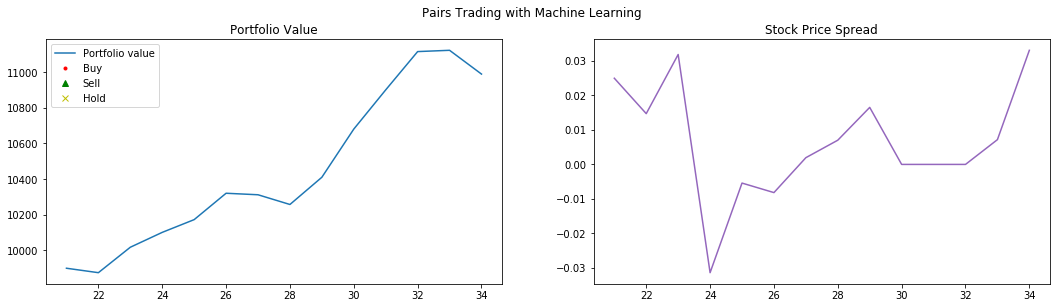

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22851112 0.22854644 0.22788298]
 [0.33129233 0.3308067  0.33035004]
 [0.3475305  0.34837854 0.347438  ]
 [0.32613316 0.32454848 0.32733947]
 [0.33250746 0.33164284 0.33284345]
 [0.33912754 0.33863863 0.34028667]
 [0.31362844 0.3130951  0.3135833 ]
 [0.32801157 0.32812214 0.32799867]
 [0.348893   0.34814298 0.3476335 ]
 [0.34612113 0.34611362 0.3467218 ]
 [0.33278587 0.33039656 0.33484805]
 [0.33160454 0.3305087  0.3324399 ]
 [0.31921694 0.3194035  0.3196786 ]
 [0.31786454 0.31772578 0.31773245]], shape=(14, 3), dtype=float32)


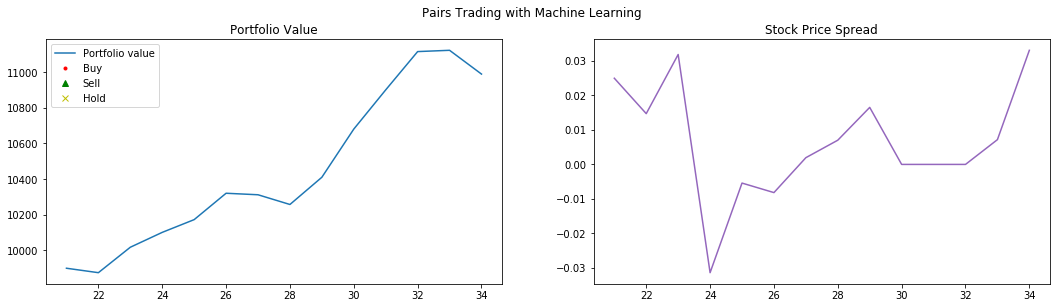

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.2287425  0.22877781 0.22811435]
 [0.33129233 0.3308067  0.33035004]
 [0.3475305  0.34837854 0.347438  ]
 [0.32631907 0.3247344  0.32752538]
 [0.33269623 0.3318316  0.33303222]
 [0.33932447 0.33883554 0.3404836 ]
 [0.31380582 0.31327248 0.3137607 ]
 [0.32801157 0.32812214 0.32799867]
 [0.348893   0.34814298 0.3476335 ]
 [0.3463394  0.3463319  0.34694007]
 [0.33293685 0.33054754 0.33499902]
 [0.33175594 0.3306601  0.33259127]
 [0.31940532 0.31959188 0.31986699]
 [0.31809422 0.3179555  0.31796217]], shape=(14, 3), dtype=float32)


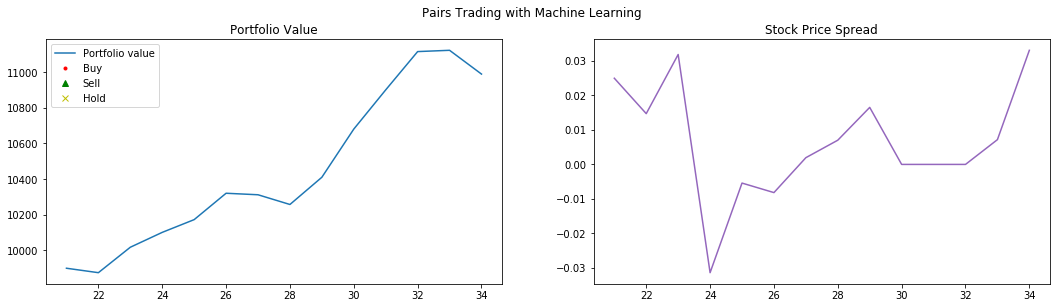

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22869551 0.22873083 0.22806737]
 [0.33129233 0.3308067  0.33035004]
 [0.3475305  0.34837854 0.347438  ]
 [0.326298   0.32471332 0.3275043 ]
 [0.33262846 0.33176383 0.33296445]
 [0.33923614 0.33874723 0.34039527]
 [0.3137196  0.31318626 0.31367448]
 [0.32801157 0.32812214 0.32799867]
 [0.348893   0.34814298 0.3476335 ]
 [0.34621552 0.346208   0.34681618]
 [0.33282635 0.33043703 0.33488852]
 [0.33174473 0.3306489  0.33258006]
 [0.31931496 0.31950152 0.31977662]
 [0.31805128 0.31791252 0.3179192 ]], shape=(14, 3), dtype=float32)


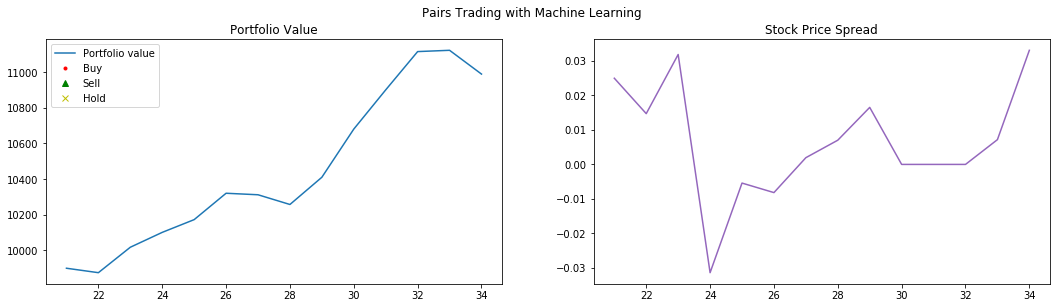

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22850446 0.22853978 0.22787632]
 [0.33129233 0.3308067  0.33035004]
 [0.3475305  0.34837854 0.347438  ]
 [0.32617214 0.32458746 0.32737845]
 [0.33237284 0.33150822 0.33270884]
 [0.33897808 0.33848917 0.3401372 ]
 [0.31345308 0.31291974 0.31340796]
 [0.32801157 0.32812214 0.32799867]
 [0.348893   0.34814298 0.3476335 ]
 [0.34591314 0.34590563 0.3465138 ]
 [0.33253986 0.33015054 0.33460203]
 [0.3316144  0.33051857 0.33244973]
 [0.3190573  0.31924385 0.31951895]
 [0.3178729  0.31773418 0.31774086]], shape=(14, 3), dtype=float32)


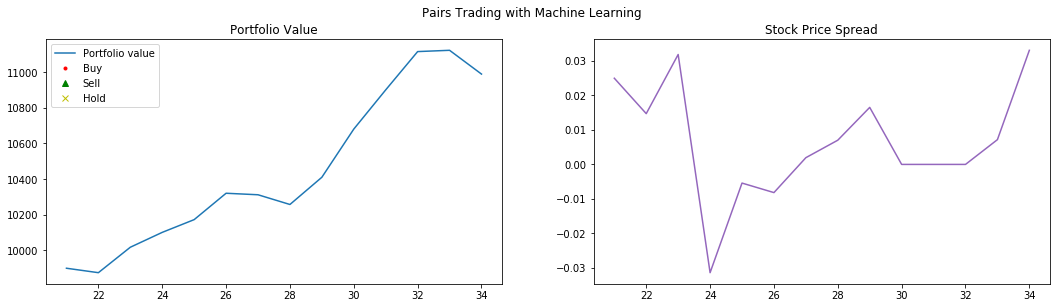

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22832088 0.2283562  0.22769274]
 [0.33129233 0.3308067  0.33035004]
 [0.3475305  0.34837854 0.347438  ]
 [0.32607263 0.32448795 0.32727894]
 [0.33214766 0.33128303 0.33248365]
 [0.33874893 0.33826002 0.33990806]
 [0.3132583  0.31272495 0.31321317]
 [0.32801157 0.32812214 0.32799867]
 [0.348893   0.34814298 0.3476335 ]
 [0.34565336 0.34564584 0.34625402]
 [0.33232227 0.32993296 0.33438444]
 [0.3315107  0.33041486 0.33234602]
 [0.31884643 0.319033   0.3193081 ]
 [0.31771278 0.31757408 0.31758076]], shape=(14, 3), dtype=float32)


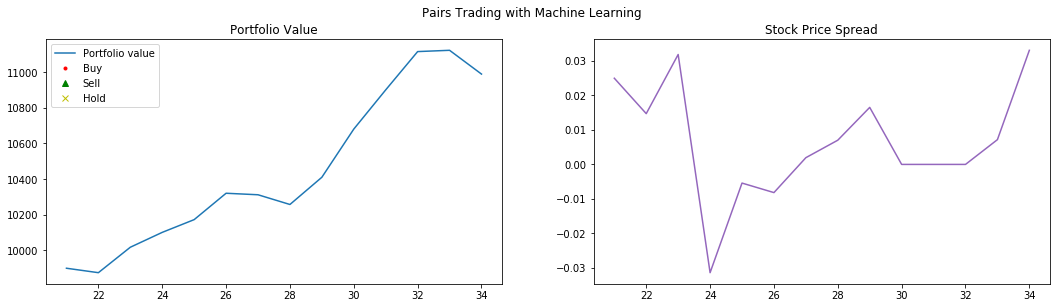

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22828186 0.22831717 0.22765371]
 [0.33129233 0.3308067  0.33035004]
 [0.3475305  0.34837854 0.347438  ]
 [0.3261304  0.3245457  0.3273367 ]
 [0.33209446 0.33122984 0.33243045]
 [0.3387318  0.3382429  0.33989093]
 [0.31325942 0.31272608 0.3132143 ]
 [0.32801157 0.32812214 0.32799867]
 [0.3488765  0.3481265  0.34761703]
 [0.34557062 0.3455631  0.3461713 ]
 [0.3323021  0.32991278 0.33436427]
 [0.33156013 0.3304643  0.33239546]
 [0.31883225 0.3190188  0.31929392]
 [0.31772378 0.31758505 0.31759173]], shape=(14, 3), dtype=float32)


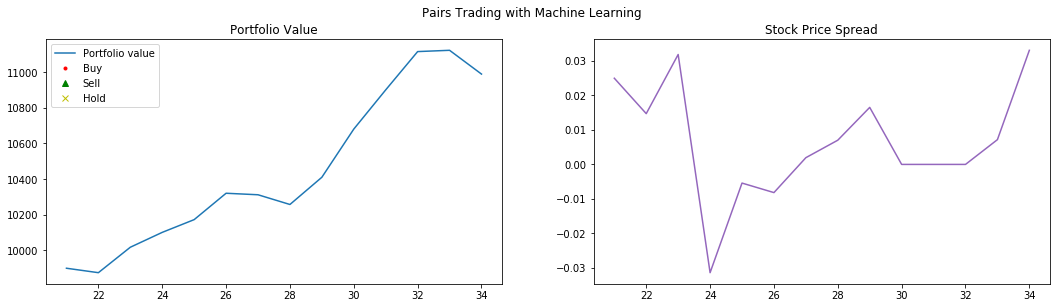

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.228947   0.22898231 0.22831886]
 [0.33129233 0.3308067  0.33035004]
 [0.3475305  0.34837854 0.347438  ]
 [0.32671788 0.32513323 0.3279242 ]
 [0.33260804 0.33174342 0.33294404]
 [0.3394122  0.3389233  0.34057134]
 [0.31380418 0.31327084 0.31375906]
 [0.32801157 0.32812214 0.32799867]
 [0.348893   0.34814298 0.3476335 ]
 [0.3461944  0.34618688 0.34679505]
 [0.33281854 0.33042923 0.3348807 ]
 [0.33203653 0.3309407  0.33287185]
 [0.3193646  0.31955117 0.31982628]
 [0.31837428 0.31823555 0.31824222]], shape=(14, 3), dtype=float32)


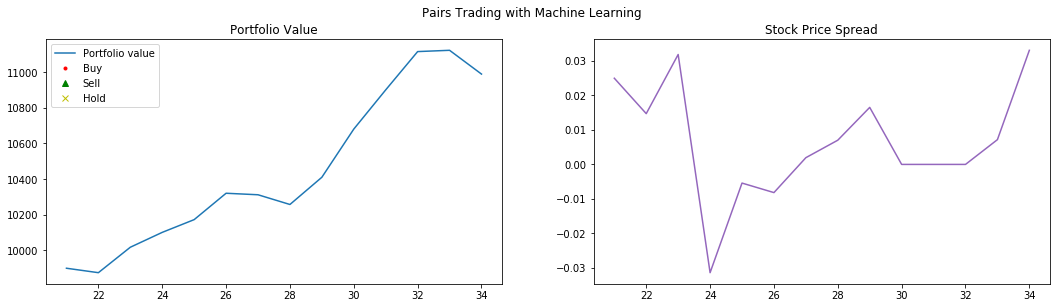

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.2291848  0.22922012 0.22855666]
 [0.33129233 0.3308067  0.33035004]
 [0.3475305  0.34837854 0.347438  ]
 [0.32695085 0.3253662  0.32815713]
 [0.33281967 0.33195505 0.33315566]
 [0.33966422 0.3391753  0.34082335]
 [0.3140583  0.31352496 0.31401318]
 [0.32801157 0.32812214 0.32799867]
 [0.348893   0.34814298 0.3476335 ]
 [0.34645602 0.3464485  0.3470567 ]
 [0.33304644 0.33065712 0.3351086 ]
 [0.33222184 0.331126   0.33305717]
 [0.3195591  0.31974566 0.32002077]
 [0.31860614 0.31846744 0.31847405]], shape=(14, 3), dtype=float32)


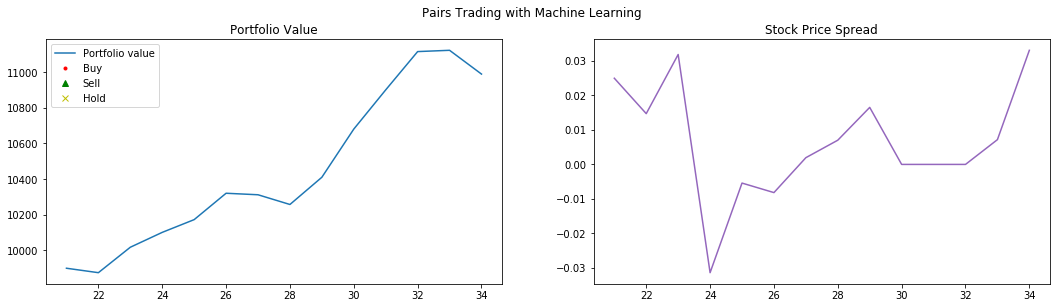

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22888978 0.2289251  0.22826163]
 [0.33129233 0.3308067  0.33035004]
 [0.3475305  0.34837854 0.347438  ]
 [0.32669592 0.32511127 0.32790223]
 [0.332612   0.33174738 0.332948  ]
 [0.33935612 0.33886722 0.34051526]
 [0.31387863 0.31334528 0.3138335 ]
 [0.32801157 0.32812214 0.32799867]
 [0.348893   0.34814298 0.3476335 ]
 [0.3461535  0.346146   0.34675416]
 [0.33284292 0.33045357 0.33490506]
 [0.33201018 0.33091435 0.3328455 ]
 [0.31922472 0.31941128 0.31968638]
 [0.31830755 0.31816882 0.31817546]], shape=(14, 3), dtype=float32)


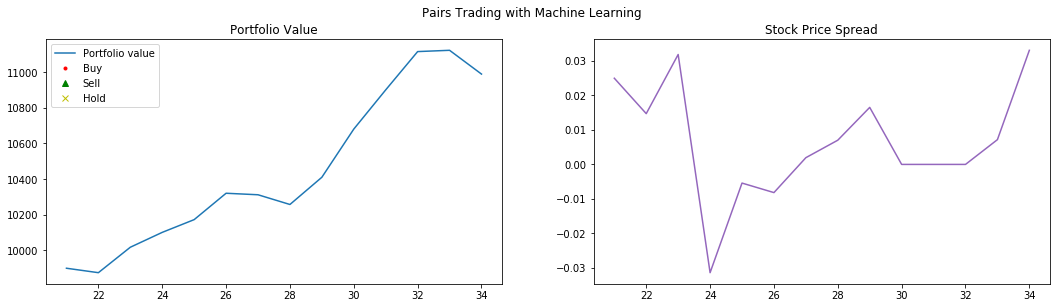

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22838905 0.22842437 0.22776091]
 [0.33129233 0.3308067  0.33035004]
 [0.3475305  0.34837854 0.347438  ]
 [0.32622886 0.3246442  0.32743517]
 [0.3322331  0.33136848 0.3325691 ]
 [0.33881602 0.3383271  0.33997515]
 [0.31346217 0.31292883 0.31341705]
 [0.32801157 0.32812214 0.32799867]
 [0.348893   0.34814298 0.3476335 ]
 [0.34563825 0.34563074 0.3462389 ]
 [0.33240432 0.33001497 0.33446646]
 [0.3316147  0.33051887 0.33245003]
 [0.31870893 0.3188955  0.3191706 ]
 [0.31779346 0.31765473 0.31766137]], shape=(14, 3), dtype=float32)


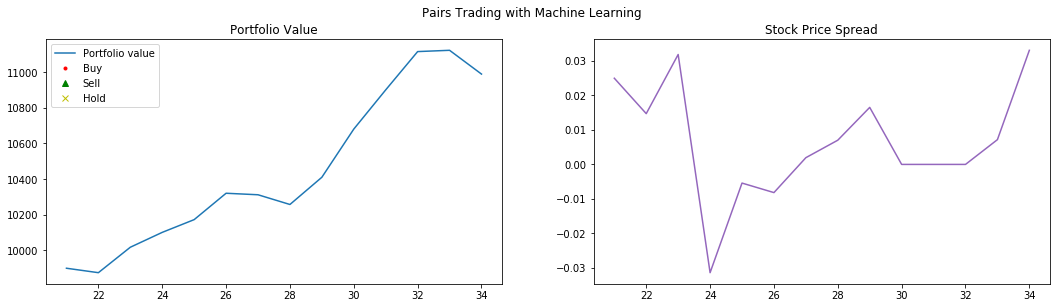

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22809651 0.22813183 0.22746837]
 [0.33129233 0.3308067  0.33035004]
 [0.3475305  0.34837854 0.347438  ]
 [0.3259491  0.32436445 0.3271554 ]
 [0.33204806 0.33118343 0.33238405]
 [0.33851844 0.33802953 0.33967757]
 [0.31321466 0.31268132 0.31316954]
 [0.32801157 0.32812214 0.32799867]
 [0.34882164 0.34807163 0.34756216]
 [0.34533837 0.34533086 0.34593904]
 [0.33213022 0.32974088 0.33419237]
 [0.33137795 0.33028212 0.33221328]
 [0.31842747 0.31861404 0.31888914]
 [0.31750023 0.3173615  0.31736815]], shape=(14, 3), dtype=float32)


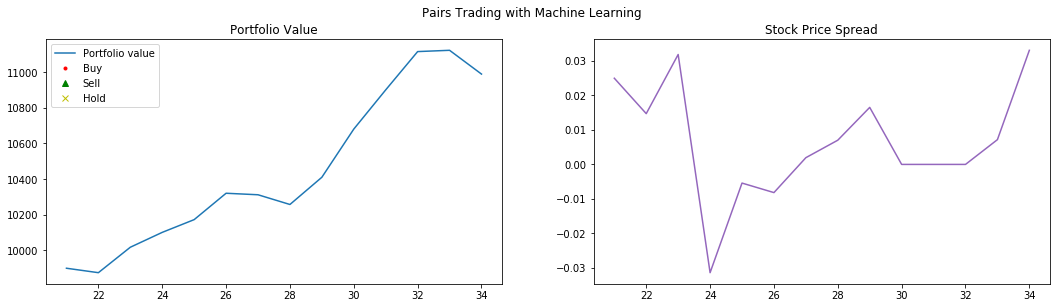

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22876215 0.22879747 0.228134  ]
 [0.33129233 0.3308067  0.33035004]
 [0.3475305  0.34837854 0.347438  ]
 [0.32647407 0.32488942 0.32768038]
 [0.3326287  0.33176407 0.3329647 ]
 [0.33917928 0.33869037 0.3403384 ]
 [0.3137144  0.31318107 0.31366926]
 [0.32801157 0.32812214 0.32799867]
 [0.348893   0.34814298 0.3476335 ]
 [0.34596375 0.34595624 0.3465644 ]
 [0.33259952 0.33021018 0.33466166]
 [0.33177102 0.33067518 0.33260635]
 [0.31884125 0.3190278  0.31930292]
 [0.31817755 0.31803882 0.31804547]], shape=(14, 3), dtype=float32)


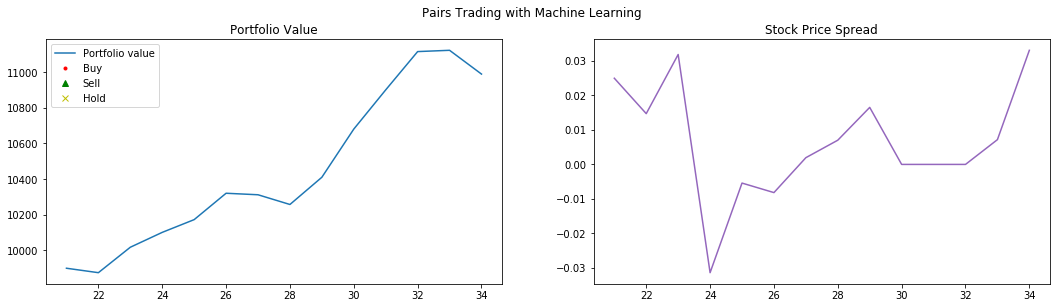

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22925445 0.22928977 0.22862631]
 [0.33129233 0.3308067  0.33035004]
 [0.34753048 0.3483785  0.347438  ]
 [0.32689047 0.32530582 0.32809678]
 [0.33307242 0.33220783 0.33340842]
 [0.339688   0.3391991  0.34084713]
 [0.3140876  0.31355423 0.31404245]
 [0.32801157 0.32812214 0.32799867]
 [0.348893   0.34814298 0.3476335 ]
 [0.3464708  0.3464633  0.34707147]
 [0.33294463 0.33055532 0.33500677]
 [0.3320822  0.33098638 0.33291754]
 [0.31928512 0.3194717  0.3197468 ]
 [0.31868196 0.31854323 0.31854987]], shape=(14, 3), dtype=float32)


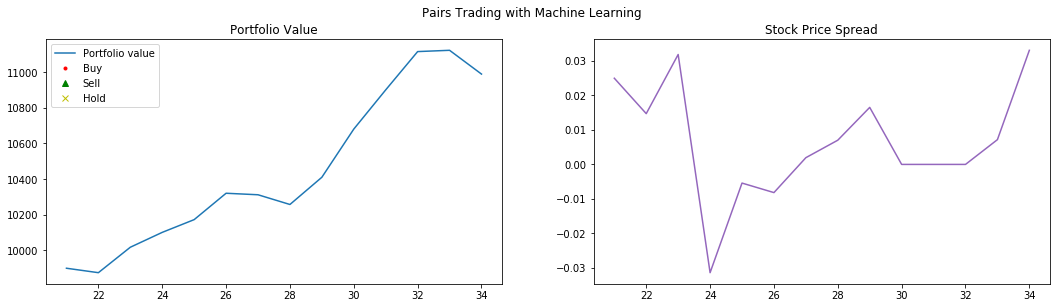

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22919516 0.22923048 0.22856702]
 [0.33129233 0.3308067  0.33035004]
 [0.3475305  0.34837854 0.347438  ]
 [0.326841   0.32525635 0.32804728]
 [0.33303896 0.33217436 0.33337495]
 [0.33963105 0.33914214 0.34079018]
 [0.31400082 0.31346744 0.31395566]
 [0.32801157 0.32812214 0.32799867]
 [0.348893   0.34814298 0.3476335 ]
 [0.34637582 0.3463683  0.3469765 ]
 [0.33283174 0.3304424  0.33489388]
 [0.33203843 0.3309426  0.33287376]
 [0.31915882 0.31934538 0.3196205 ]
 [0.31862646 0.31848773 0.31849438]], shape=(14, 3), dtype=float32)


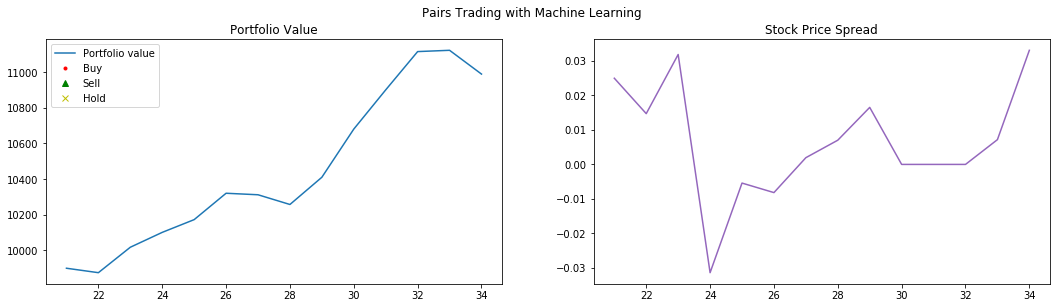

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22868997 0.22872528 0.22806183]
 [0.33129233 0.3308067  0.33035004]
 [0.34753048 0.3483785  0.347438  ]
 [0.3264159  0.32483125 0.32762218]
 [0.3326166  0.331752   0.3329526 ]
 [0.3391324  0.3386435  0.34029153]
 [0.31356794 0.31303456 0.3135228 ]
 [0.32801157 0.32812214 0.32799867]
 [0.348893   0.34814298 0.3476335 ]
 [0.34581977 0.34581226 0.34642044]
 [0.33237353 0.3299842  0.33443567]
 [0.33172455 0.33062872 0.33255988]
 [0.31858563 0.3187722  0.3190473 ]
 [0.31810817 0.31796944 0.3179761 ]], shape=(14, 3), dtype=float32)


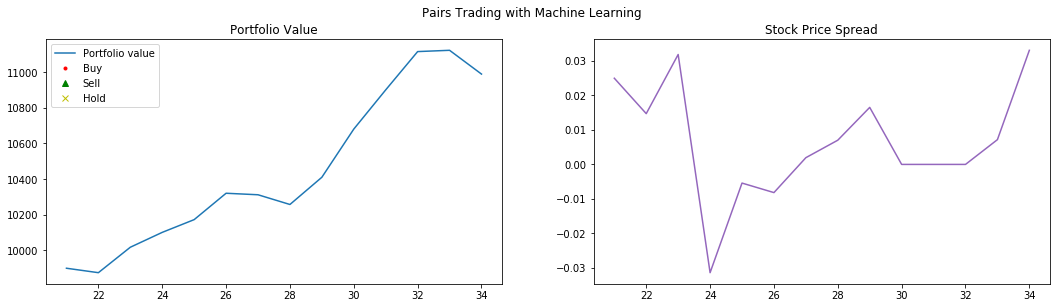

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22817466 0.22820997 0.22754651]
 [0.33129233 0.3308067  0.33035004]
 [0.34753048 0.3483785  0.347438  ]
 [0.32601547 0.32443082 0.32722175]
 [0.33222368 0.3313591  0.33255967]
 [0.33867806 0.33818915 0.3398372 ]
 [0.3132016  0.31266823 0.31315646]
 [0.32801157 0.32812214 0.32799867]
 [0.348893   0.34814298 0.3476335 ]
 [0.3452958  0.34528828 0.34589645]
 [0.33200702 0.32961768 0.33406916]
 [0.33146626 0.33037043 0.3323016 ]
 [0.31808066 0.31826723 0.31854233]
 [0.31758577 0.31744704 0.31745368]], shape=(14, 3), dtype=float32)


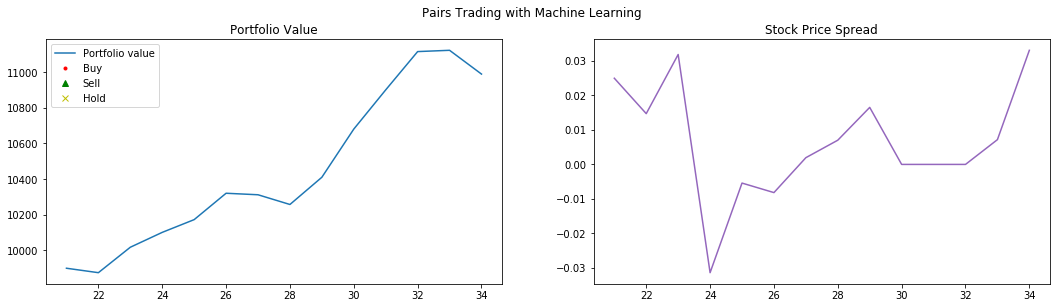

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22807917 0.22811449 0.22745103]
 [0.33129233 0.3308067  0.33035004]
 [0.34753048 0.3483785  0.347438  ]
 [0.32595927 0.32437462 0.32716554]
 [0.33222267 0.33135808 0.33255866]
 [0.3386942  0.3382053  0.33985335]
 [0.3132872  0.31275383 0.31324205]
 [0.32801157 0.32812214 0.32799867]
 [0.34886488 0.34811488 0.3476054 ]
 [0.34514284 0.34513533 0.3457435 ]
 [0.33205175 0.3296624  0.3341139 ]
 [0.33151922 0.3304234  0.33235455]
 [0.31804955 0.3182361  0.31851122]
 [0.31749877 0.31736004 0.3173667 ]], shape=(14, 3), dtype=float32)


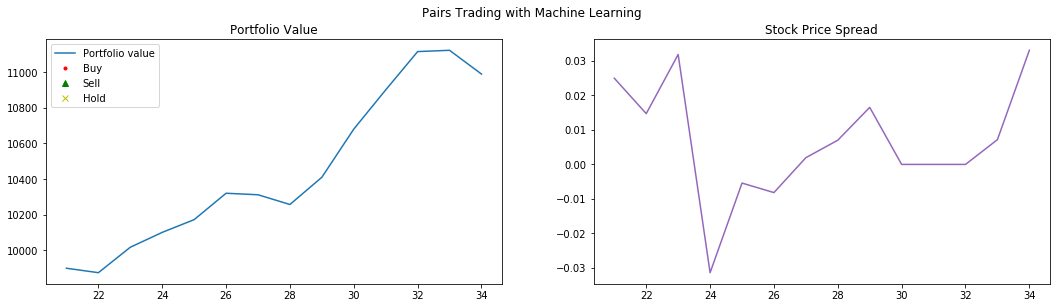

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22894233 0.22897765 0.22831419]
 [0.33129233 0.3308067  0.33035004]
 [0.34753048 0.3483785  0.347438  ]
 [0.32668418 0.32509953 0.32789046]
 [0.33298257 0.33211797 0.33331856]
 [0.33963877 0.3391499  0.34079793]
 [0.31409085 0.31355748 0.3140457 ]
 [0.32801157 0.32812214 0.32799867]
 [0.348893   0.34814298 0.3476335 ]
 [0.34595793 0.34595042 0.3465586 ]
 [0.33281764 0.3304283  0.3348798 ]
 [0.33213884 0.33104303 0.33297417]
 [0.31885806 0.31904462 0.31931973]
 [0.3183729  0.31823418 0.3182408 ]], shape=(14, 3), dtype=float32)


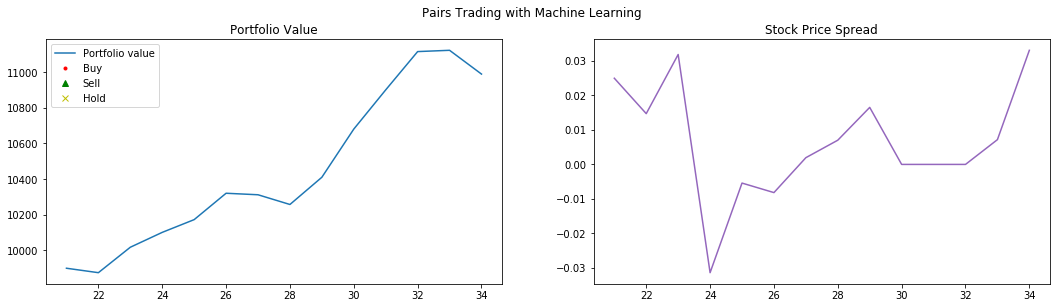

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22935611 0.22939143 0.22872797]
 [0.33129233 0.3308067  0.33035004]
 [0.34753048 0.3483785  0.347438  ]
 [0.3270367  0.3254521  0.328243  ]
 [0.33329204 0.33242744 0.33362803]
 [0.3400508  0.3395619  0.34120995]
 [0.3144561  0.31392273 0.31441095]
 [0.3280116  0.32812214 0.32799867]
 [0.348893   0.34814298 0.3476335 ]
 [0.34637213 0.34636462 0.3469728 ]
 [0.33315396 0.3307646  0.3352161 ]
 [0.33238068 0.33128488 0.333216  ]
 [0.31921625 0.3194028  0.3196779 ]
 [0.31879157 0.31865284 0.31865945]], shape=(14, 3), dtype=float32)


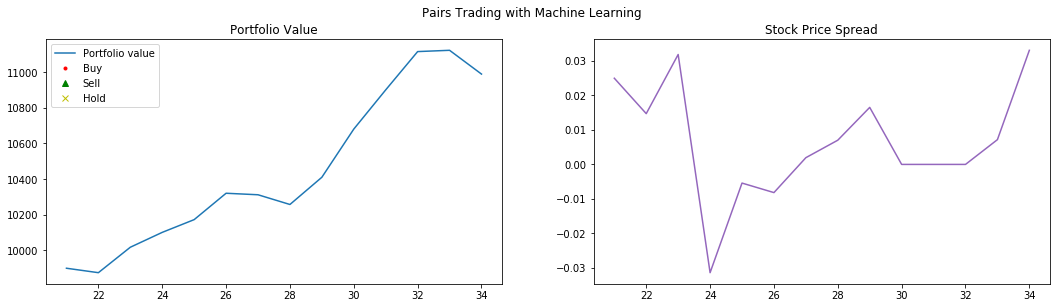

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22909425 0.22912957 0.22846611]
 [0.33129233 0.3308067  0.33035004]
 [0.34753048 0.3483785  0.347438  ]
 [0.32678074 0.32519612 0.32798702]
 [0.33296087 0.33209628 0.33329687]
 [0.33967972 0.33919084 0.34083888]
 [0.31415173 0.31361836 0.31410658]
 [0.3280116  0.32812214 0.32799867]
 [0.348893   0.34814298 0.3476335 ]
 [0.34608907 0.34608158 0.34668976]
 [0.33282745 0.3304381  0.3348896 ]
 [0.33205968 0.33096388 0.332895  ]
 [0.31875712 0.31894368 0.31921878]
 [0.31852585 0.31838712 0.31839374]], shape=(14, 3), dtype=float32)


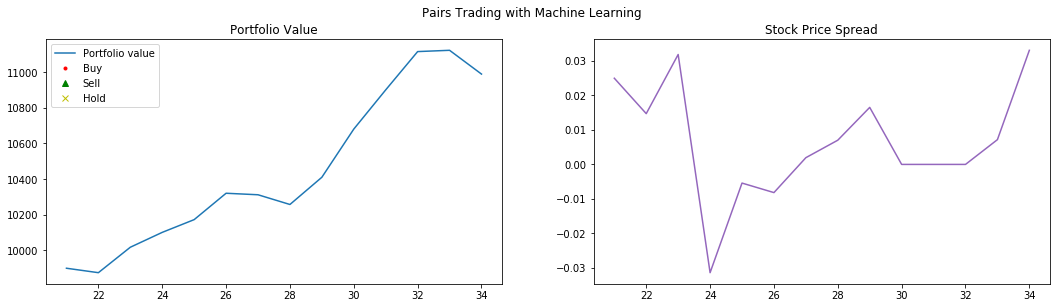

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22850654 0.22854185 0.22787839]
 [0.33129233 0.3308067  0.33035004]
 [0.34753048 0.3483785  0.347438  ]
 [0.32624757 0.32466295 0.32745385]
 [0.33234635 0.33148178 0.33268237]
 [0.338953   0.3384641  0.34011215]
 [0.3135257  0.31299233 0.31348056]
 [0.3280116  0.32812214 0.32799867]
 [0.348893   0.34814298 0.3476335 ]
 [0.34547752 0.34547004 0.34607822]
 [0.3321801  0.32979077 0.33424225]
 [0.33147854 0.33038276 0.3323139 ]
 [0.31813607 0.31832263 0.31859773]
 [0.31792602 0.3177873  0.3177939 ]], shape=(14, 3), dtype=float32)


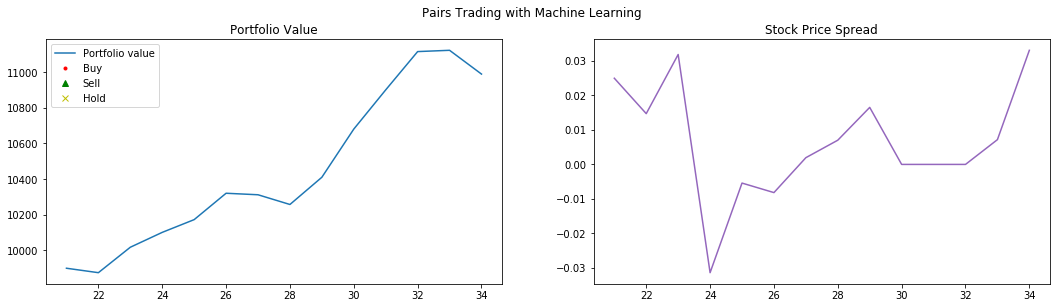

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22817521 0.22821052 0.22754706]
 [0.33129233 0.3308067  0.33035004]
 [0.34753048 0.3483785  0.347438  ]
 [0.32595357 0.32436895 0.32715985]
 [0.33199155 0.331127   0.33232754]
 [0.33856162 0.33807275 0.3397208 ]
 [0.31314114 0.31260777 0.31309596]
 [0.3280116  0.32812214 0.32799867]
 [0.348893   0.34814298 0.3476335 ]
 [0.34509265 0.34508517 0.34569335]
 [0.33177724 0.3293879  0.3338394 ]
 [0.3311407  0.3300449  0.33197603]
 [0.31779996 0.31798652 0.31826162]
 [0.31760293 0.3174642  0.31747082]], shape=(14, 3), dtype=float32)


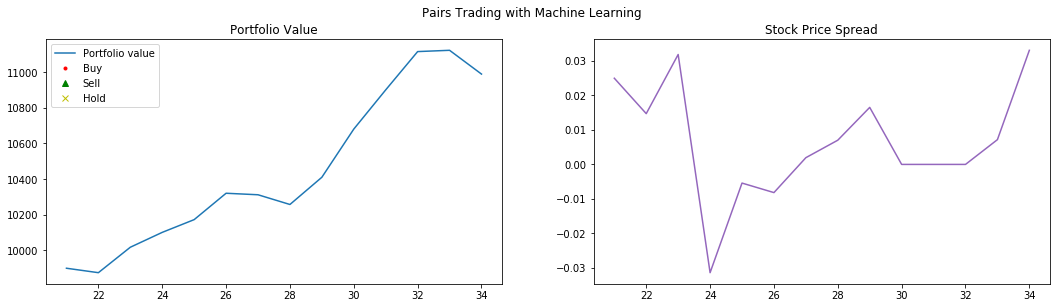

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.2284128  0.22844812 0.22778466]
 [0.33129233 0.3308067  0.33035004]
 [0.34753048 0.3483785  0.347438  ]
 [0.3261533  0.3245687  0.3273596 ]
 [0.33216402 0.33129945 0.33250004]
 [0.33883417 0.3383453  0.33999333]
 [0.31330225 0.31276888 0.31325707]
 [0.3280116  0.32812214 0.32799867]
 [0.348893   0.34814298 0.34763354]
 [0.34521738 0.3452099  0.34581807]
 [0.33189848 0.32950914 0.33396062]
 [0.33127338 0.33017758 0.3321087 ]
 [0.3179247  0.31811127 0.31838638]
 [0.31786788 0.31772915 0.31773576]], shape=(14, 3), dtype=float32)


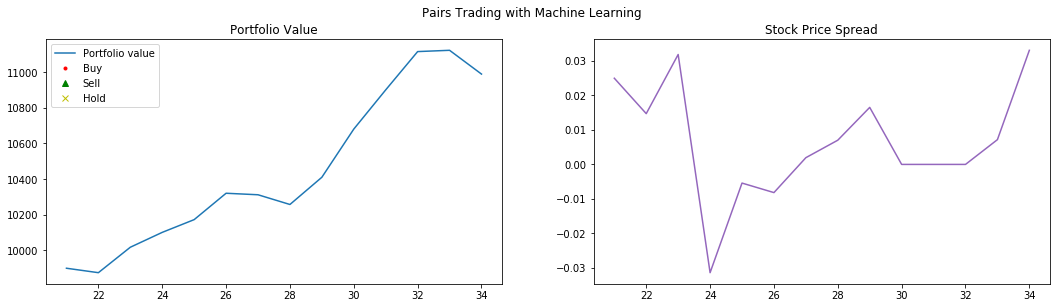

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22895621 0.22899152 0.22832806]
 [0.33129233 0.3308067  0.33035004]
 [0.34753048 0.3483785  0.347438  ]
 [0.32665342 0.3250688  0.3278597 ]
 [0.33260983 0.33174527 0.33294585]
 [0.3394213  0.33893242 0.34058046]
 [0.31377688 0.3132435  0.3137317 ]
 [0.3280116  0.32812214 0.32799867]
 [0.348893   0.34814298 0.34763354]
 [0.3456519  0.3456444  0.3462526 ]
 [0.3323372  0.32994786 0.33439934]
 [0.33171648 0.33062068 0.3325518 ]
 [0.3183952  0.31858176 0.31885687]
 [0.31843445 0.31829572 0.31830233]], shape=(14, 3), dtype=float32)


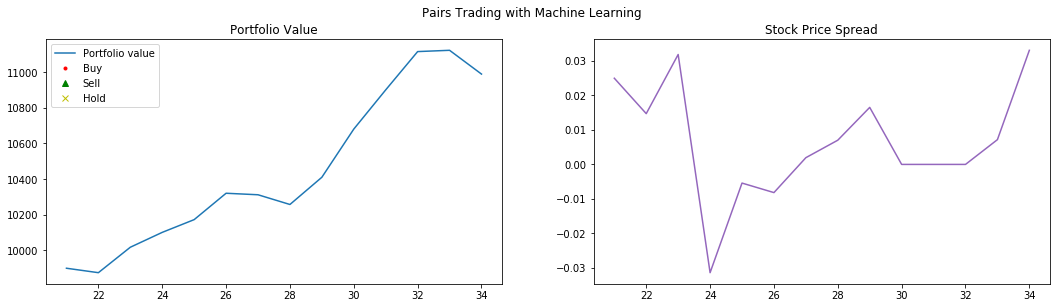

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22929281 0.22932813 0.22866467]
 [0.33129233 0.3308067  0.33035004]
 [0.34753048 0.3483785  0.347438  ]
 [0.32700467 0.32542005 0.32821095]
 [0.33291414 0.33204958 0.33325016]
 [0.33980724 0.33931836 0.3409664 ]
 [0.3141206  0.31358722 0.3140754 ]
 [0.3280116  0.32812214 0.32799867]
 [0.348893   0.34814298 0.34763354]
 [0.34591192 0.34590444 0.34651262]
 [0.3326528  0.33026347 0.33471495]
 [0.33209875 0.33100295 0.33293408]
 [0.3187342  0.31892076 0.31919587]
 [0.31880525 0.31866652 0.31867313]], shape=(14, 3), dtype=float32)


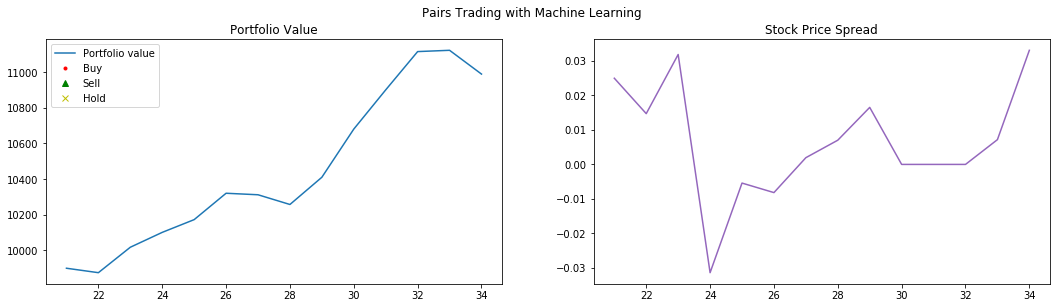

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22913918 0.2291745  0.22851104]
 [0.33129233 0.3308067  0.33035004]
 [0.34753048 0.3483785  0.347438  ]
 [0.32694545 0.32536083 0.32815173]
 [0.33284295 0.33197838 0.33317897]
 [0.33971494 0.33922607 0.3408741 ]
 [0.31409135 0.31355798 0.31404617]
 [0.3280116  0.32812214 0.32799867]
 [0.34889287 0.34814286 0.34763342]
 [0.3456907  0.3456832  0.3462914 ]
 [0.3326035  0.33021417 0.33466566]
 [0.33217013 0.33107433 0.33300546]
 [0.31861258 0.31879914 0.31907424]
 [0.31869733 0.3185586  0.31856522]], shape=(14, 3), dtype=float32)


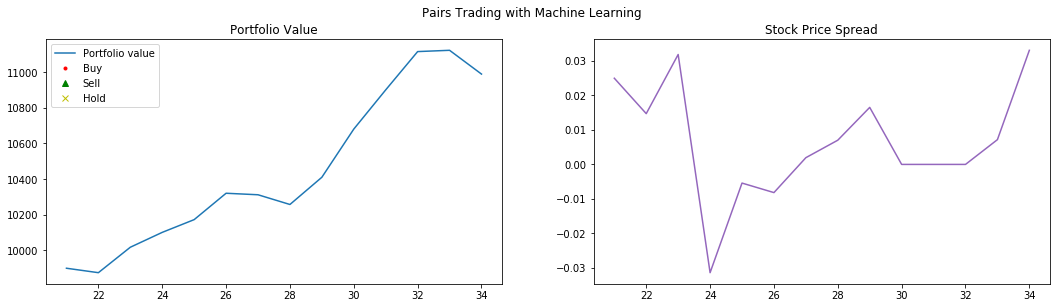

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.2286056  0.22864091 0.22797745]
 [0.33129233 0.3308067  0.33035004]
 [0.34753048 0.3483785  0.347438  ]
 [0.32656622 0.3249816  0.3277725 ]
 [0.33246958 0.33160502 0.3328056 ]
 [0.33921793 0.33872905 0.3403771 ]
 [0.31376958 0.3132362  0.3137244 ]
 [0.3280116  0.32812214 0.32799867]
 [0.34889287 0.34814286 0.34763342]
 [0.34515196 0.34514445 0.34575266]
 [0.3322522  0.32986286 0.33431435]
 [0.33194903 0.33085322 0.33278435]
 [0.31817803 0.3183646  0.3186397 ]
 [0.3182222  0.31808347 0.31809008]], shape=(14, 3), dtype=float32)


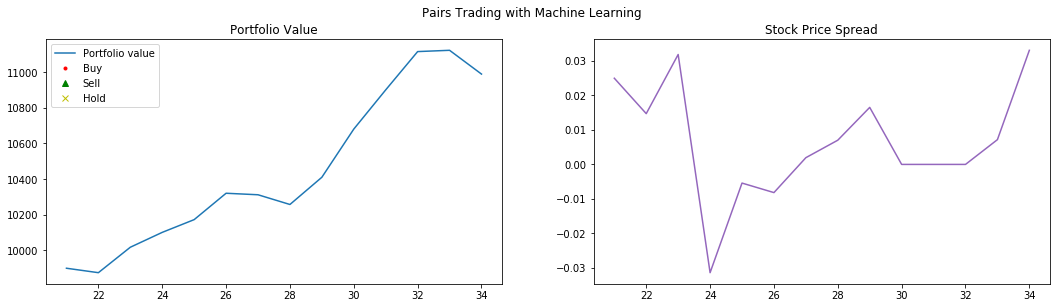

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22816902 0.22820437 0.22754091]
 [0.33129233 0.3308067  0.33035004]
 [0.34753048 0.3483785  0.347438  ]
 [0.32624042 0.3246558  0.3274467 ]
 [0.33220196 0.3313374  0.33253798]
 [0.33882812 0.33833924 0.33998728]
 [0.31355178 0.3130184  0.3135066 ]
 [0.3280116  0.32812214 0.32799867]
 [0.34889287 0.34814286 0.34763342]
 [0.34475034 0.34474283 0.34535104]
 [0.3320087  0.32961935 0.33407083]
 [0.33174336 0.33064756 0.3325787 ]
 [0.31782082 0.31800738 0.31828249]
 [0.31783354 0.3176948  0.31770143]], shape=(14, 3), dtype=float32)


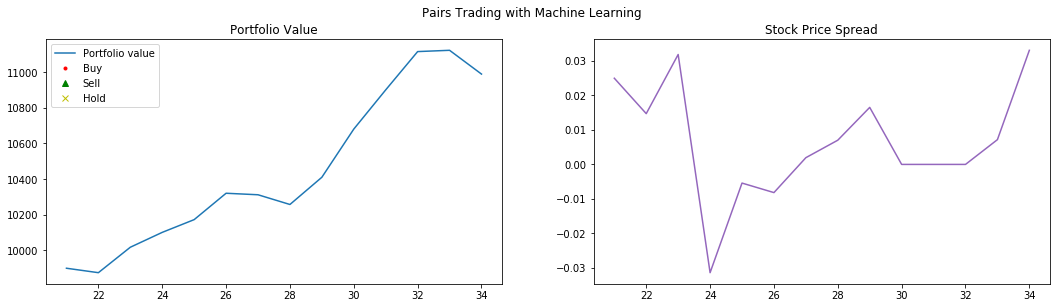

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.2281892  0.22822455 0.22756109]
 [0.33129233 0.3308067  0.33035004]
 [0.34753048 0.3483785  0.347438  ]
 [0.32624358 0.32465896 0.32744986]
 [0.33227867 0.3314141  0.3326147 ]
 [0.3388985  0.33840963 0.34005767]
 [0.31368697 0.3131536  0.3136418 ]
 [0.3280116  0.32812214 0.32799867]
 [0.34889287 0.34814286 0.34763342]
 [0.34473675 0.34472924 0.34533745]
 [0.3321084  0.32971907 0.33417055]
 [0.33178514 0.33068934 0.33262047]
 [0.31780666 0.31799322 0.3182683 ]
 [0.31787065 0.31773192 0.31773853]], shape=(14, 3), dtype=float32)


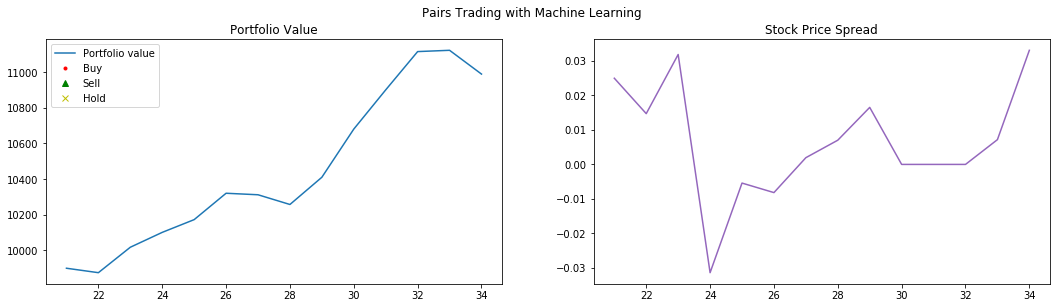

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.2286178  0.22865315 0.22798969]
 [0.33129233 0.3308067  0.33035004]
 [0.34753048 0.3483785  0.347438  ]
 [0.32655993 0.3249753  0.3277662 ]
 [0.33262485 0.3317603  0.33296087]
 [0.3393679  0.33887902 0.34052706]
 [0.31406313 0.31352976 0.31401795]
 [0.3280116  0.32812214 0.32799867]
 [0.34889287 0.34814286 0.34763342]
 [0.34508598 0.34507847 0.34568667]
 [0.33244154 0.3300522  0.33450368]
 [0.3320572  0.3309614  0.33289254]
 [0.31803468 0.31822124 0.31849635]
 [0.3183079  0.31816918 0.3181758 ]], shape=(14, 3), dtype=float32)


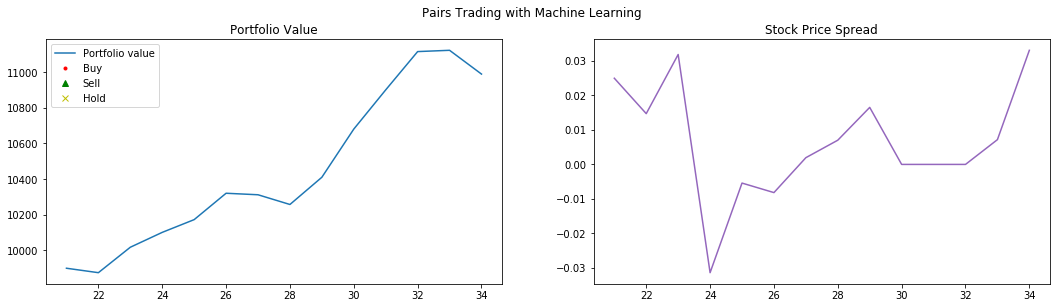

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22900492 0.22904027 0.2283768 ]
 [0.33129233 0.3308067  0.33035004]
 [0.34753048 0.3483785  0.347438  ]
 [0.32684666 0.32526204 0.32805294]
 [0.33287388 0.33200932 0.3332099 ]
 [0.33974445 0.33925557 0.3409036 ]
 [0.3143095  0.31377614 0.31426433]
 [0.3280116  0.32812214 0.32799867]
 [0.34889287 0.34814286 0.34763342]
 [0.34542203 0.34541452 0.34602273]
 [0.33263737 0.33024803 0.3346995 ]
 [0.3322496  0.3311538  0.33308494]
 [0.31834197 0.31852853 0.31880367]
 [0.31869116 0.31855243 0.31855905]], shape=(14, 3), dtype=float32)


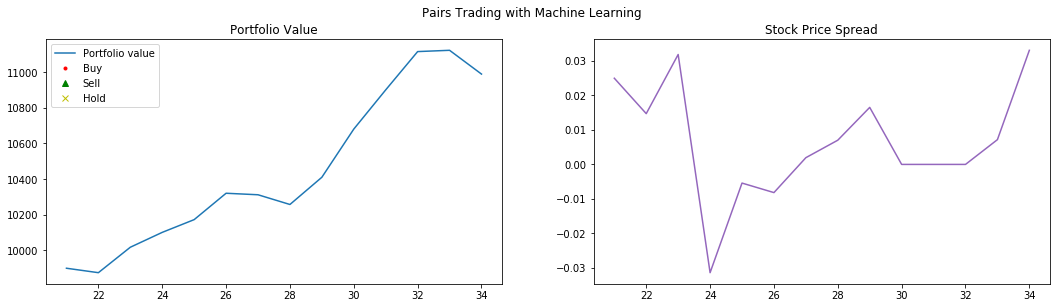

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22897911 0.22901446 0.228351  ]
 [0.33129233 0.3308067  0.33035004]
 [0.34753045 0.3483785  0.347438  ]
 [0.32682443 0.32523984 0.3280307 ]
 [0.3327785  0.33191395 0.33311453]
 [0.33966488 0.339176   0.34082404]
 [0.31416368 0.3136303  0.3141185 ]
 [0.3280116  0.32812214 0.32799867]
 [0.34889287 0.34814286 0.34763342]
 [0.34536767 0.34536016 0.34596837]
 [0.3324545  0.33006516 0.33451664]
 [0.3321622  0.3310664  0.33299753]
 [0.318285   0.31847155 0.31874666]
 [0.31868023 0.3185415  0.3185481 ]], shape=(14, 3), dtype=float32)


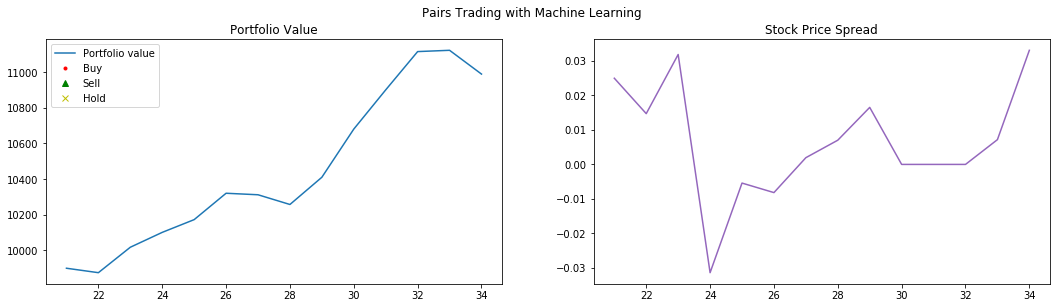

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22868615 0.2287215  0.22805804]
 [0.33129233 0.3308067  0.33035004]
 [0.34753045 0.3483785  0.347438  ]
 [0.32657355 0.32498896 0.32777983]
 [0.3324881  0.33162352 0.3328241 ]
 [0.33931866 0.3388298  0.34047782]
 [0.31383952 0.31330615 0.31379434]
 [0.3280116  0.32812214 0.32799867]
 [0.34889287 0.34814286 0.34763342]
 [0.34505668 0.34504917 0.34565738]
 [0.33213085 0.32974148 0.334193  ]
 [0.3319306  0.3308348  0.33276594]
 [0.31793764 0.3181242  0.3183993 ]
 [0.3184008  0.31826207 0.3182687 ]], shape=(14, 3), dtype=float32)


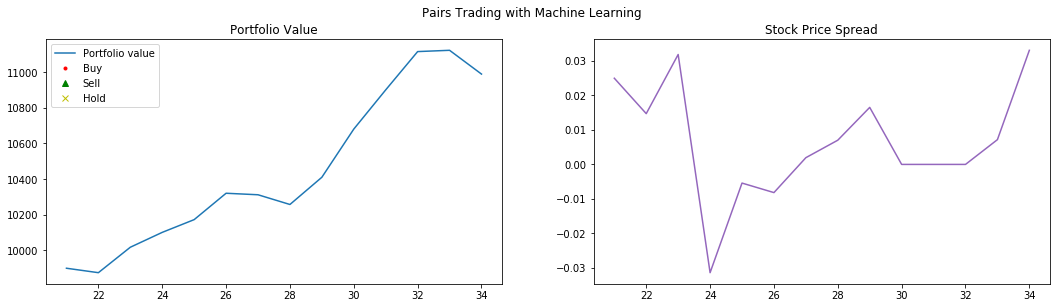

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22846405 0.2284994  0.22783594]
 [0.33129233 0.3308067  0.33035004]
 [0.34753045 0.3483785  0.347438  ]
 [0.3264024  0.3248178  0.32760867]
 [0.3322959  0.33143133 0.33263192]
 [0.3390986  0.33860973 0.34025776]
 [0.3136527  0.31311932 0.3136075 ]
 [0.3280116  0.32812214 0.32799867]
 [0.34889287 0.34814286 0.34763342]
 [0.34483325 0.34482574 0.34543395]
 [0.33192343 0.32953408 0.33398557]
 [0.3318026  0.33070683 0.33263797]
 [0.31765124 0.3178378  0.3181129 ]
 [0.3181701  0.31803137 0.318038  ]], shape=(14, 3), dtype=float32)


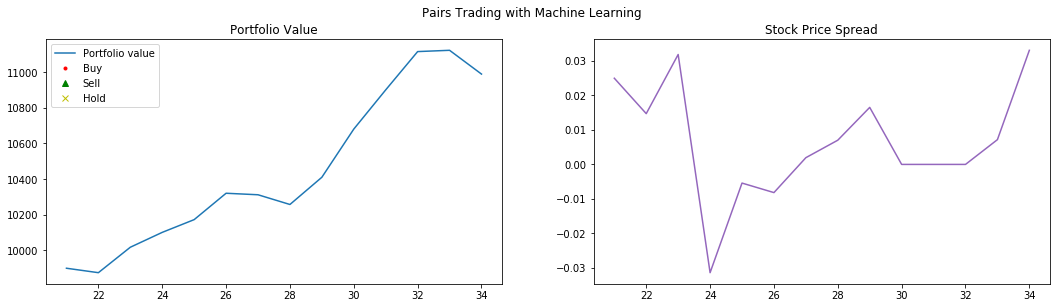

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22855312 0.22858846 0.227925  ]
 [0.33129233 0.3308067  0.33035004]
 [0.34753048 0.3483785  0.347438  ]
 [0.32648447 0.32489988 0.32769075]
 [0.33238155 0.33151698 0.33271757]
 [0.33924153 0.33875266 0.3404007 ]
 [0.31379816 0.3132648  0.31375298]
 [0.3280116  0.32812214 0.32799867]
 [0.34889287 0.34814286 0.34763342]
 [0.34489605 0.34488854 0.34549674]
 [0.33200908 0.32961974 0.33407122]
 [0.33190486 0.33080906 0.3327402 ]
 [0.31763425 0.31782082 0.31809592]
 [0.31822494 0.3180862  0.31809282]], shape=(14, 3), dtype=float32)


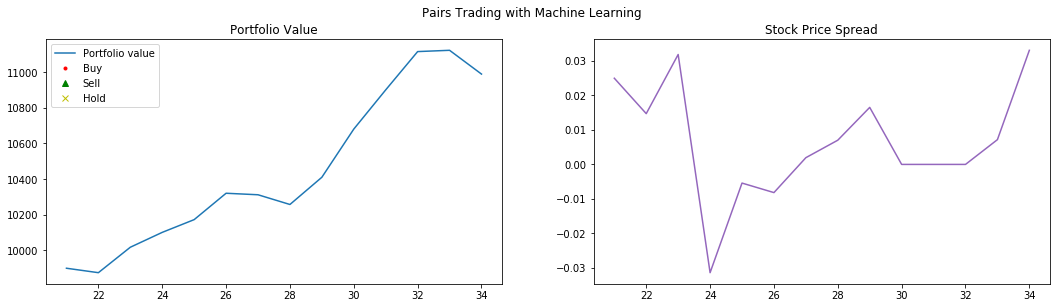

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22882459 0.2288599  0.22819644]
 [0.33129233 0.3308067  0.33035004]
 [0.34753048 0.3483785  0.347438  ]
 [0.32669744 0.32511285 0.32790372]
 [0.33265322 0.33178866 0.33298925]
 [0.33962375 0.33913487 0.3407829 ]
 [0.31415182 0.31361845 0.31410664]
 [0.3280116  0.32812214 0.32799867]
 [0.34889287 0.34814286 0.34763342]
 [0.34513187 0.34512436 0.34573257]
 [0.33231866 0.32992932 0.3343808 ]
 [0.33214542 0.33104962 0.33298075]
 [0.31784174 0.3180283  0.3183034 ]
 [0.31845346 0.31831473 0.31832135]], shape=(14, 3), dtype=float32)


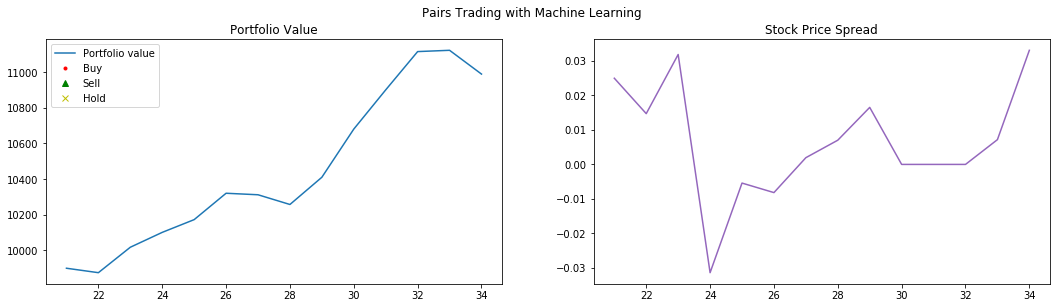

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22895706 0.22899237 0.22832891]
 [0.33129233 0.3308067  0.33035004]
 [0.34753048 0.3483785  0.347438  ]
 [0.32679912 0.32521453 0.3280054 ]
 [0.33279568 0.3319311  0.3331317 ]
 [0.3398215  0.3393326  0.34098065]
 [0.31435293 0.31381956 0.31430775]
 [0.3280116  0.32812214 0.32799867]
 [0.34889287 0.34814286 0.34763342]
 [0.34523416 0.34522665 0.34583485]
 [0.3325083  0.33011895 0.33457044]
 [0.332261   0.3311652  0.33309633]
 [0.3179251  0.31811166 0.31838676]
 [0.31856355 0.31842482 0.31843144]], shape=(14, 3), dtype=float32)


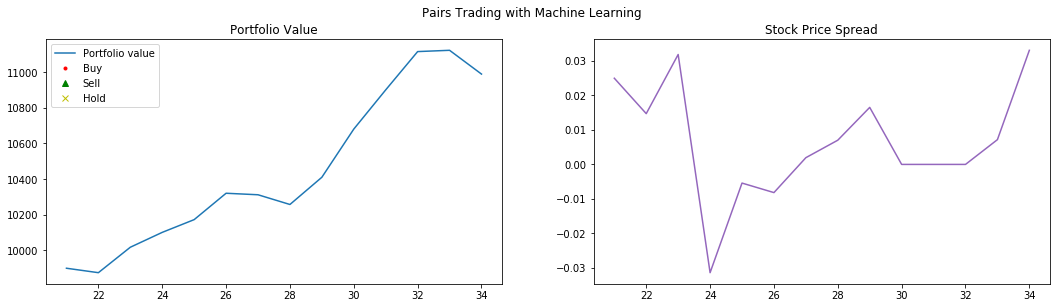

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22883223 0.22886755 0.22820409]
 [0.33129233 0.3308067  0.33035004]
 [0.34753048 0.3483785  0.347438  ]
 [0.3267047  0.32512012 0.327911  ]
 [0.33268544 0.33182088 0.33302146]
 [0.33969972 0.33921084 0.34085888]
 [0.31425977 0.3137264  0.3142146 ]
 [0.3280116  0.32812214 0.32799867]
 [0.34889287 0.34814286 0.34763342]
 [0.345103   0.3450955  0.3457037 ]
 [0.332382   0.32999265 0.33444414]
 [0.33215183 0.33105603 0.33298716]
 [0.317753   0.31793955 0.31821465]
 [0.3184391  0.31830037 0.31830698]], shape=(14, 3), dtype=float32)


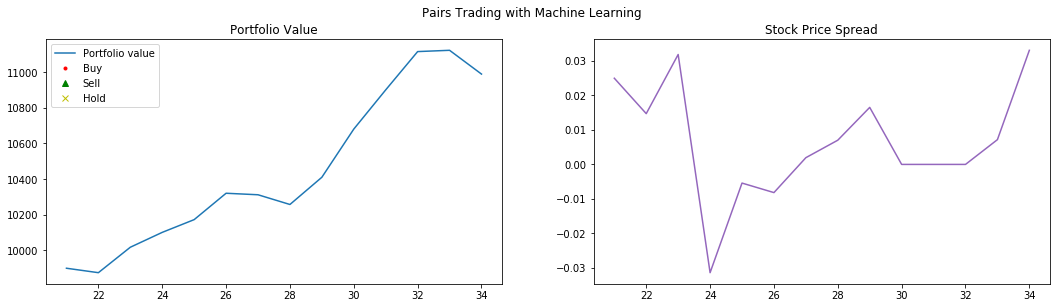

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22860575 0.22864106 0.2279776 ]
 [0.33129233 0.3308067  0.33035004]
 [0.34753048 0.3483785  0.347438  ]
 [0.32654512 0.32496053 0.3277514 ]
 [0.33244246 0.3315779  0.33277848]
 [0.3394101  0.33892122 0.34056926]
 [0.3139807  0.31344733 0.31393552]
 [0.3280116  0.32812214 0.32799867]
 [0.34889287 0.34814286 0.34763342]
 [0.34488058 0.34487307 0.34548128]
 [0.3320497  0.32966036 0.33411184]
 [0.33192435 0.33082855 0.33275968]
 [0.31745407 0.31764063 0.31791574]
 [0.31824365 0.31810492 0.31811154]], shape=(14, 3), dtype=float32)


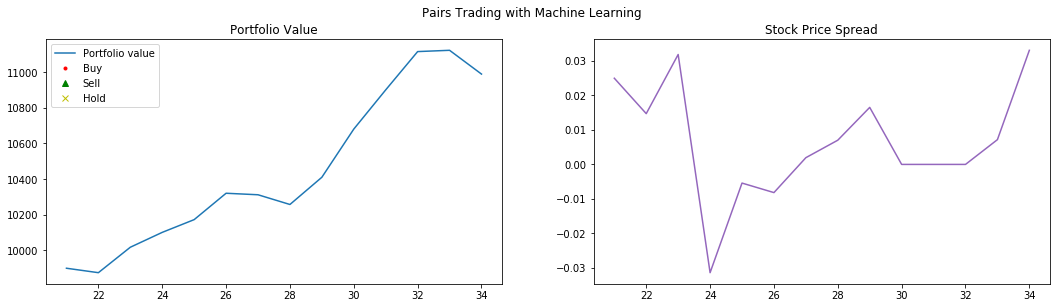

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22854054 0.22857586 0.2279124 ]
 [0.33129233 0.3308067  0.33035004]
 [0.34753048 0.3483785  0.347438  ]
 [0.32651487 0.32493028 0.32772115]
 [0.3323641  0.33149955 0.33270013]
 [0.33930534 0.33881646 0.3404645 ]
 [0.31384468 0.3133113  0.3137995 ]
 [0.3280116  0.32812214 0.32799867]
 [0.34889287 0.34814286 0.34763342]
 [0.34481275 0.34480524 0.34541345]
 [0.33187526 0.32948592 0.3339374 ]
 [0.3317921  0.33069628 0.33262742]
 [0.3173347  0.31752127 0.31779638]
 [0.31820992 0.3180712  0.3180778 ]], shape=(14, 3), dtype=float32)


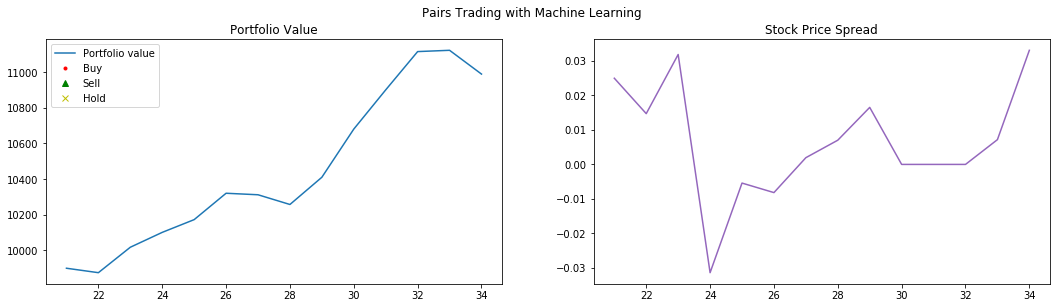

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22872846 0.22876377 0.22810031]
 [0.33129233 0.3308067  0.33035004]
 [0.34753048 0.3483785  0.347438  ]
 [0.3266632  0.3250786  0.32786947]
 [0.33252525 0.3316607  0.33286127]
 [0.3394915  0.3390026  0.34065065]
 [0.31397936 0.313446   0.31393418]
 [0.3280116  0.32812214 0.32799867]
 [0.34889287 0.34814286 0.34763342]
 [0.34497738 0.34496987 0.34557807]
 [0.33197853 0.3295892  0.33404067]
 [0.33184737 0.33075154 0.33268267]
 [0.31744593 0.3176325  0.3179076 ]
 [0.31840324 0.3182645  0.31827113]], shape=(14, 3), dtype=float32)


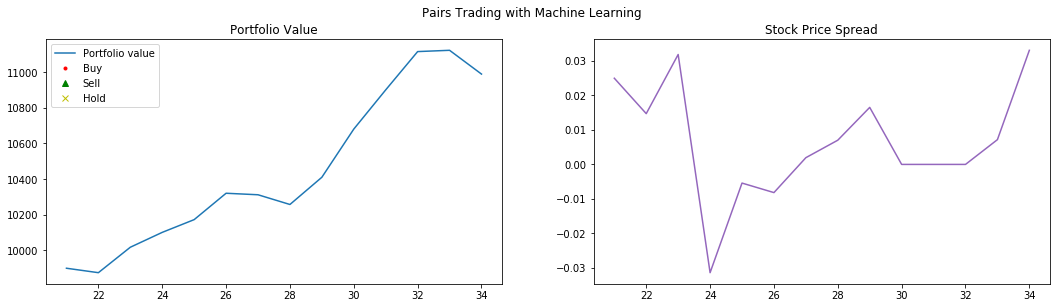

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22895642 0.22899173 0.22832827]
 [0.33129233 0.3308067  0.33035004]
 [0.34753048 0.3483785  0.347438  ]
 [0.3268566  0.32527202 0.3280629 ]
 [0.33272454 0.33185998 0.33306056]
 [0.33971626 0.33922738 0.34087542]
 [0.31417236 0.313639   0.31412718]
 [0.3280116  0.32812214 0.32799867]
 [0.34889287 0.34814286 0.34763342]
 [0.34518355 0.34517604 0.34578425]
 [0.33213642 0.32974708 0.33419856]
 [0.33198208 0.33088627 0.3328174 ]
 [0.3176044  0.31779096 0.31806606]
 [0.31863236 0.31849363 0.31850025]], shape=(14, 3), dtype=float32)


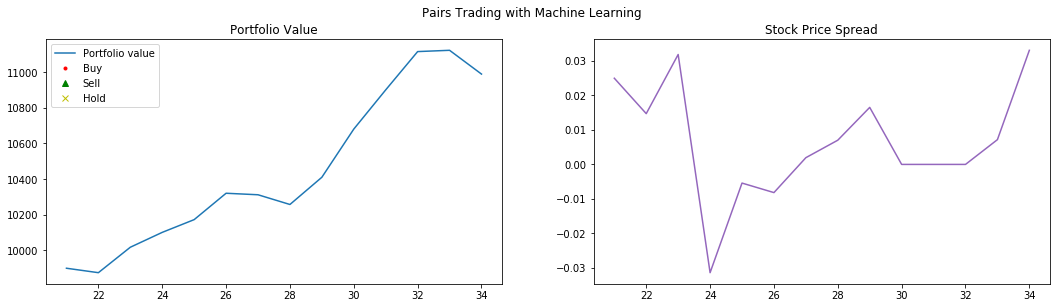

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22901312 0.22904843 0.22838497]
 [0.33129233 0.3308067  0.33035004]
 [0.34753048 0.3483785  0.347438  ]
 [0.32692355 0.32533896 0.32812983]
 [0.33274493 0.33188036 0.33308095]
 [0.3397409  0.33925202 0.34090006]
 [0.31422347 0.3136901  0.3141783 ]
 [0.3280116  0.32812214 0.32799867]
 [0.34889287 0.34814286 0.34763342]
 [0.34522393 0.34521642 0.34582463]
 [0.33215755 0.3297682  0.3342197 ]
 [0.33202934 0.33093357 0.3328647 ]
 [0.31758678 0.31777334 0.31804845]
 [0.31868008 0.31854135 0.31854796]], shape=(14, 3), dtype=float32)


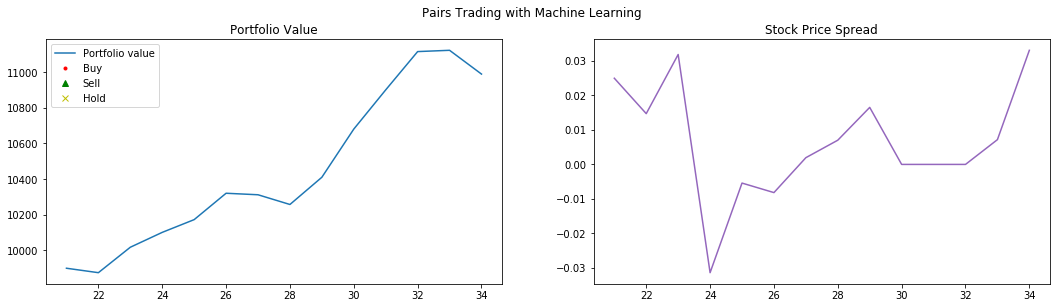

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22889212 0.22892743 0.22826397]
 [0.33129233 0.3308067  0.33035004]
 [0.34753048 0.3483785  0.347438  ]
 [0.32683548 0.3252509  0.32804176]
 [0.3326295  0.33176494 0.33296552]
 [0.33963183 0.33914295 0.340791  ]
 [0.31417972 0.31364635 0.31413454]
 [0.3280116  0.32812214 0.32799867]
 [0.34889287 0.34814286 0.34763342]
 [0.3450925  0.345085   0.3456932 ]
 [0.3320787  0.32968935 0.33414084]
 [0.3319798  0.330884   0.33281514]
 [0.31741318 0.31759977 0.31787485]
 [0.31855786 0.31841913 0.31842574]], shape=(14, 3), dtype=float32)


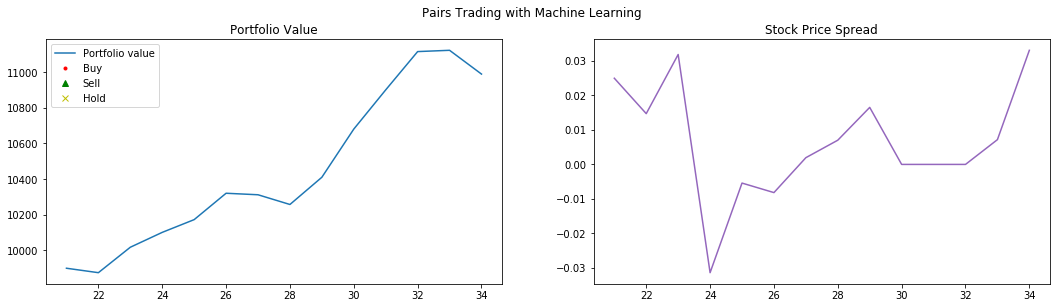

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22877109 0.2288064  0.22814295]
 [0.33129233 0.3308067  0.33035004]
 [0.34753048 0.3483785  0.347438  ]
 [0.32672158 0.325137   0.32792786]
 [0.33251676 0.3316522  0.33285278]
 [0.33951312 0.33902422 0.34067225]
 [0.3141196  0.31358624 0.31407443]
 [0.3280116  0.32812214 0.32799867]
 [0.34889287 0.34814286 0.34763342]
 [0.34495184 0.34494433 0.34555253]
 [0.3319971  0.32960775 0.33405924]
 [0.33195475 0.33085895 0.33279008]
 [0.31721473 0.3174013  0.31767637]
 [0.31841576 0.31827703 0.31828365]], shape=(14, 3), dtype=float32)


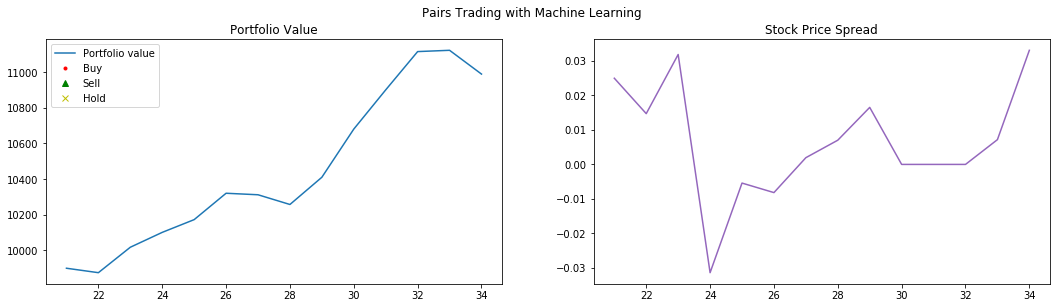

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.228755   0.22879031 0.22812685]
 [0.33129233 0.3308067  0.33035004]
 [0.34753048 0.3483785  0.347438  ]
 [0.32669523 0.32511064 0.3279015 ]
 [0.332509   0.33164445 0.33284503]
 [0.33953962 0.3390507  0.34069875]
 [0.314157   0.31362364 0.31411183]
 [0.3280116  0.32812214 0.32799867]
 [0.34889287 0.34814286 0.3476334 ]
 [0.34489417 0.34488666 0.34549487]
 [0.3320087  0.32961935 0.33407083]
 [0.33201542 0.33091962 0.33285075]
 [0.31716514 0.31735173 0.3176268 ]
 [0.3183974  0.31825867 0.3182653 ]], shape=(14, 3), dtype=float32)


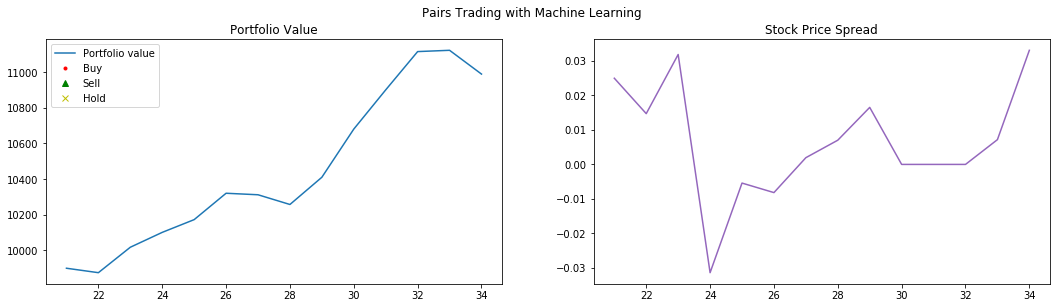

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22884619 0.22888151 0.22821805]
 [0.3312923  0.3308067  0.33035   ]
 [0.34753048 0.3483785  0.347438  ]
 [0.32674736 0.32516277 0.32795364]
 [0.33259657 0.331732   0.3329326 ]
 [0.33967906 0.33919016 0.3408382 ]
 [0.31426686 0.3137335  0.31422168]
 [0.3280116  0.32812214 0.32799867]
 [0.34889287 0.34814286 0.3476334 ]
 [0.34492475 0.3449172  0.3455254 ]
 [0.33206627 0.32967693 0.3341284 ]
 [0.3320873  0.3309915  0.33292264]
 [0.3171997  0.3173863  0.31766137]
 [0.31850988 0.31837115 0.31837776]], shape=(14, 3), dtype=float32)


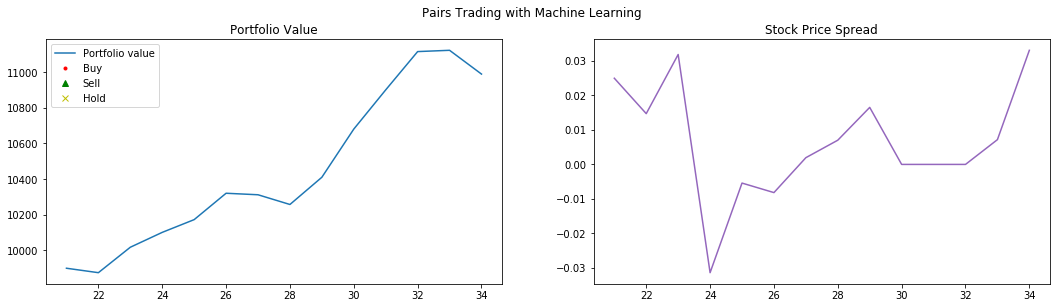

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22890224 0.22893755 0.22827409]
 [0.3312923  0.3308067  0.33035   ]
 [0.34753048 0.3483785  0.347438  ]
 [0.32681346 0.32522887 0.32801974]
 [0.3326291  0.33176455 0.33296514]
 [0.33975732 0.33926842 0.34091645]
 [0.31431562 0.31378224 0.31427044]
 [0.3280116  0.32812214 0.32799867]
 [0.34889287 0.34814286 0.3476334 ]
 [0.34493425 0.3449267  0.34553492]
 [0.33207846 0.32968912 0.3341406 ]
 [0.3321235  0.3310277  0.33295882]
 [0.31722143 0.31740803 0.3176831 ]
 [0.31858942 0.3184507  0.3184573 ]], shape=(14, 3), dtype=float32)


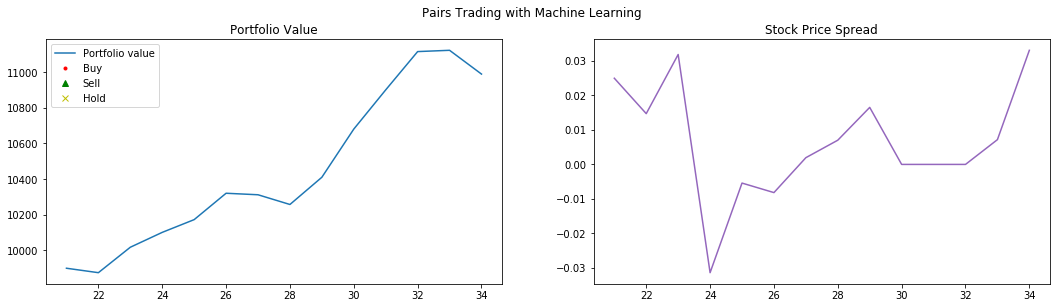

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.2288836  0.22891891 0.22825545]
 [0.3312923  0.3308067  0.33035   ]
 [0.34753048 0.3483785  0.347438  ]
 [0.32681248 0.3252279  0.32801875]
 [0.33259502 0.33173046 0.33293104]
 [0.33971107 0.33922216 0.3408702 ]
 [0.31427643 0.31374305 0.31423125]
 [0.3280116  0.32812214 0.32799867]
 [0.34889287 0.34814286 0.3476334 ]
 [0.34488592 0.34487838 0.34548658]
 [0.33200413 0.3296148  0.33406627]
 [0.33214557 0.33104977 0.3329809 ]
 [0.31718346 0.31737006 0.31764513]
 [0.31858772 0.318449   0.3184556 ]], shape=(14, 3), dtype=float32)


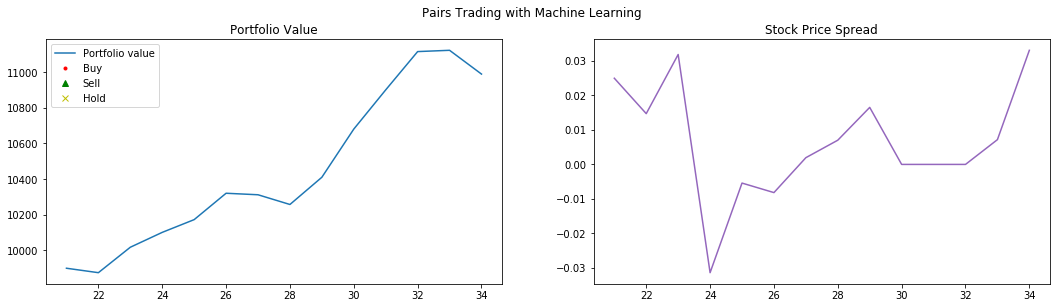

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22886188 0.2288972  0.22823374]
 [0.3312923  0.3308067  0.33035   ]
 [0.34753048 0.3483785  0.347438  ]
 [0.3268193  0.3252347  0.32802558]
 [0.3325887  0.33172414 0.33292472]
 [0.33967927 0.33919036 0.3408384 ]
 [0.31427598 0.3137426  0.31423083]
 [0.3280116  0.32812214 0.32799867]
 [0.34889287 0.34814286 0.3476334 ]
 [0.34483755 0.34483    0.3454382 ]
 [0.33196583 0.3295765  0.33402798]
 [0.33216742 0.33107162 0.33300275]
 [0.31712627 0.31731287 0.31758794]
 [0.31857643 0.3184377  0.3184443 ]], shape=(14, 3), dtype=float32)


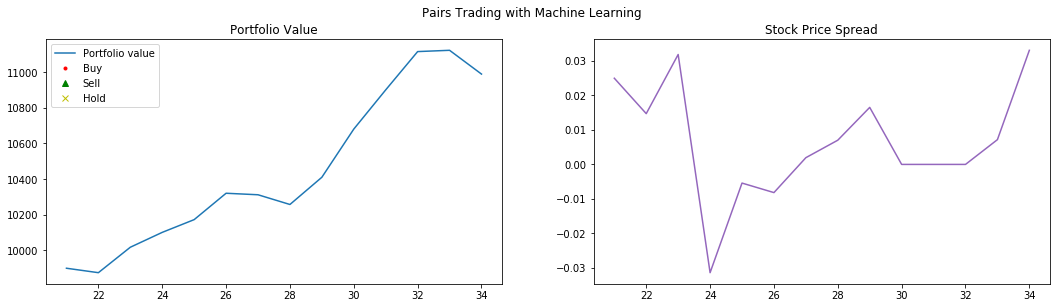

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22889425 0.22892956 0.2282661 ]
 [0.3312923  0.3308067  0.33035   ]
 [0.34753048 0.3483785  0.347438  ]
 [0.3268605  0.3252759  0.32806677]
 [0.33259487 0.3317303  0.3329309 ]
 [0.33967227 0.33918336 0.3408314 ]
 [0.31426978 0.3137364  0.31422463]
 [0.3280116  0.32812214 0.32799867]
 [0.34889287 0.34814286 0.3476334 ]
 [0.34485793 0.3448504  0.3454586 ]
 [0.3319164  0.32952705 0.33397853]
 [0.33216697 0.3310712  0.33300233]
 [0.31709242 0.317279   0.3175541 ]
 [0.3186165  0.31847778 0.3184844 ]], shape=(14, 3), dtype=float32)


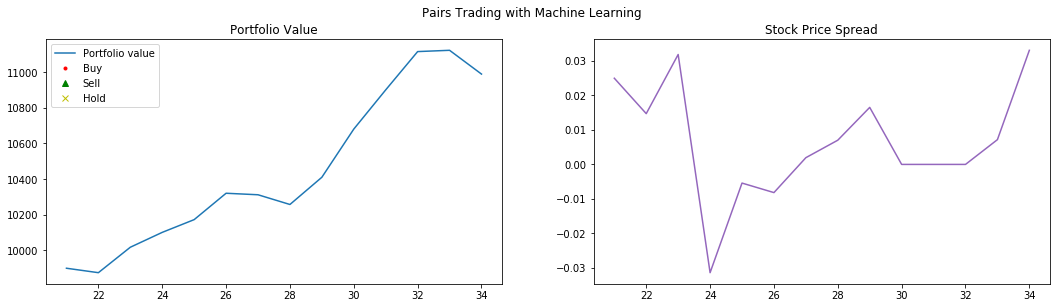

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22893003 0.22896534 0.22830188]
 [0.3312923  0.3308067  0.33035   ]
 [0.34753048 0.3483785  0.347438  ]
 [0.3268785  0.3252939  0.32808477]
 [0.33262008 0.33175552 0.3329561 ]
 [0.33971587 0.33922696 0.340875  ]
 [0.31428766 0.3137543  0.3142425 ]
 [0.3280116  0.32812214 0.32799867]
 [0.3488929  0.3481429  0.34763342]
 [0.34489134 0.3448838  0.345492  ]
 [0.33189884 0.3295095  0.33396098]
 [0.3321535  0.3310577  0.33298883]
 [0.3170719  0.3172585  0.31753358]
 [0.31866732 0.3185286  0.3185352 ]], shape=(14, 3), dtype=float32)


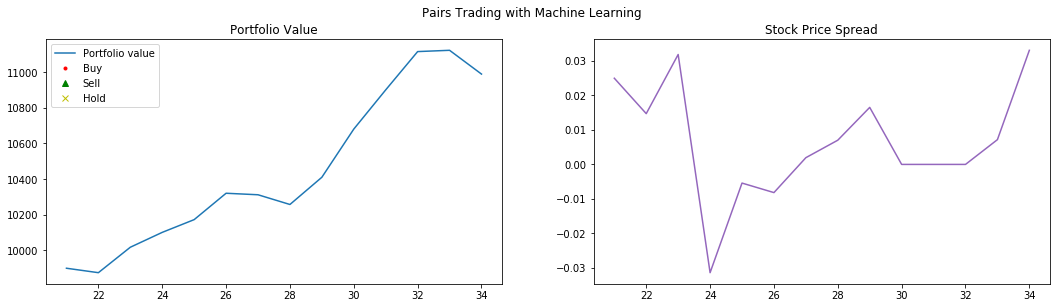

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22894971 0.22898503 0.22832157]
 [0.3312923  0.3308067  0.33035   ]
 [0.34753048 0.3483785  0.347438  ]
 [0.3268645  0.32527992 0.3280708 ]
 [0.33265755 0.33179298 0.33299357]
 [0.33978787 0.33929896 0.340947  ]
 [0.31432518 0.3137918  0.31428003]
 [0.3280116  0.32812214 0.32799867]
 [0.3488929  0.3481429  0.34763342]
 [0.34489888 0.34489134 0.34549955]
 [0.33189896 0.32950962 0.3339611 ]
 [0.33213755 0.33104175 0.33297288]
 [0.31702924 0.31721583 0.3174909 ]
 [0.31869993 0.3185612  0.3185678 ]], shape=(14, 3), dtype=float32)


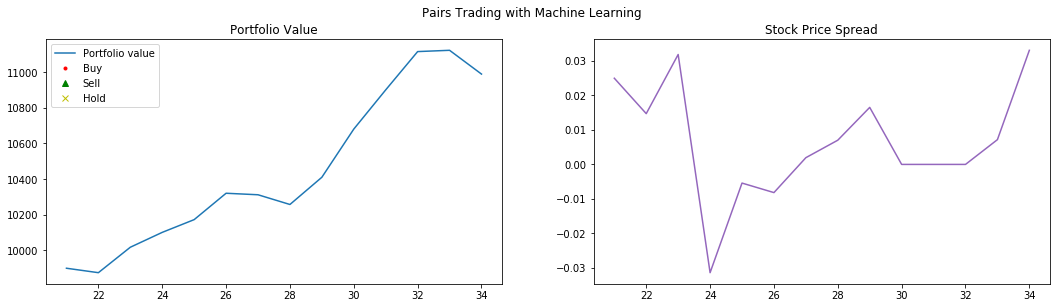

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22895691 0.22899222 0.22832876]
 [0.3312923  0.3308067  0.33035   ]
 [0.34753048 0.3483785  0.347438  ]
 [0.3268206  0.32523602 0.3280269 ]
 [0.33264738 0.33178285 0.3329834 ]
 [0.339787   0.3392981  0.34094614]
 [0.31435096 0.3138176  0.3143058 ]
 [0.3280116  0.3281221  0.32799864]
 [0.3488929  0.34814286 0.34763342]
 [0.34488982 0.34488228 0.3454905 ]
 [0.33189076 0.32950142 0.3339529 ]
 [0.3320932  0.3309974  0.33292854]
 [0.3169509  0.31713748 0.31741256]
 [0.31870747 0.31856874 0.31857535]], shape=(14, 3), dtype=float32)


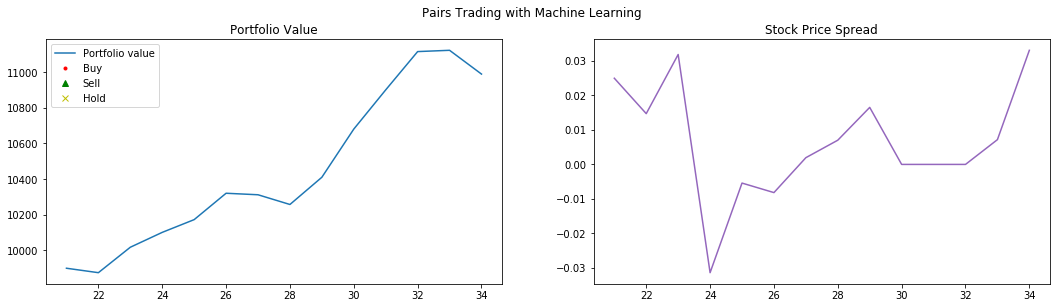

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22897315 0.22900847 0.228345  ]
 [0.3312923  0.3308067  0.33035   ]
 [0.34753048 0.3483785  0.347438  ]
 [0.3268091  0.32522452 0.3280154 ]
 [0.33263952 0.33177498 0.33297554]
 [0.339773   0.3392841  0.34093213]
 [0.31439894 0.3138656  0.31435376]
 [0.3280116  0.3281221  0.32799864]
 [0.3488929  0.34814286 0.34763342]
 [0.3448839  0.34487635 0.34548455]
 [0.33190814 0.3295188  0.33397028]
 [0.332051   0.3309552  0.33288634]
 [0.31687745 0.31706405 0.31733912]
 [0.31870493 0.3185662  0.31857282]], shape=(14, 3), dtype=float32)


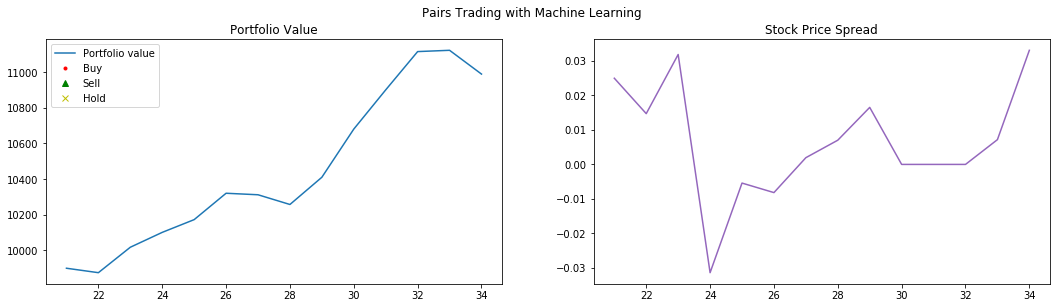

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22896546 0.22900078 0.22833732]
 [0.3312923  0.3308067  0.33035   ]
 [0.34753048 0.3483785  0.347438  ]
 [0.32680163 0.32521704 0.3280079 ]
 [0.3326117  0.33174717 0.33294773]
 [0.3397318  0.3392429  0.34089094]
 [0.31439966 0.3138663  0.31435448]
 [0.3280116  0.3281221  0.32799864]
 [0.3488929  0.34814286 0.34763342]
 [0.34484798 0.34484044 0.34544864]
 [0.33187217 0.32948282 0.3339343 ]
 [0.3320148  0.330919   0.33285013]
 [0.31680208 0.31698868 0.31726375]
 [0.31867537 0.31853664 0.31854326]], shape=(14, 3), dtype=float32)


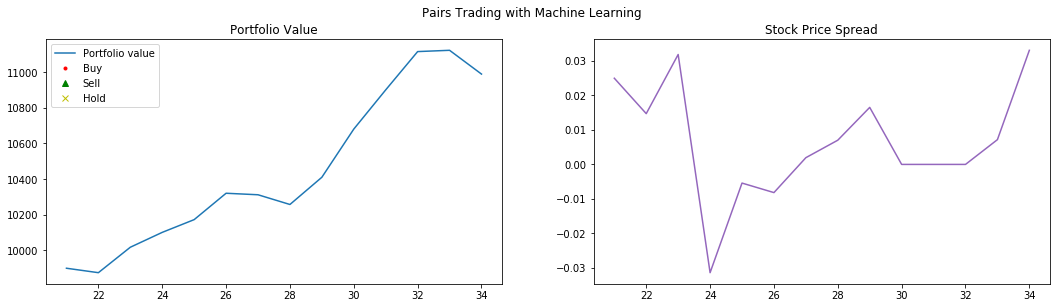

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22897601 0.22901133 0.22834787]
 [0.3312923  0.3308067  0.33035   ]
 [0.34753048 0.3483785  0.347438  ]
 [0.32682988 0.3252453  0.32803616]
 [0.33262458 0.33176005 0.3329606 ]
 [0.33978844 0.33929953 0.34094757]
 [0.31442457 0.3138912  0.3143794 ]
 [0.3280116  0.3281221  0.32799864]
 [0.3488929  0.34814286 0.34763342]
 [0.34482077 0.34481323 0.34542143]
 [0.33186454 0.3294752  0.33392668]
 [0.33203775 0.33094195 0.33287308]
 [0.316776   0.3169626  0.31723768]
 [0.3187072  0.31856844 0.31857508]], shape=(14, 3), dtype=float32)


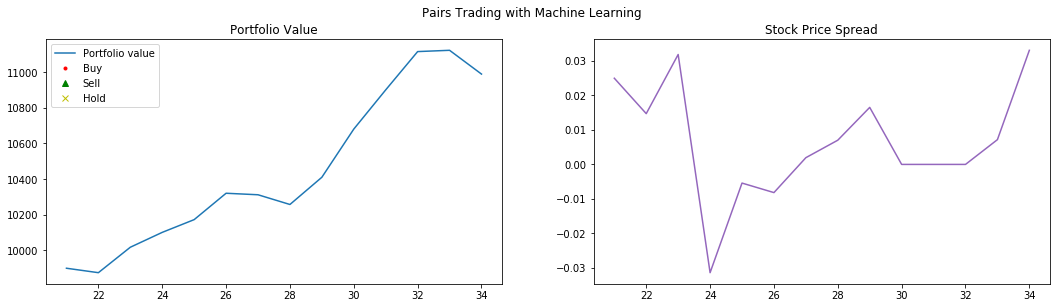

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.2290053  0.22904062 0.22837716]
 [0.3312923  0.3308067  0.33035   ]
 [0.34753048 0.3483785  0.347438  ]
 [0.32687    0.3252854  0.32807627]
 [0.33267987 0.33181533 0.3330159 ]
 [0.3398505  0.33936158 0.34100962]
 [0.31446734 0.31393397 0.31442216]
 [0.3280116  0.3281221  0.32799864]
 [0.34889293 0.3481429  0.34763342]
 [0.3448178  0.34481022 0.34541842]
 [0.33187336 0.32948402 0.3339355 ]
 [0.33211744 0.33102164 0.33295277]
 [0.31677157 0.31695816 0.31723323]
 [0.31876162 0.31862286 0.3186295 ]], shape=(14, 3), dtype=float32)


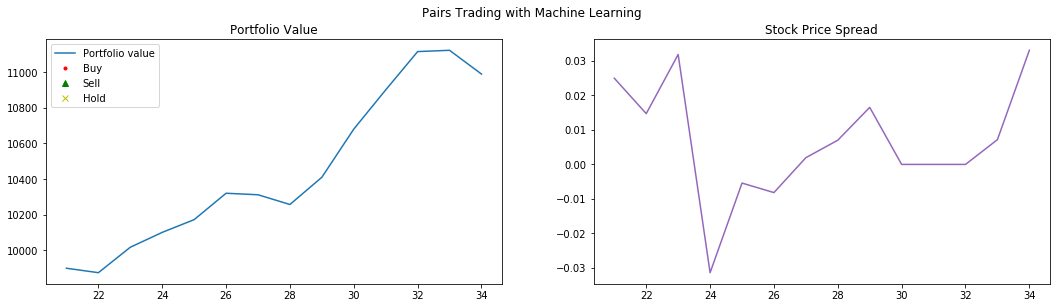

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22902372 0.22905907 0.22839561]
 [0.3312923  0.3308067  0.33035   ]
 [0.34753048 0.3483785  0.347438  ]
 [0.32689235 0.32530776 0.32809862]
 [0.3326916  0.33182707 0.33302763]
 [0.33985886 0.33936992 0.34101796]
 [0.31448936 0.313956   0.31444418]
 [0.3280116  0.3281221  0.32799864]
 [0.34889305 0.348143   0.34763354]
 [0.3448103  0.34480274 0.34541094]
 [0.33186197 0.32947263 0.3339241 ]
 [0.3321816  0.33108583 0.33301693]
 [0.31676477 0.31695136 0.31722644]
 [0.3188048  0.31866604 0.3186727 ]], shape=(14, 3), dtype=float32)


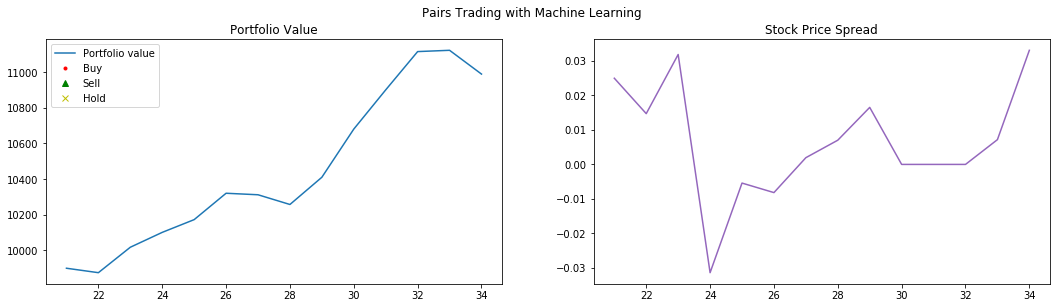

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22898674 0.22902209 0.22835863]
 [0.3312923  0.3308067  0.33035   ]
 [0.34753048 0.3483785  0.347438  ]
 [0.32687587 0.32529128 0.32808214]
 [0.33262166 0.33175713 0.33295768]
 [0.33981386 0.33932492 0.34097296]
 [0.31448293 0.31394956 0.31443775]
 [0.3280116  0.3281221  0.32799864]
 [0.34889305 0.348143   0.34763354]
 [0.34475607 0.3447485  0.3453567 ]
 [0.33183673 0.3294474  0.33389887]
 [0.33219698 0.3311012  0.3330323 ]
 [0.31668434 0.31687093 0.317146  ]
 [0.31878987 0.3186511  0.31865776]], shape=(14, 3), dtype=float32)


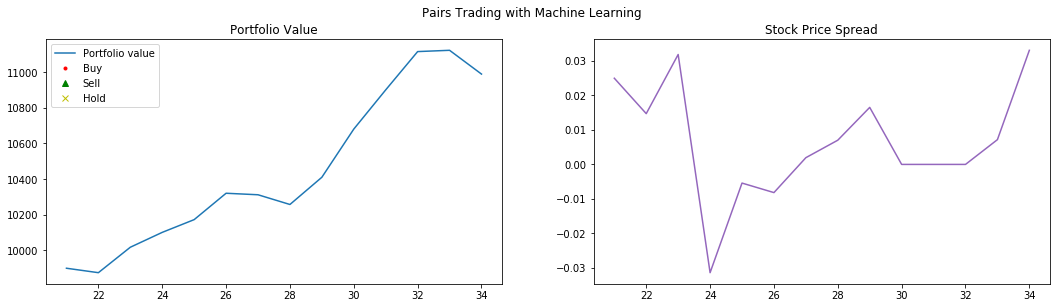

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22899774 0.22903308 0.22836962]
 [0.3312923  0.3308067  0.33035   ]
 [0.34753048 0.3483785  0.347438  ]
 [0.3269098  0.32532522 0.3281161 ]
 [0.33256465 0.33170012 0.33290067]
 [0.33983636 0.33934742 0.34099546]
 [0.31454876 0.3140154  0.31450358]
 [0.3280116  0.3281221  0.32799864]
 [0.34889305 0.348143   0.34763354]
 [0.34473947 0.34473193 0.3453401 ]
 [0.33185974 0.3294704  0.33392188]
 [0.33219627 0.3311005  0.3330316 ]
 [0.31666434 0.31685093 0.317126  ]
 [0.31883067 0.3186919  0.31869856]], shape=(14, 3), dtype=float32)


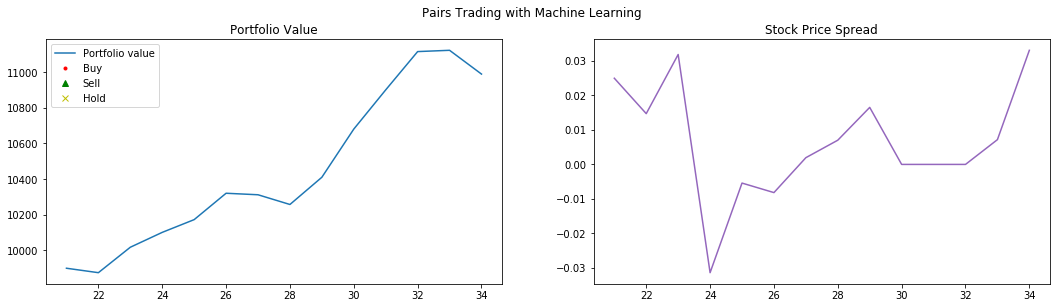

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22907506 0.2291104  0.22844695]
 [0.33129233 0.33080673 0.33035004]
 [0.34753048 0.3483785  0.347438  ]
 [0.32698745 0.32540286 0.32819372]
 [0.3325808  0.33171627 0.33291683]
 [0.33994278 0.33945385 0.34110188]
 [0.31468618 0.3141528  0.314641  ]
 [0.3280116  0.3281221  0.32799864]
 [0.34889305 0.348143   0.34763354]
 [0.3447764  0.34476885 0.34537703]
 [0.33195037 0.329561   0.33401248]
 [0.3322019  0.33110613 0.33303723]
 [0.31669885 0.31688544 0.31716052]
 [0.3189274  0.31878865 0.3187953 ]], shape=(14, 3), dtype=float32)


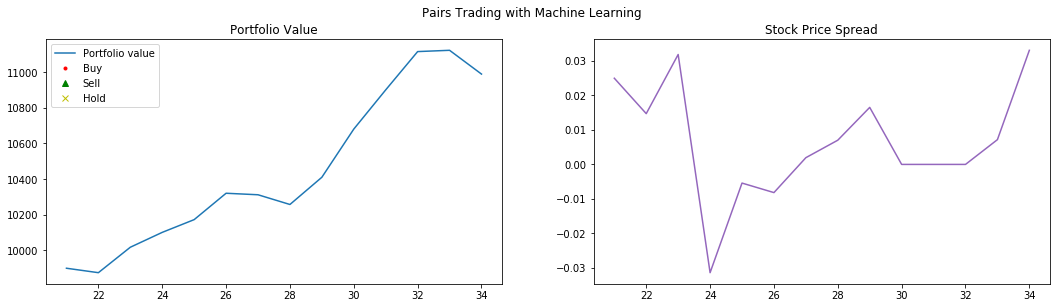

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22904712 0.22908247 0.228419  ]
 [0.33129233 0.33080673 0.33035004]
 [0.34753048 0.3483785  0.347438  ]
 [0.32696903 0.32538444 0.3281753 ]
 [0.3325296  0.33166504 0.3328656 ]
 [0.3399609  0.33947197 0.34112   ]
 [0.31471103 0.31417766 0.31466585]
 [0.32801163 0.32812214 0.32799864]
 [0.34889305 0.348143   0.34763354]
 [0.34473056 0.34472302 0.3453312 ]
 [0.33193916 0.3295498  0.33400127]
 [0.33216202 0.33106625 0.33299735]
 [0.31664956 0.31683615 0.31711122]
 [0.31891742 0.31877866 0.3187853 ]], shape=(14, 3), dtype=float32)


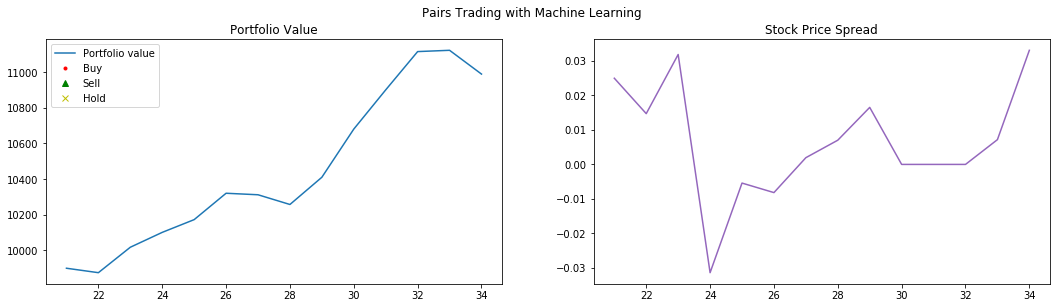

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22895578 0.22899112 0.22832766]
 [0.33129233 0.33080673 0.33035004]
 [0.34753048 0.3483785  0.347438  ]
 [0.32687578 0.3252912  0.32808205]
 [0.3324447  0.33158013 0.3327807 ]
 [0.33990222 0.33941326 0.3410613 ]
 [0.31465772 0.31412435 0.31461254]
 [0.32801163 0.32812214 0.32799864]
 [0.34889305 0.348143   0.3476335 ]
 [0.34462622 0.34461868 0.34522685]
 [0.33185598 0.3294666  0.3339181 ]
 [0.33208922 0.33099344 0.33292454]
 [0.31653577 0.31672236 0.31699744]
 [0.3188429  0.31870413 0.31871077]], shape=(14, 3), dtype=float32)


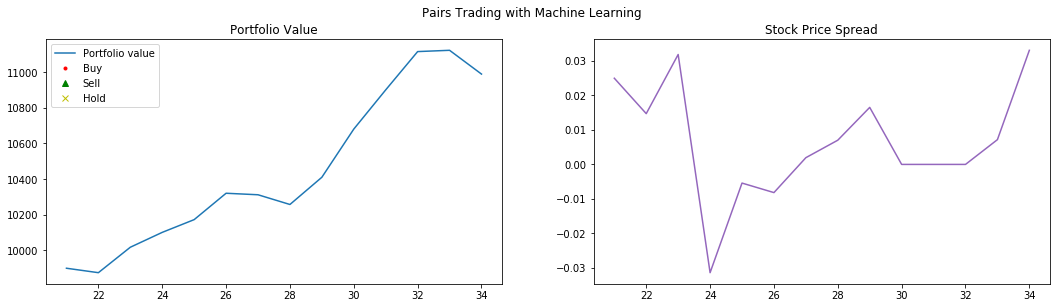

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.2289698  0.22900514 0.22834168]
 [0.3312923  0.33080673 0.33035   ]
 [0.34753048 0.3483785  0.347438  ]
 [0.3268237  0.32523912 0.32803   ]
 [0.33244115 0.3315766  0.33277714]
 [0.33990496 0.33941603 0.34106404]
 [0.31462532 0.31409195 0.31458014]
 [0.32801163 0.32812214 0.32799864]
 [0.34889305 0.34814298 0.3476335 ]
 [0.34461522 0.34460768 0.34521586]
 [0.3317855  0.32939613 0.3338476 ]
 [0.33204016 0.33094436 0.33287546]
 [0.31644443 0.31663102 0.31690606]
 [0.31886542 0.31872666 0.3187333 ]], shape=(14, 3), dtype=float32)


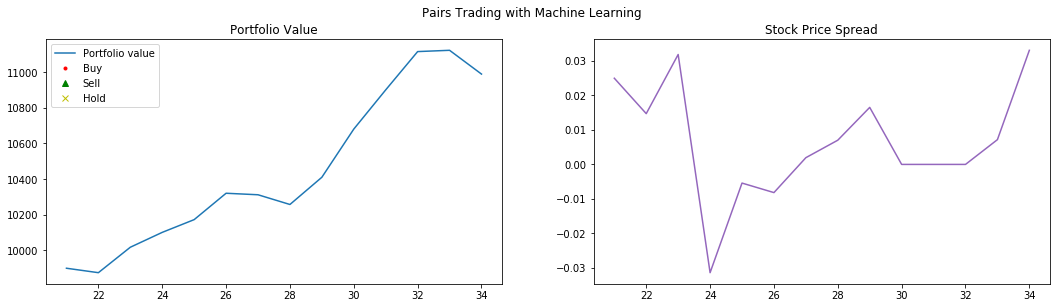

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22910318 0.22913852 0.22847506]
 [0.3312923  0.33080673 0.33035   ]
 [0.34753048 0.3483785  0.347438  ]
 [0.32685772 0.32527313 0.328064  ]
 [0.33247766 0.3316131  0.33281365]
 [0.3399663  0.33947733 0.34112537]
 [0.3146299  0.31409654 0.31458473]
 [0.32801163 0.32812214 0.32799864]
 [0.34889305 0.34814298 0.3476335 ]
 [0.34472194 0.3447144  0.34532258]
 [0.33175024 0.32936087 0.33381236]
 [0.33201933 0.33092353 0.33285463]
 [0.31645605 0.31664264 0.3169177 ]
 [0.31897745 0.3188387  0.31884533]], shape=(14, 3), dtype=float32)


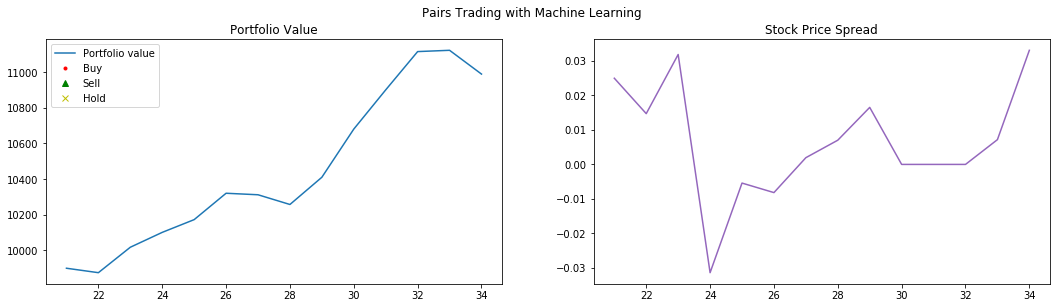

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22921723 0.22925258 0.22858912]
 [0.3312923  0.33080673 0.33035   ]
 [0.34753048 0.3483785  0.347438  ]
 [0.32691133 0.32532674 0.3281176 ]
 [0.33251637 0.3316518  0.33285236]
 [0.34005743 0.33956847 0.3412165 ]
 [0.31467018 0.3141368  0.314625  ]
 [0.32801163 0.32812214 0.32799864]
 [0.34889305 0.34814298 0.3476335 ]
 [0.34480947 0.34480193 0.3454101 ]
 [0.33174908 0.3293597  0.3338112 ]
 [0.33204523 0.33094943 0.33288053]
 [0.3164948  0.31668139 0.31695643]
 [0.31906992 0.31893116 0.3189378 ]], shape=(14, 3), dtype=float32)


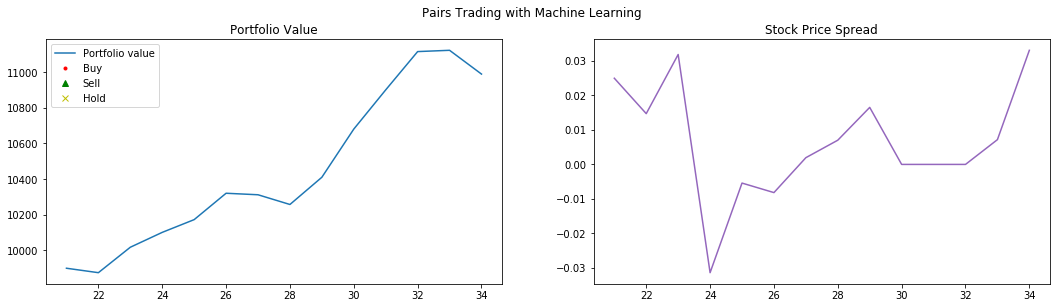

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
distribute
No distribtion
No distribtion
distribute
tf.Tensor(
[[0.22922784 0.22926319 0.22859973]
 [0.3312923  0.33080673 0.33035   ]
 [0.34753048 0.3483785  0.347438  ]
 [0.32689577 0.32531118 0.32810205]
 [0.3325021  0.33163753 0.3328381 ]
 [0.34007037 0.33958137 0.34122944]
 [0.31466925 0.31413588 0.31462407]
 [0.32801163 0.32812214 0.32799864]
 [0.34889305 0.34814298 0.3476335 ]
 [0.34479874 0.3447912  0.34539938]
 [0.33172083 0.32933146 0.33378294]
 [0.3320634  0.3309676  0.3328987 ]
 [0.31643242 0.316619   0.31689405]
 [0.3190618  0.31892303 0.31892967]], shape=(14, 3), dtype=float32)


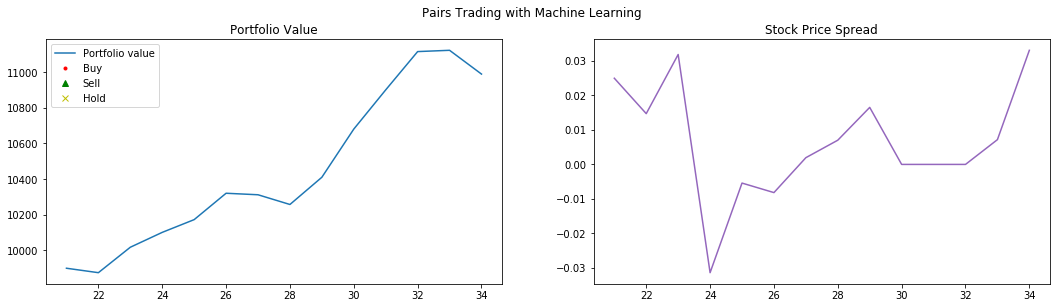

distribute
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion
No distribtion


KeyboardInterrupt: 

In [149]:
action_history = []

obs = env.reset()
running_reward = 0
gamma = 0.99
for episode in range(0, 1000):
    obs = env.reset()
    obs_history = []
    model.reset()
    reward = 0
    done = False
    counter = 0
    while not done and counter < 14:
        
        state_value, actionProb = model.predict(obs)
        obs, reward, done, msg = env.step(actionProb)
        obs_history.append(obs[None, :][0])
        
        model.saved_actions.append(action)
        model.saved_values.append(state_value[0][0])
        model.rewards.append(reward)
        if done:
            break
        counter+=1
    model.train(obs_history)
    
    env.render()
